In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
! git clone https://github.com/craach/road-map-bounding-box-prediction.git
%cd road-map-bounding-box-prediction

Cloning into 'project'...
remote: Enumerating objects: 69, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 121922 (delta 40), reused 27 (delta 9), pack-reused 121853
Receiving objects: 100% (121922/121922), 1.34 GiB | 15.58 MiB/s, done.
Resolving deltas: 100% (40/40), done.
Checking out files: 100% (104847/104847), done.
/content/project


In [0]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt 
matplotlib.rcParams['figure.figsize'] = [5, 5] 
matplotlib.rcParams['figure.dpi'] = 200
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from data_helper import UnlabeledDataset, LabeledDataset
from google.colab.patches import cv2_imshow
from helper import collate_fn, draw_box

In [0]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

image_folder = 'data'
annotation_csv = 'data/annotation.csv'

# All the images are saved in image_folder
# All the labels are saved in the annotation_csv file image_folder = 'data'
annotation_csv = 'data/annotation.csv'

# You shouldn't change the unlabeled_scene_index
# The first 106 scenes are unlabeled
unlabeled_scene_index = np.arange(106)
# The scenes from 106 - 133 are labeled
# You should devide the labeled_scene_index into two subsets (training and validation)
labeled_scene_validation_index = np.random.choice(np.arange(106, 134), 8, replace=False)
labeled_scene_train_index = np.array(list(set(np.arange(106, 134)) - set(labeled_scene_validation_index)))

transform = torchvision.transforms.ToTensor()

device = "cuda:0"

In [0]:
# The full road model holds and image model (ResNet18), and applies that
# image model to each of the 6 road images.
class RoadModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.image_model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', 
                                          pretrained=False)
        self.fc1 = nn.Linear(6000, 2500)
        self.ups1 = nn.Upsample(size=100, mode='bilinear')
        self.deconv1 = nn.ConvTranspose2d(in_channels=1, out_channels=32, 
                                          kernel_size=3, stride=1, padding=1)
        self.ups2 = nn.Upsample(size=200, mode='bilinear')
        self.deconv2 = nn.ConvTranspose2d(in_channels=32, out_channels=16, 
                                          kernel_size=3, stride=1, padding=1)
        self.ups3 = nn.Upsample(size=400, mode='bilinear')
        self.deconv3 = nn.ConvTranspose2d(in_channels=16, out_channels=4, 
                                          kernel_size=3, stride=1, padding=1)
        self.ups4 = nn.Upsample(size=800, mode='bilinear')
        self.deconv4 = nn.ConvTranspose2d(in_channels=4, out_channels=1, 
                                          kernel_size=3, stride=1, padding=1)
    
    
    def forward(self, x):
        features = []
        for im in x:
            features.append(self.image_model(im))
        x = torch.cat(features, dim=1)
        x = self.fc1(x)
        # x = F.relu(x)
        x = x.reshape([-1, 1, 50, 50])
        x = self.ups1(x)
        x = self.deconv1(x)
        x = F.relu(x)
        x = self.ups2(x)
        x = self.deconv2(x)
        x = F.relu(x)
        x = self.ups3(x)
        x = self.deconv3(x)
        x = F.relu(x)
        x = self.ups4(x)
        x = self.deconv4(x)
        return torch.sigmoid(x)

In [0]:
def train(model, optimizer, trainloader, validationloader, loss, batch_size, version):
    fig, ax = plt.subplots()
    epochs = 75
    best_avg_loss = np.inf

    metrics_dict = {}
    metrics_dict["train"] = {}
    metrics_dict["val"] = {}
    metrics_dict["train"]["loss"] = {}
    metrics_dict["val"]["loss"] = {}
    metrics_dict["train"]["loss"]["epochwise"] = []
    # metrics_dict["train"]["loss"]["stepwise"] = []
    metrics_dict["val"]["loss"]["epochwise"] = []
    # metrics_dict["val"]["score"] = []

    for ep in range(epochs):

      # train
      total_loss = 0.0
      i = 0
      for sample, target, road_image, extra in trainloader:
        optimizer.zero_grad()
        batch = torch.stack(sample).permute(1, 0, 2, 3, 4)
        batch = batch.to(device)
        l = loss(model(batch), 
                 torch.stack(road_image).reshape([batch_size,1,800,800]).float().to(device))
        l.backward()
        optimizer.step()
        if i % 20 == 0:
          print("epoch {}, iter {}: {}".format(ep, i, l))
        total_loss += l
        i += 1

      avg_loss = total_loss / i
      metrics_dict["train"]["loss"]["epochwise"].append(avg_loss)     
      
      # val
      total_loss = 0.0
      j = 0
      for sample, target, road_image, extra in validationloader:
        with torch.no_grad():
          batch = torch.stack(sample).permute(1, 0, 2, 3, 4)
          batch = batch.to(device)
          l = loss(model(batch), 
                   torch.stack(road_image).reshape([batch_size,1,800,800]).float().to(device))
          total_loss += l
          j += 1
      
      # Print validation loss, last road images
      avg_loss = total_loss / j
      print("validation epoch {}: {}".format(ep, avg_loss))
      metrics_dict["val"]["loss"]["epochwise"].append(avg_loss)
      cv2_imshow(road_image[0].detach().numpy() * 255)
      print('\n')
      cv2_imshow(model(batch)[0][0].cpu().detach().numpy().round() * 255)
      # Save best model
      if avg_loss < best_avg_loss:
        best_avg_loss = avg_loss
        torch.save(model.state_dict(), 
                 '/content/drive/My Drive/1008-competition/model_run/RoadModel/road_version-{}_epoch-{}_best_model.pth'.format(version, ep))
      
      # Save model
      torch.save({
        'epoch': ep,
        'model_state_dict': model.state_dict(),
        'full_metrics': metrics_dict
        }, '/content/drive/My Drive/1008-competition/model_run/RoadModel/road_version-{}_epoch-{}.pth'.format(version, ep))

In [0]:
def calc_threat(model, dataloader):
  max_score = -1
  max_ep = 0
  for ep in range(70):
    model.load_state_dict(torch.load('/content/drive/My Drive/models/road_version-2_epoch-{}.pth'.format(ep)))
    i = 0
    total_score = 0.0
    for sample, target, road_image, extra in dataloader:
      batch = torch.stack(sample).permute(1, 0, 2, 3, 4)
      batch = batch.to(device)
      for j in range(8):
        guess = model(batch[:, j:j+1])[0].cpu().detach().numpy().round() 
        real = road_image[j].detach().numpy()
        tp = np.sum(guess * real)
        fp = np.sum(guess * (1 - real))
        fn = np.sum((1-guess) * real)
        total_score += (tp / (tp + fp + fn))
        i += 1
    score = total_score / i
    if score > max_score or max_score < 0:
      max_ep = ep
      max_score = score
    print(max_ep)
    print(max_score)



Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


epoch 0, iter 0: 0.2664230465888977
epoch 0, iter 20: 0.1629738211631775
epoch 0, iter 40: 0.1135714054107666
epoch 0, iter 60: 0.1464124470949173
epoch 0, iter 80: 0.10570910573005676
epoch 0, iter 100: 0.13495805859565735
epoch 0, iter 120: 0.1642076075077057
epoch 0, iter 140: 0.10858959704637527
epoch 0, iter 160: 0.11217677593231201
epoch 0, iter 180: 0.13094864785671234
epoch 0, iter 200: 0.11250431835651398
epoch 0, iter 220: 0.11401160806417465
epoch 0, iter 240: 0.10617604851722717
epoch 0, iter 260: 0.09141072630882263
epoch 0, iter 280: 0.09617338329553604
epoch 0, iter 300: 0.1308080106973648
validation epoch 0: 0.12119773775339127


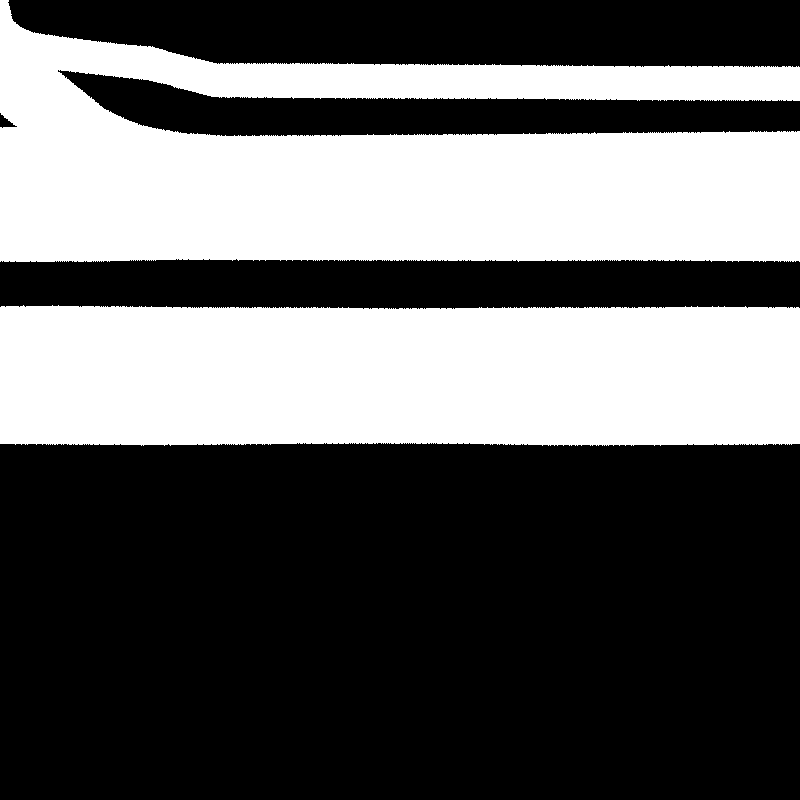

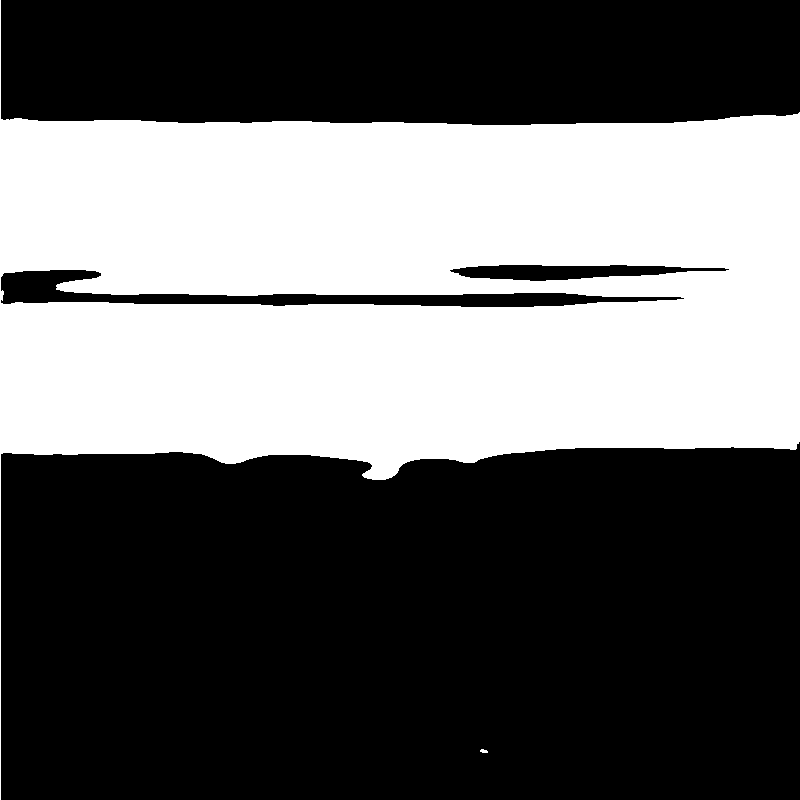

epoch 1, iter 0: 0.10818354040384293
epoch 1, iter 20: 0.07935392111539841
epoch 1, iter 40: 0.11193090677261353
epoch 1, iter 60: 0.10443935543298721
epoch 1, iter 80: 0.09165789932012558
epoch 1, iter 100: 0.17639338970184326
epoch 1, iter 120: 0.07483033090829849
epoch 1, iter 140: 0.1199168935418129
epoch 1, iter 160: 0.15129823982715607
epoch 1, iter 180: 0.10377248376607895
epoch 1, iter 200: 0.07378225773572922
epoch 1, iter 220: 0.09967443346977234
epoch 1, iter 240: 0.0813966691493988
epoch 1, iter 260: 0.08409291505813599
epoch 1, iter 280: 0.1123766303062439
epoch 1, iter 300: 0.0745323970913887
validation epoch 1: 0.11544379591941833


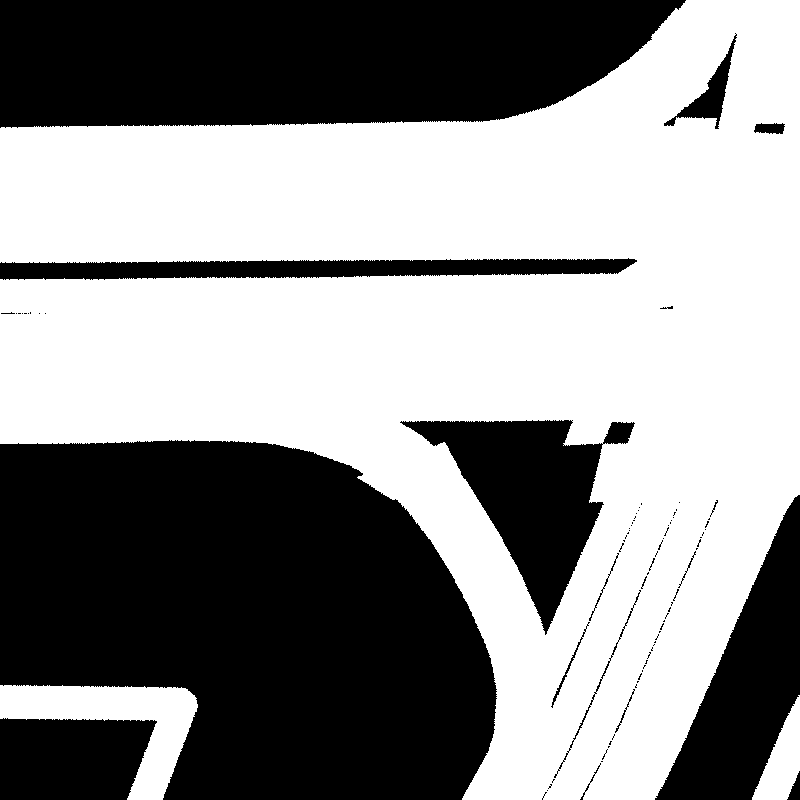

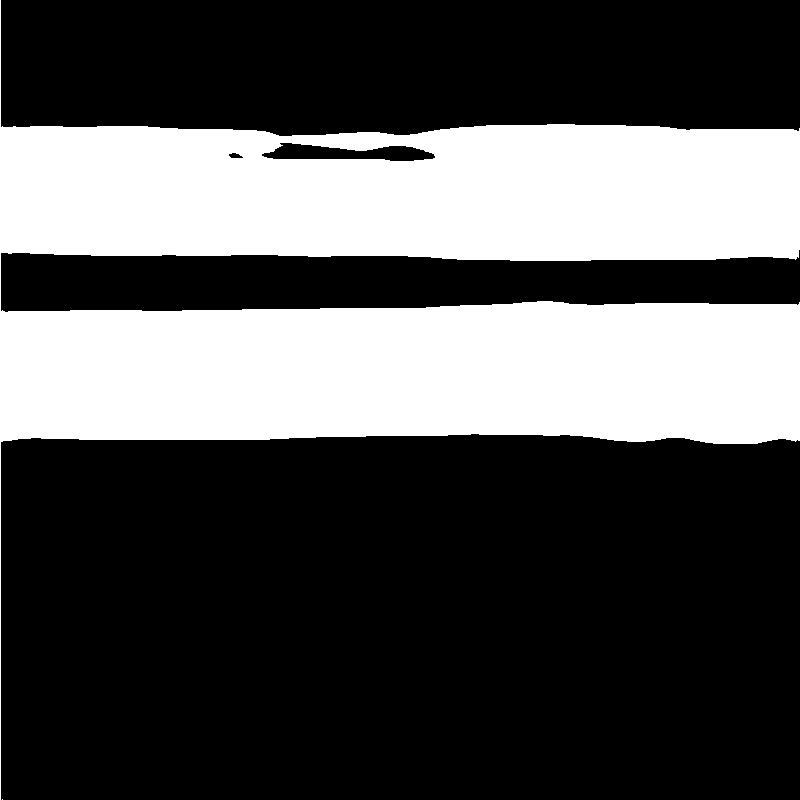

epoch 2, iter 0: 0.08280670642852783
epoch 2, iter 20: 0.10114172846078873
epoch 2, iter 40: 0.08562963455915451
epoch 2, iter 60: 0.07043702155351639
epoch 2, iter 80: 0.06979592144489288
epoch 2, iter 100: 0.10347558557987213
epoch 2, iter 120: 0.08362775295972824
epoch 2, iter 140: 0.06686290353536606
epoch 2, iter 160: 0.09647827595472336
epoch 2, iter 180: 0.09745197743177414
epoch 2, iter 200: 0.10709205269813538
epoch 2, iter 220: 0.09233284741640091
epoch 2, iter 240: 0.08708418905735016
epoch 2, iter 260: 0.12286333739757538
epoch 2, iter 280: 0.10027141124010086
epoch 2, iter 300: 0.08207467198371887
validation epoch 2: 0.10210111737251282


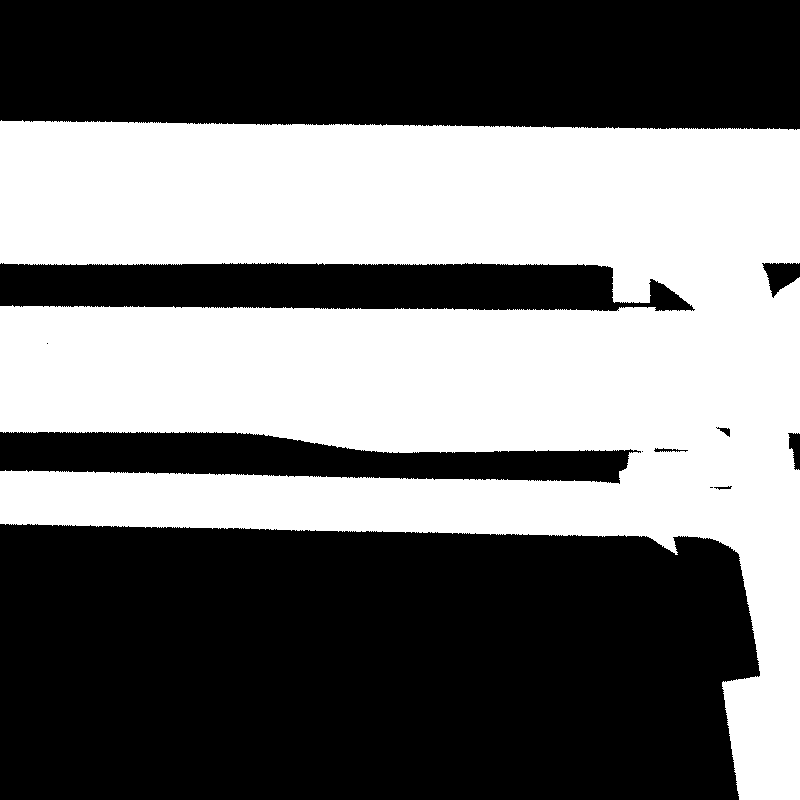

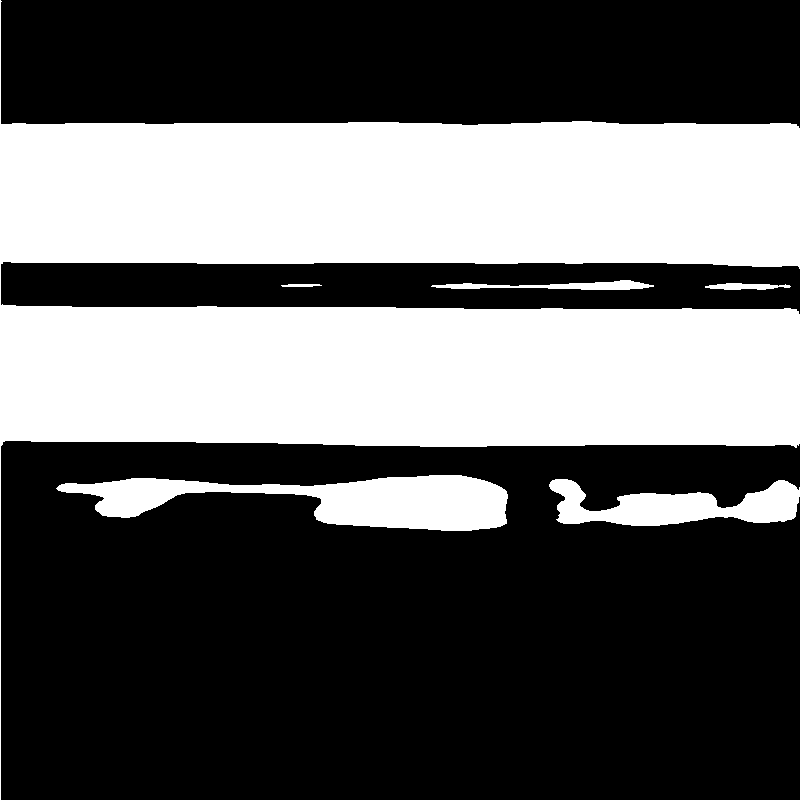

epoch 3, iter 0: 0.08134213089942932
epoch 3, iter 20: 0.08531253784894943
epoch 3, iter 40: 0.05752820894122124
epoch 3, iter 60: 0.09208138287067413
epoch 3, iter 80: 0.09328007698059082
epoch 3, iter 100: 0.08509479463100433
epoch 3, iter 120: 0.10621143877506256
epoch 3, iter 140: 0.08333835005760193
epoch 3, iter 160: 0.08664686977863312
epoch 3, iter 180: 0.09645665436983109
epoch 3, iter 200: 0.09132544696331024
epoch 3, iter 220: 0.08396520465612411
epoch 3, iter 240: 0.08811495453119278
epoch 3, iter 260: 0.0906093642115593
epoch 3, iter 280: 0.08184608072042465
epoch 3, iter 300: 0.06940274685621262
validation epoch 3: 0.10917304456233978


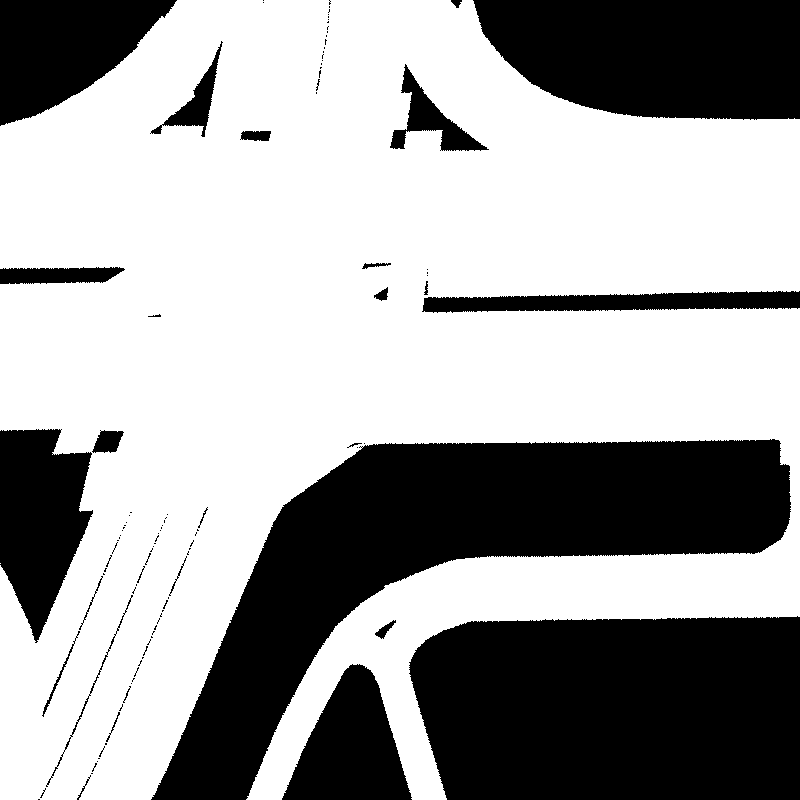

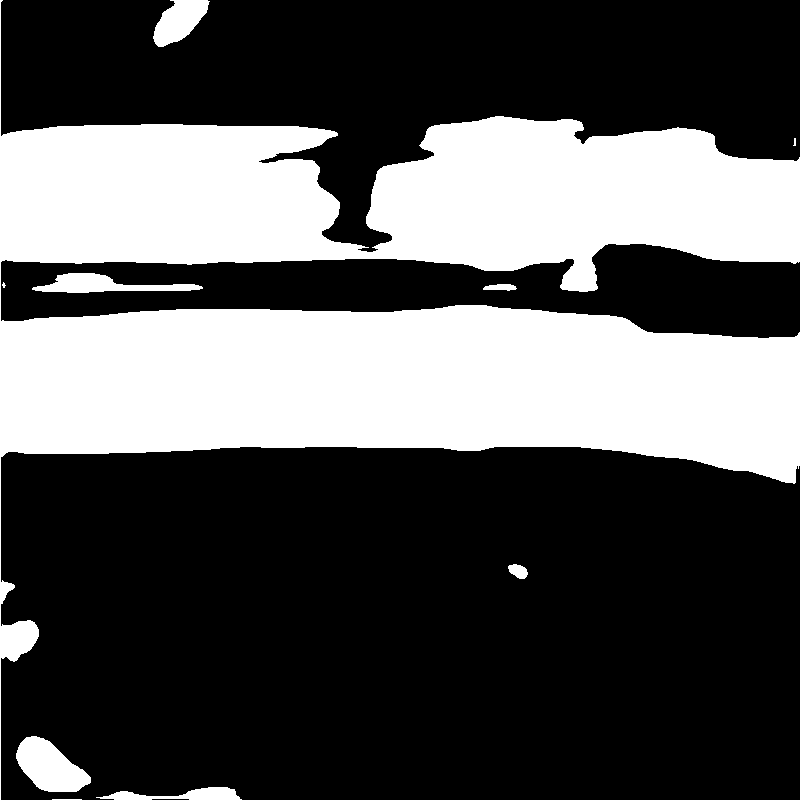

epoch 4, iter 0: 0.07156355679035187
epoch 4, iter 20: 0.09288465976715088
epoch 4, iter 40: 0.09519948810338974
epoch 4, iter 60: 0.11397826671600342
epoch 4, iter 80: 0.07620497047901154
epoch 4, iter 100: 0.12160113453865051
epoch 4, iter 120: 0.08663897216320038
epoch 4, iter 140: 0.10100678354501724
epoch 4, iter 160: 0.07877825945615768
epoch 4, iter 180: 0.05856535956263542
epoch 4, iter 200: 0.07348083704710007
epoch 4, iter 220: 0.07179004698991776
epoch 4, iter 240: 0.04419802129268646
epoch 4, iter 260: 0.08961977809667587
epoch 4, iter 280: 0.08818376809358597
epoch 4, iter 300: 0.0793248787522316
validation epoch 4: 0.11750414967536926


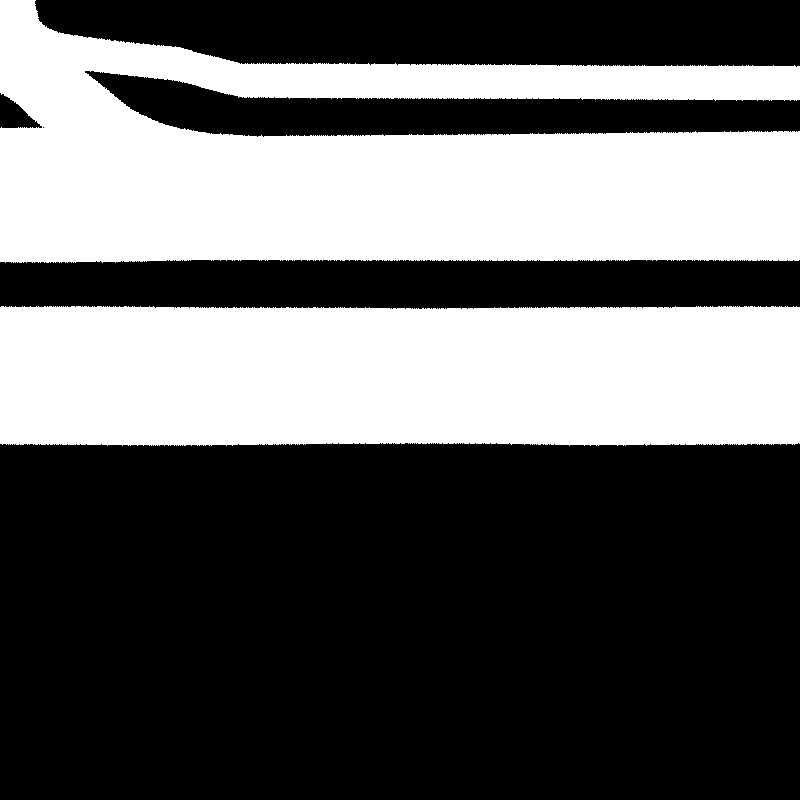

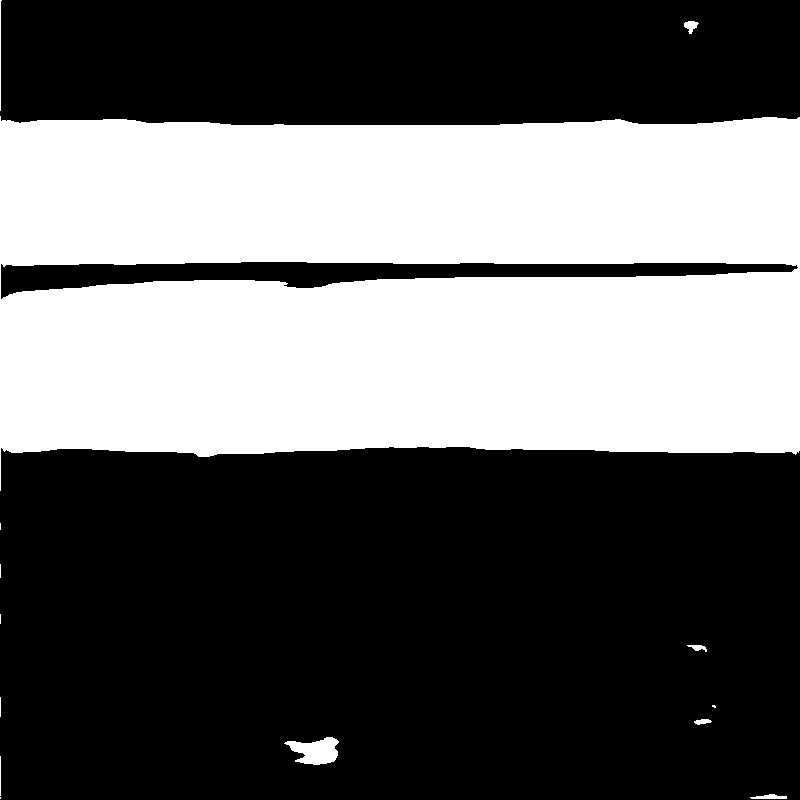

epoch 5, iter 0: 0.08858492970466614
epoch 5, iter 20: 0.03747797757387161
epoch 5, iter 40: 0.08494465798139572
epoch 5, iter 60: 0.06588899344205856
epoch 5, iter 80: 0.0673297643661499
epoch 5, iter 100: 0.052693869918584824
epoch 5, iter 120: 0.06740662455558777
epoch 5, iter 140: 0.0829925611615181
epoch 5, iter 160: 0.08694159984588623
epoch 5, iter 180: 0.05240734666585922
epoch 5, iter 200: 0.1050054207444191
epoch 5, iter 220: 0.07342496514320374
epoch 5, iter 240: 0.08865473419427872
epoch 5, iter 260: 0.05881594121456146
epoch 5, iter 280: 0.057556260377168655
epoch 5, iter 300: 0.07345189899206161
validation epoch 5: 0.10131850838661194


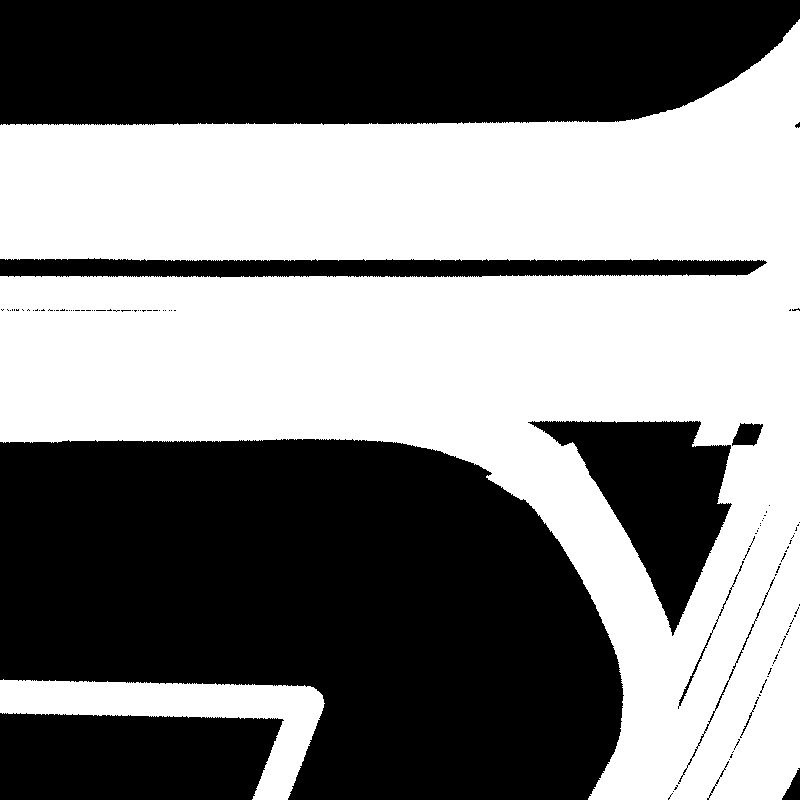

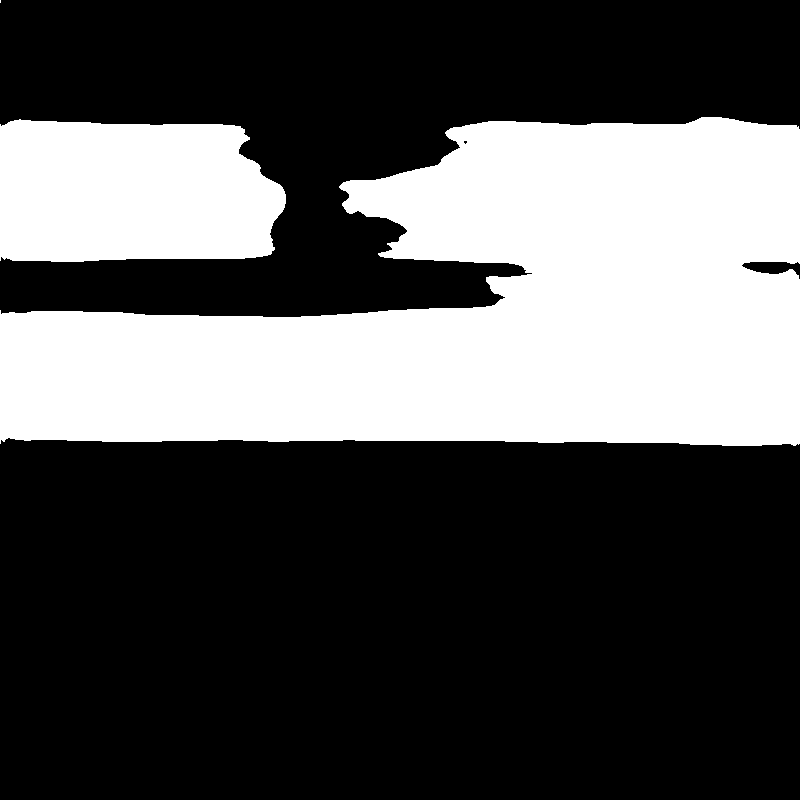

epoch 6, iter 0: 0.058363836258649826
epoch 6, iter 20: 0.061700571328401566
epoch 6, iter 40: 0.08221185207366943
epoch 6, iter 60: 0.07576292753219604
epoch 6, iter 80: 0.07655617594718933
epoch 6, iter 100: 0.054224155843257904
epoch 6, iter 120: 0.06425688415765762
epoch 6, iter 140: 0.05801839381456375
epoch 6, iter 160: 0.06264159828424454
epoch 6, iter 180: 0.08701355010271072
epoch 6, iter 200: 0.06726028770208359
epoch 6, iter 220: 0.06499714404344559
epoch 6, iter 240: 0.08930616080760956
epoch 6, iter 260: 0.07129832357168198
epoch 6, iter 280: 0.06019381433725357
epoch 6, iter 300: 0.06822110712528229
validation epoch 6: 0.09859617799520493


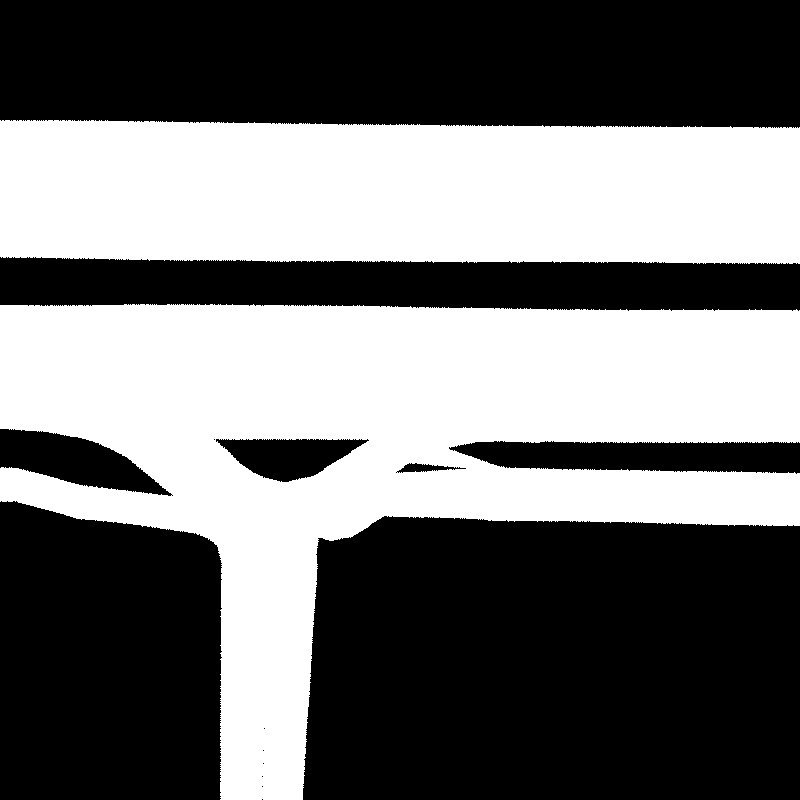

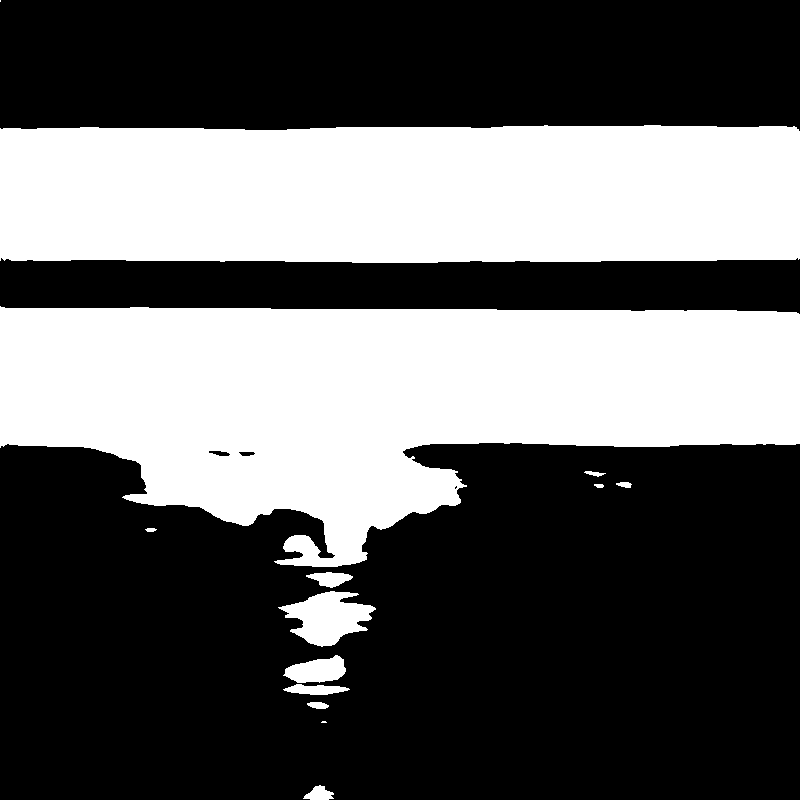

epoch 7, iter 0: 0.0739736407995224
epoch 7, iter 20: 0.08402993530035019
epoch 7, iter 40: 0.06667760014533997
epoch 7, iter 60: 0.06566546857357025
epoch 7, iter 80: 0.06263980269432068
epoch 7, iter 100: 0.09154857695102692
epoch 7, iter 120: 0.07552921026945114
epoch 7, iter 140: 0.043565958738327026
epoch 7, iter 160: 0.04890768229961395
epoch 7, iter 180: 0.07924418896436691
epoch 7, iter 200: 0.05954381078481674
epoch 7, iter 220: 0.0668966993689537
epoch 7, iter 240: 0.07539229840040207
epoch 7, iter 260: 0.04231591522693634
epoch 7, iter 280: 0.08675067871809006
epoch 7, iter 300: 0.041307687759399414
validation epoch 7: 0.09671147167682648


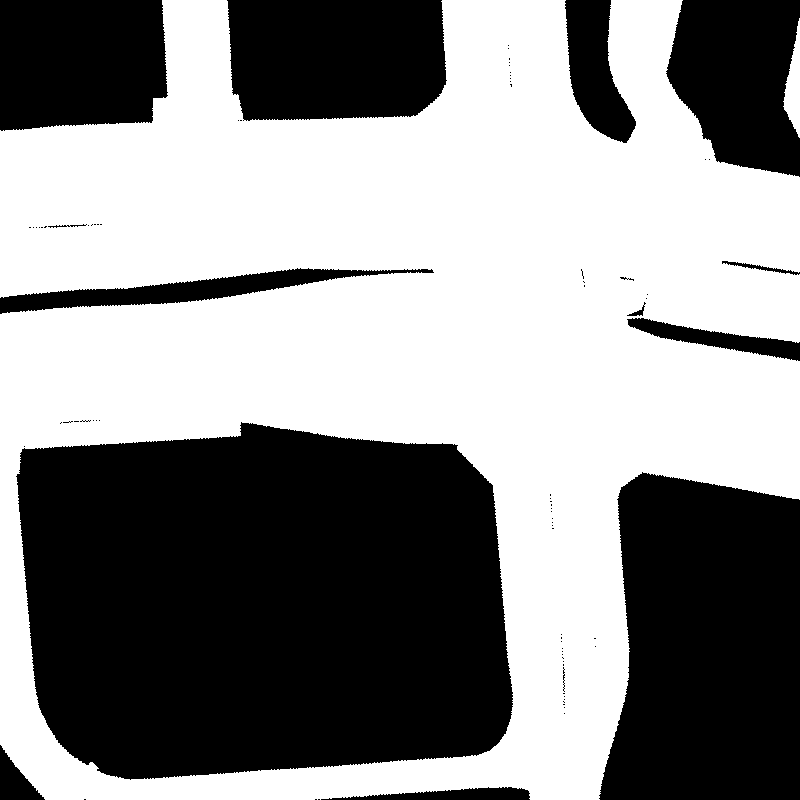

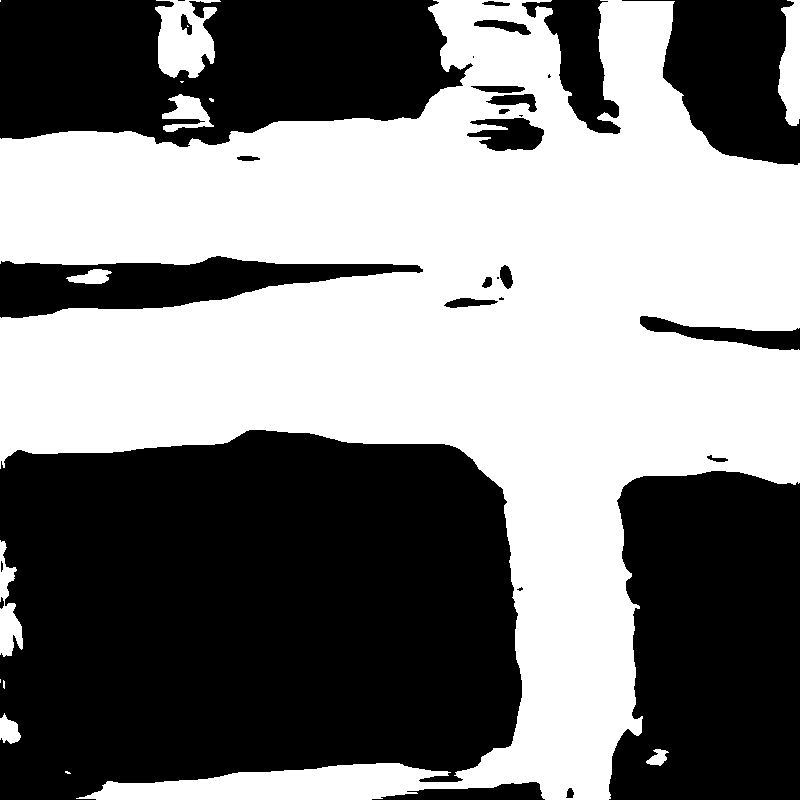

epoch 8, iter 0: 0.07626523077487946
epoch 8, iter 20: 0.062418267130851746
epoch 8, iter 40: 0.07673569023609161
epoch 8, iter 60: 0.06539672613143921
epoch 8, iter 80: 0.06524161249399185
epoch 8, iter 100: 0.07003685086965561
epoch 8, iter 120: 0.07165808975696564
epoch 8, iter 140: 0.05271288752555847
epoch 8, iter 160: 0.08447150141000748
epoch 8, iter 180: 0.05011044070124626
epoch 8, iter 200: 0.05114345625042915
epoch 8, iter 220: 0.053941626101732254
epoch 8, iter 240: 0.06600416451692581
epoch 8, iter 260: 0.07990127801895142
epoch 8, iter 280: 0.07744473963975906
epoch 8, iter 300: 0.057755496352910995
validation epoch 8: 0.09001311659812927


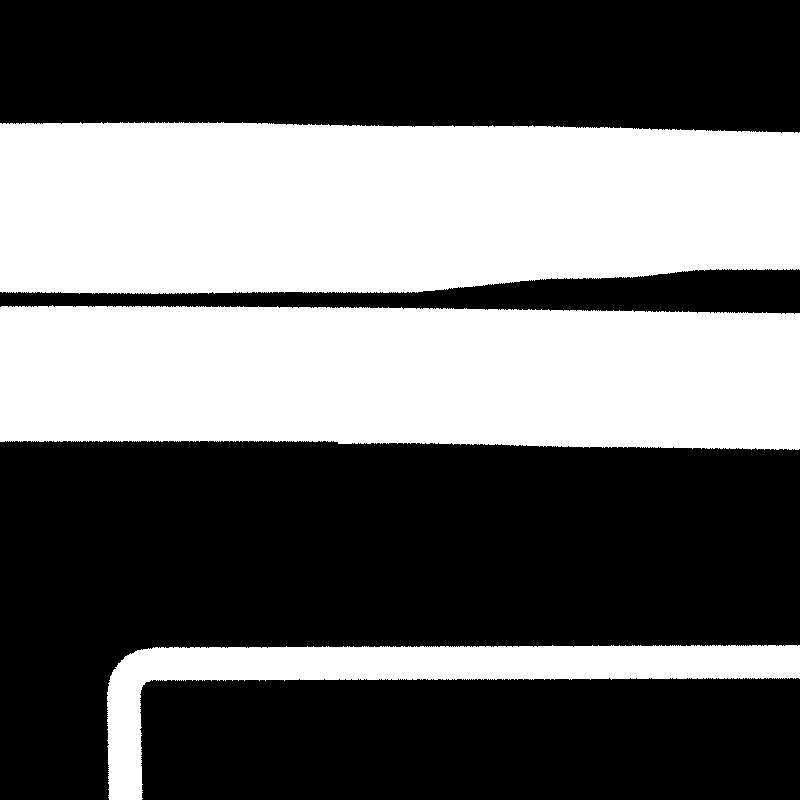

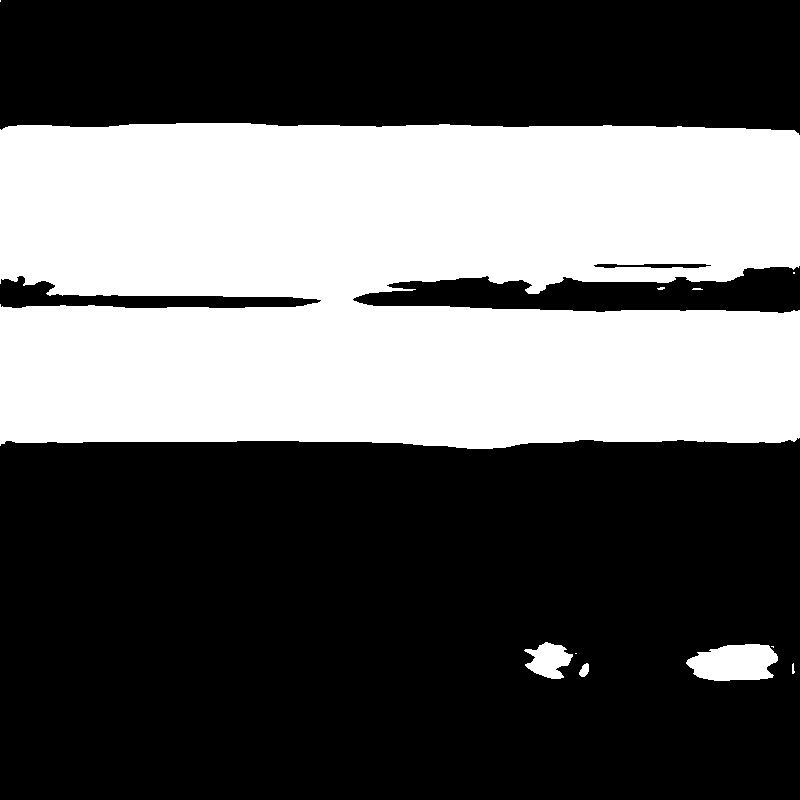

epoch 9, iter 0: 0.0546044185757637
epoch 9, iter 20: 0.06320999562740326
epoch 9, iter 40: 0.07162840664386749
epoch 9, iter 60: 0.048052240163087845
epoch 9, iter 80: 0.05009470880031586
epoch 9, iter 100: 0.05038515850901604
epoch 9, iter 120: 0.05404369905591011
epoch 9, iter 140: 0.041844770312309265
epoch 9, iter 160: 0.05023066699504852
epoch 9, iter 180: 0.0778668075799942
epoch 9, iter 200: 0.0490383580327034
epoch 9, iter 220: 0.03755263611674309
epoch 9, iter 240: 0.05420484393835068
epoch 9, iter 260: 0.07850171625614166
epoch 9, iter 280: 0.0697295218706131
epoch 9, iter 300: 0.03479088097810745
validation epoch 9: 0.08958534896373749


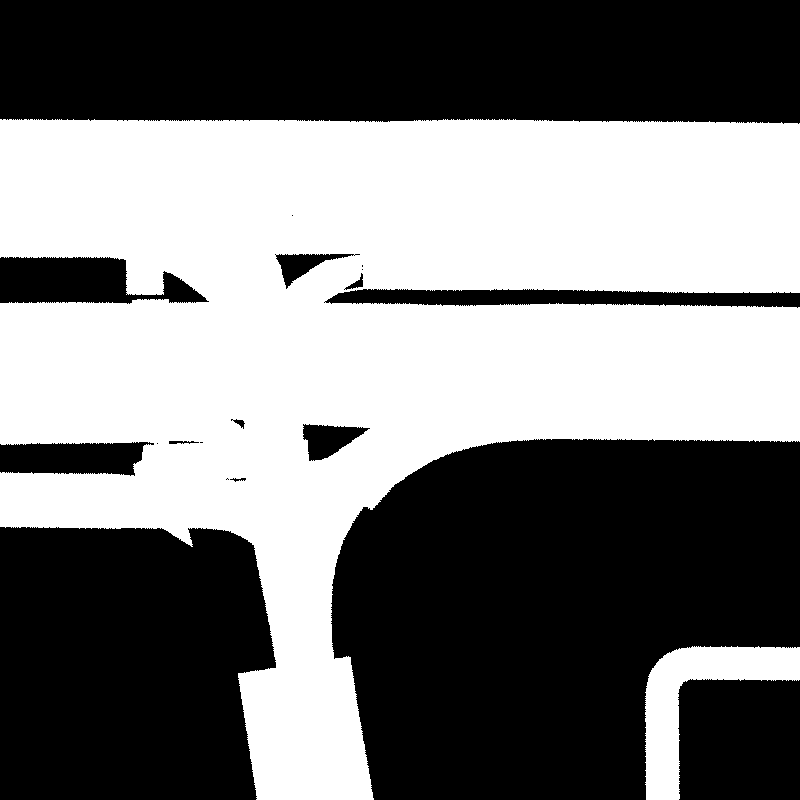

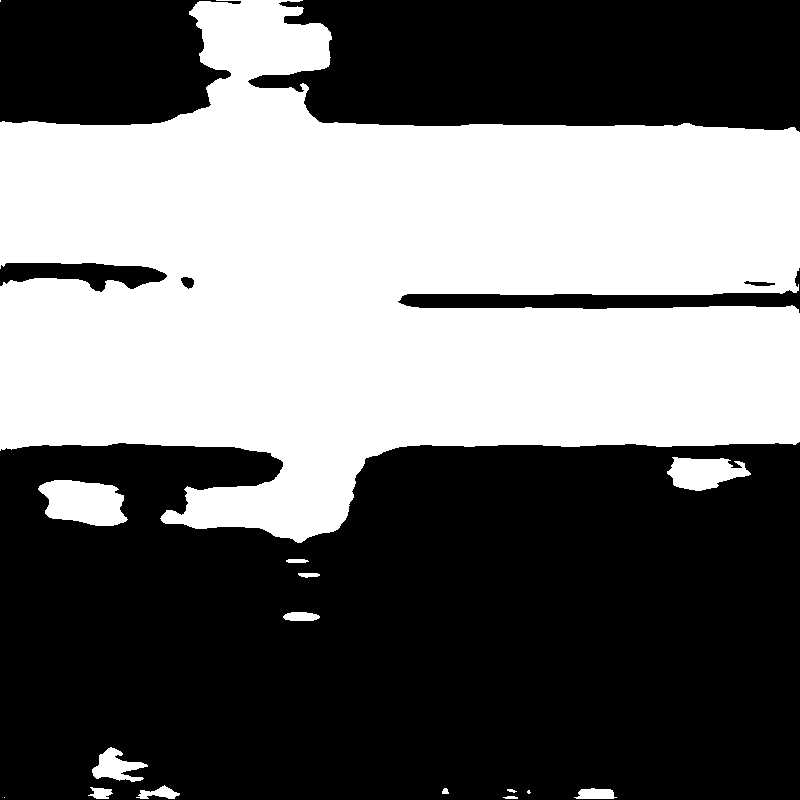

epoch 10, iter 0: 0.07909120619297028
epoch 10, iter 20: 0.04089720919728279
epoch 10, iter 40: 0.07486799359321594
epoch 10, iter 60: 0.05001330375671387
epoch 10, iter 80: 0.045205049216747284
epoch 10, iter 100: 0.05202155560255051
epoch 10, iter 120: 0.0667973980307579
epoch 10, iter 140: 0.0563671737909317
epoch 10, iter 160: 0.04467177763581276
epoch 10, iter 180: 0.05672913044691086
epoch 10, iter 200: 0.04600651562213898
epoch 10, iter 220: 0.06407129019498825
epoch 10, iter 240: 0.0403309091925621
epoch 10, iter 260: 0.06461676210165024
epoch 10, iter 280: 0.07227437943220139
epoch 10, iter 300: 0.05370638146996498
validation epoch 10: 0.0953478068113327


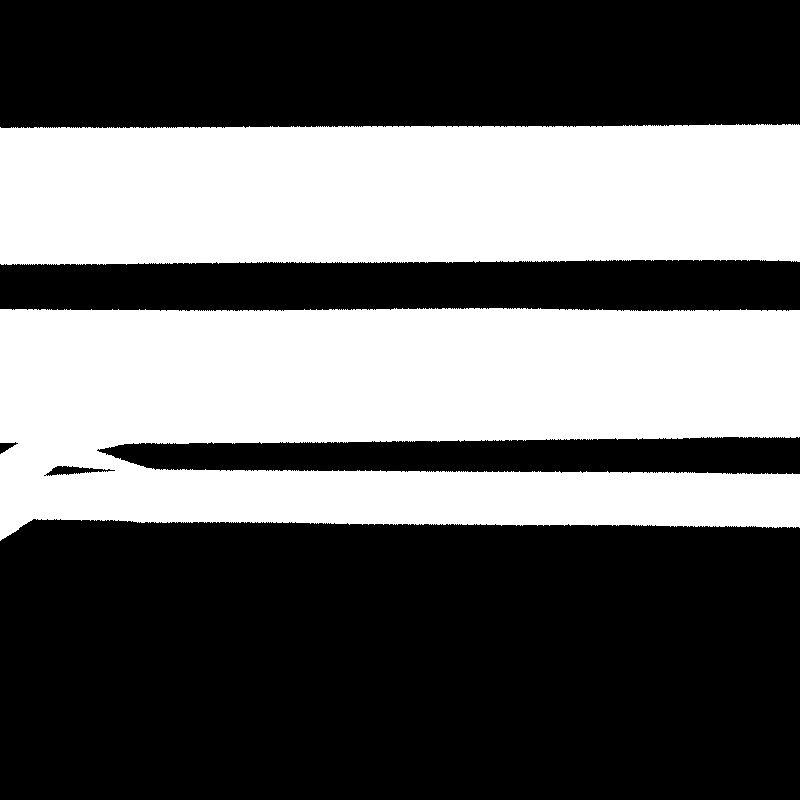

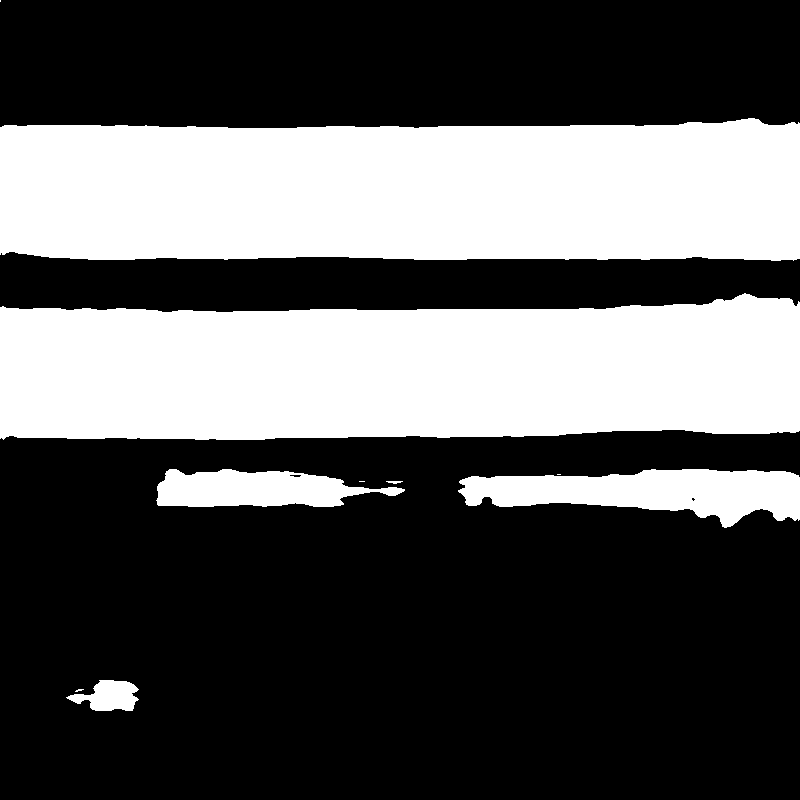

epoch 11, iter 0: 0.05161979794502258
epoch 11, iter 20: 0.049672819674015045
epoch 11, iter 40: 0.05948515981435776
epoch 11, iter 60: 0.06573081016540527
epoch 11, iter 80: 0.041913025081157684
epoch 11, iter 100: 0.057335954159498215
epoch 11, iter 120: 0.04256768152117729
epoch 11, iter 140: 0.06416026502847672
epoch 11, iter 160: 0.06662283092737198
epoch 11, iter 180: 0.06258197873830795
epoch 11, iter 200: 0.045594584196805954
epoch 11, iter 220: 0.05715728551149368
epoch 11, iter 240: 0.06341397017240524
epoch 11, iter 260: 0.053697552531957626
epoch 11, iter 280: 0.050546251237392426
epoch 11, iter 300: 0.05352214351296425
validation epoch 11: 0.08527064323425293


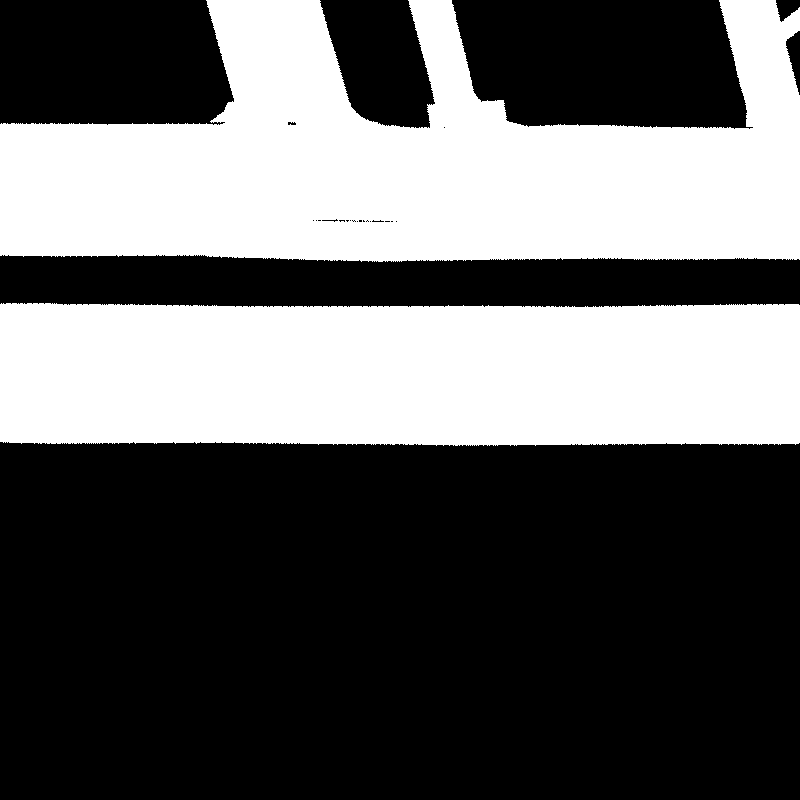

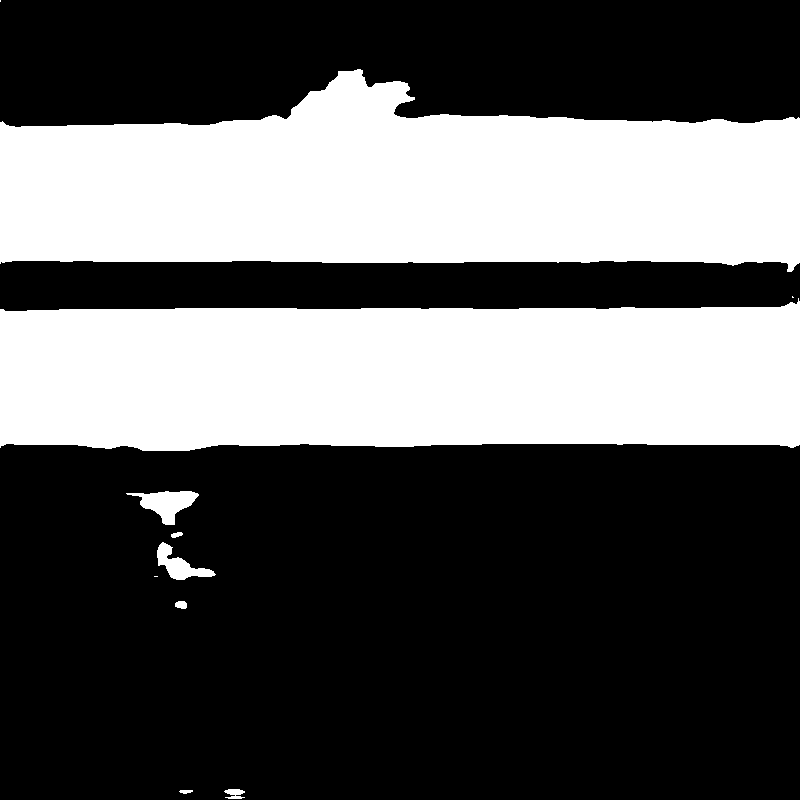

epoch 12, iter 0: 0.06873837113380432
epoch 12, iter 20: 0.0648256242275238
epoch 12, iter 40: 0.04854092374444008
epoch 12, iter 60: 0.05038027837872505
epoch 12, iter 80: 0.034685637801885605
epoch 12, iter 100: 0.04181160032749176
epoch 12, iter 120: 0.039770666509866714
epoch 12, iter 140: 0.0483054481446743
epoch 12, iter 160: 0.033002402633428574
epoch 12, iter 180: 0.031645793467760086
epoch 12, iter 200: 0.038743097335100174
epoch 12, iter 220: 0.03423469141125679
epoch 12, iter 240: 0.04318894445896149
epoch 12, iter 260: 0.052757628262043
epoch 12, iter 280: 0.03911512717604637
epoch 12, iter 300: 0.04874640330672264
validation epoch 12: 0.08428153395652771


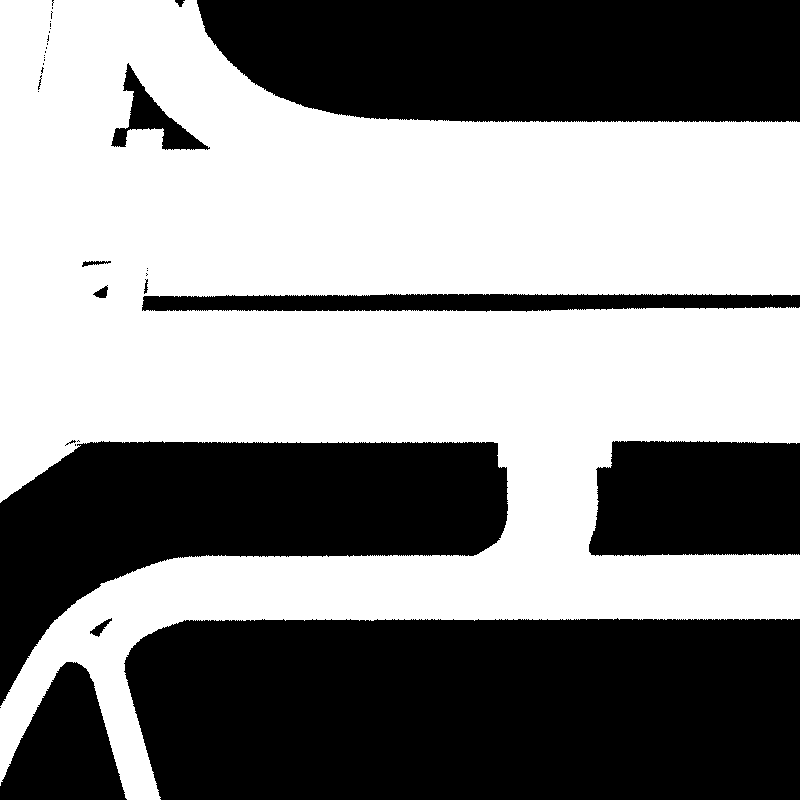

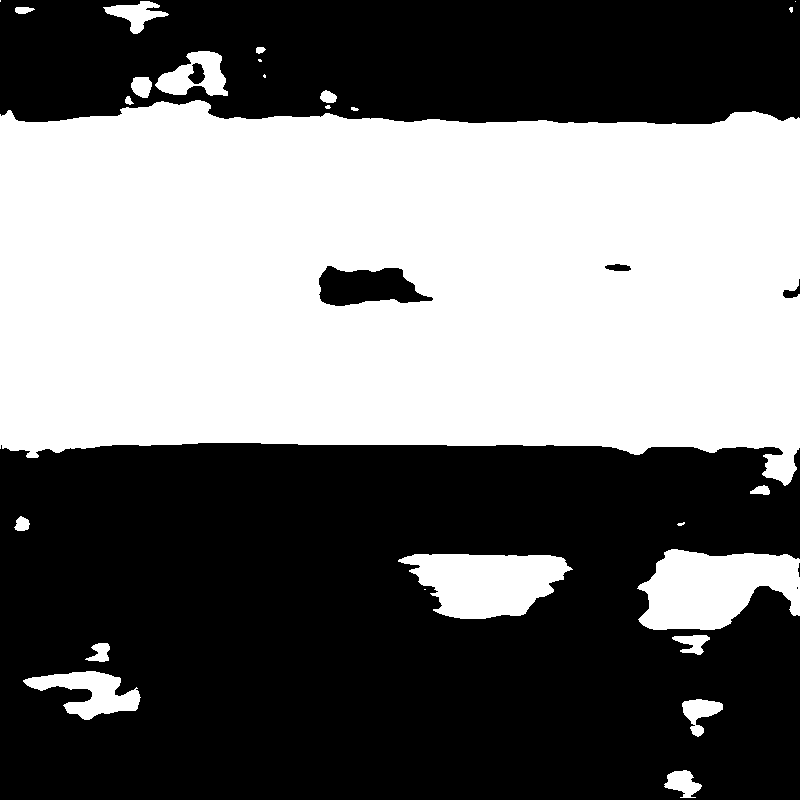

epoch 13, iter 0: 0.04103242605924606
epoch 13, iter 20: 0.054681144654750824
epoch 13, iter 40: 0.02693374827504158
epoch 13, iter 60: 0.049967288970947266
epoch 13, iter 80: 0.038411084562540054
epoch 13, iter 100: 0.03721790388226509
epoch 13, iter 120: 0.044768884778022766
epoch 13, iter 140: 0.04840189591050148
epoch 13, iter 160: 0.04164694622159004
epoch 13, iter 180: 0.03141343221068382
epoch 13, iter 200: 0.0613667331635952
epoch 13, iter 220: 0.06211210787296295
epoch 13, iter 240: 0.04503636434674263
epoch 13, iter 260: 0.05099852755665779
epoch 13, iter 280: 0.05223589390516281
epoch 13, iter 300: 0.04160049185156822
validation epoch 13: 0.08628417551517487


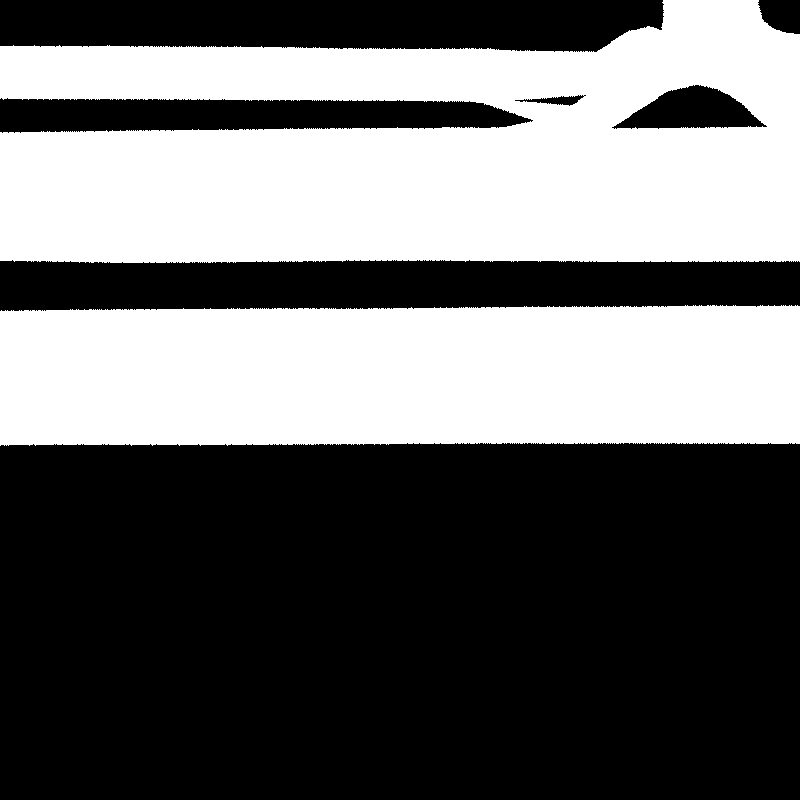

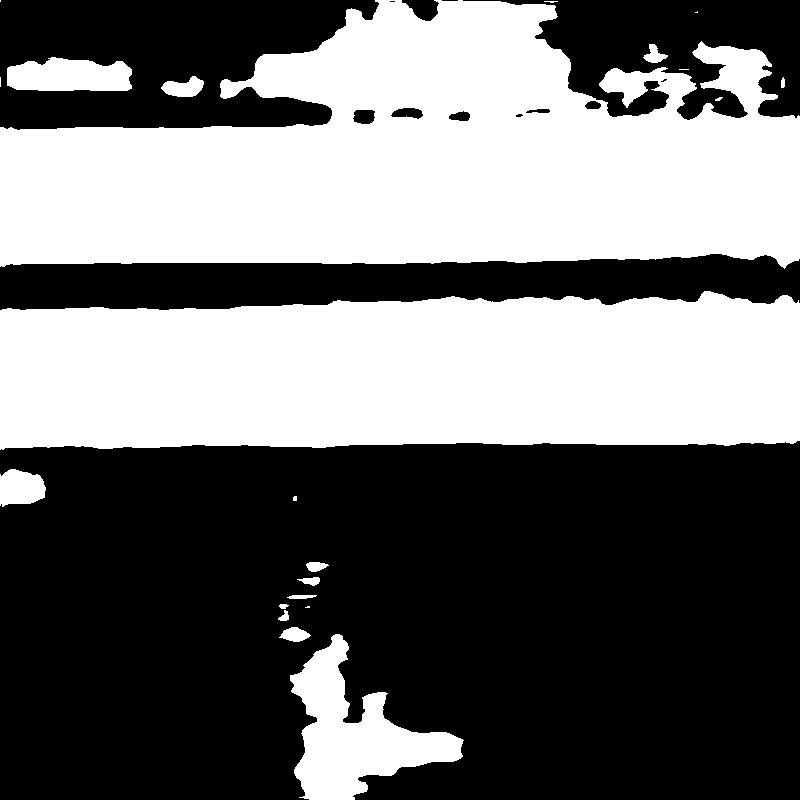

epoch 14, iter 0: 0.057353295385837555
epoch 14, iter 20: 0.045975394546985626
epoch 14, iter 40: 0.06392224878072739
epoch 14, iter 60: 0.03348299488425255
epoch 14, iter 80: 0.03489458188414574
epoch 14, iter 100: 0.03669776767492294
epoch 14, iter 120: 0.03463474661111832
epoch 14, iter 140: 0.045652102679014206
epoch 14, iter 160: 0.0379924438893795
epoch 14, iter 180: 0.039410870522260666
epoch 14, iter 200: 0.04985399916768074
epoch 14, iter 220: 0.04176381230354309
epoch 14, iter 240: 0.05718601495027542
epoch 14, iter 260: 0.0609048455953598
epoch 14, iter 280: 0.04312435910105705
epoch 14, iter 300: 0.04607648029923439
validation epoch 14: 0.08788517862558365


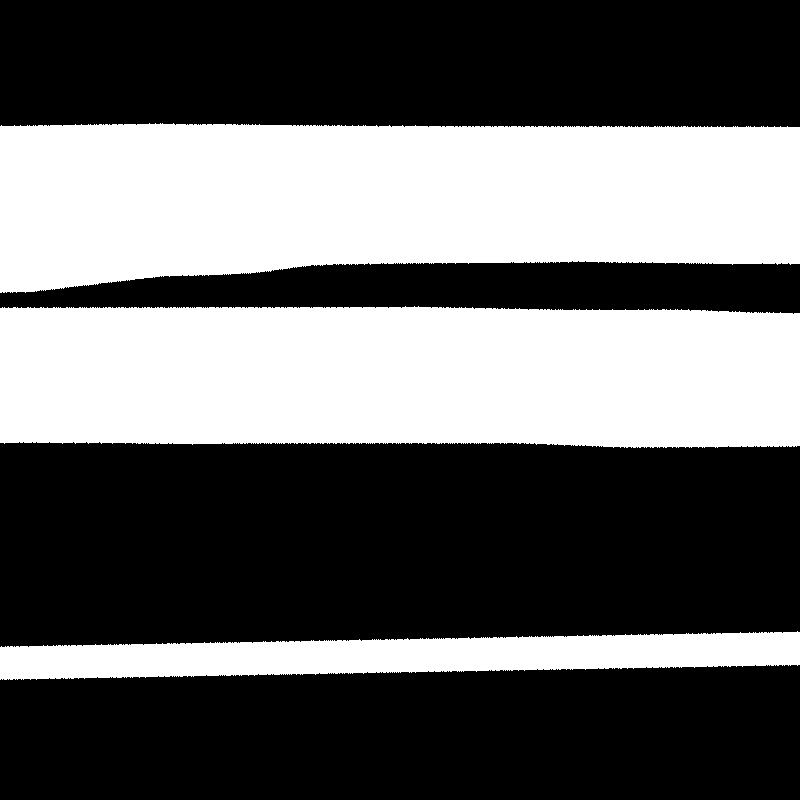

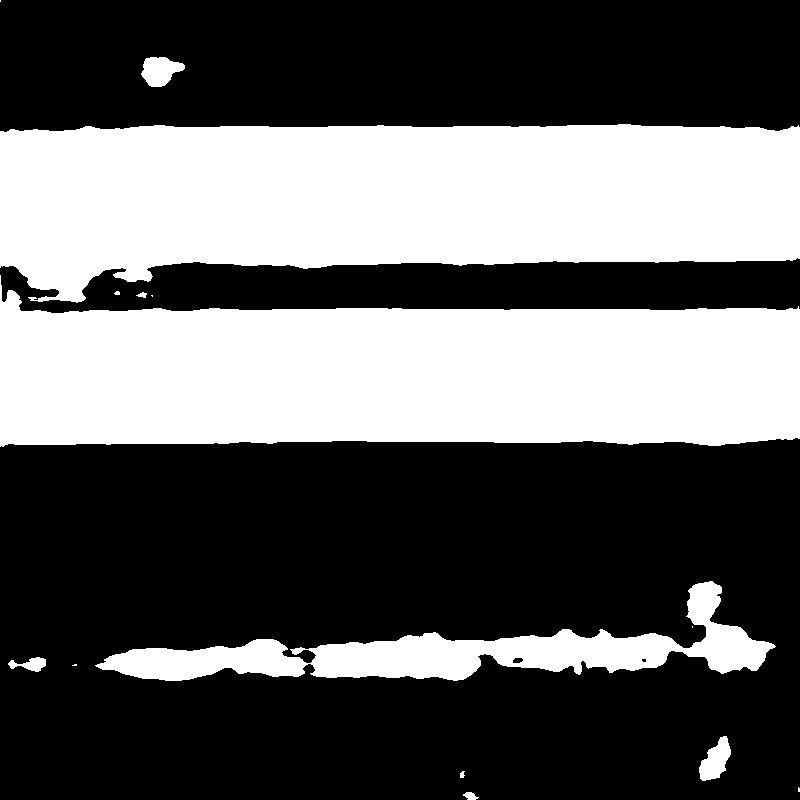

epoch 15, iter 0: 0.03585777059197426
epoch 15, iter 20: 0.037185996770858765
epoch 15, iter 40: 0.05400829762220383
epoch 15, iter 60: 0.04199755936861038
epoch 15, iter 80: 0.05026031285524368
epoch 15, iter 100: 0.040056854486465454
epoch 15, iter 120: 0.04758844152092934
epoch 15, iter 140: 0.048909153789281845
epoch 15, iter 160: 0.033021289855241776
epoch 15, iter 180: 0.0284574031829834
epoch 15, iter 200: 0.051201336085796356
epoch 15, iter 220: 0.04589833691716194
epoch 15, iter 240: 0.03349754214286804
epoch 15, iter 260: 0.028328057378530502
epoch 15, iter 280: 0.05016656965017319
epoch 15, iter 300: 0.0350898914039135
validation epoch 15: 0.0872979611158371


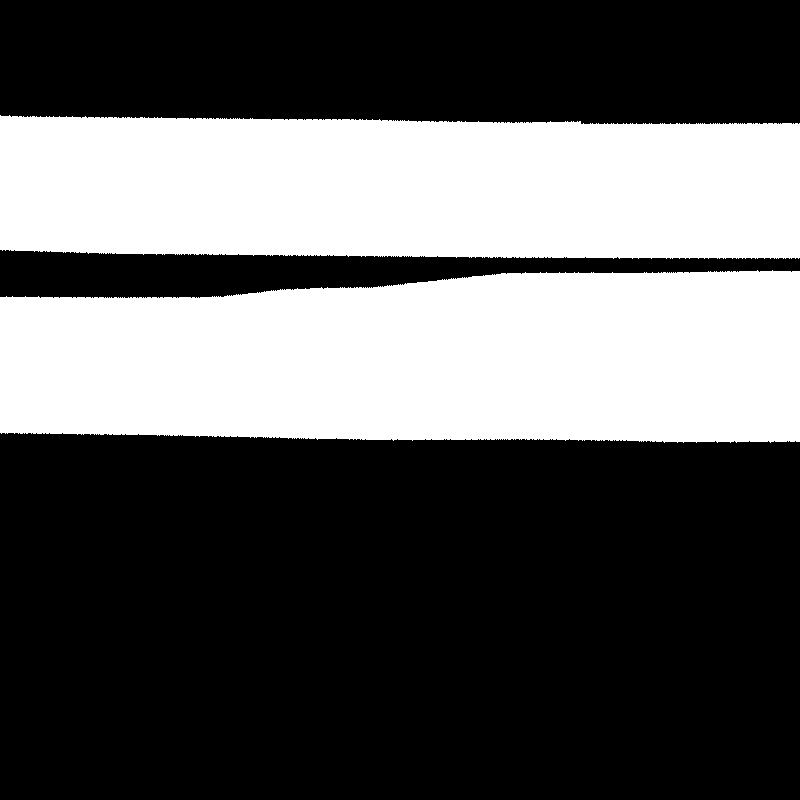

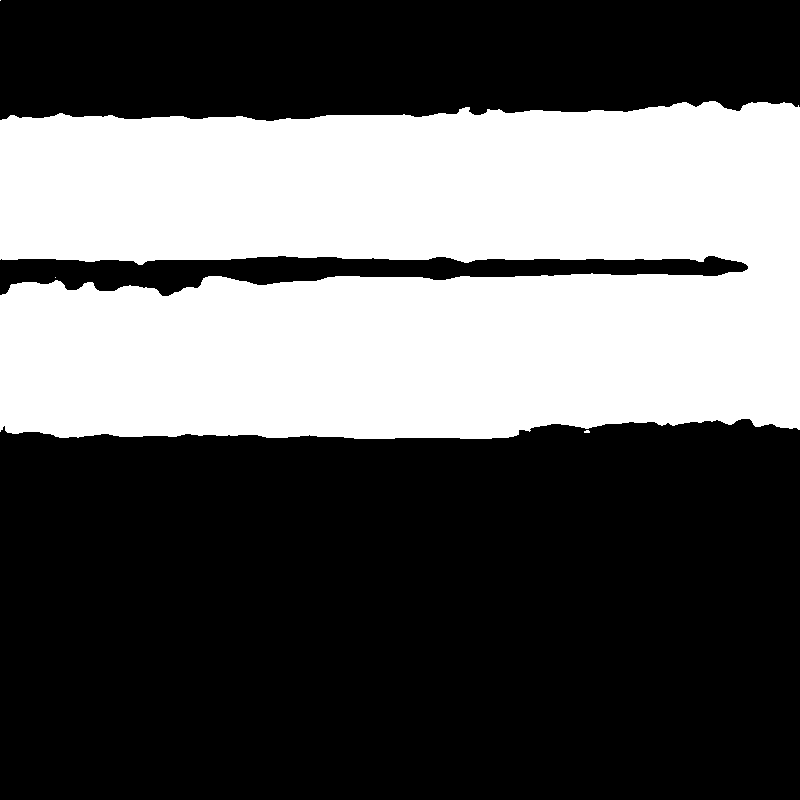

epoch 16, iter 0: 0.04086229205131531
epoch 16, iter 20: 0.04803294688463211
epoch 16, iter 40: 0.02837279811501503
epoch 16, iter 60: 0.05073154345154762
epoch 16, iter 80: 0.03567822650074959
epoch 16, iter 100: 0.03201273828744888
epoch 16, iter 120: 0.028876714408397675
epoch 16, iter 140: 0.04406856745481491
epoch 16, iter 160: 0.05028359964489937
epoch 16, iter 180: 0.03220370411872864
epoch 16, iter 200: 0.022664781659841537
epoch 16, iter 220: 0.04046531394124031
epoch 16, iter 240: 0.046287260949611664
epoch 16, iter 260: 0.06528828293085098
epoch 16, iter 280: 0.037040501832962036
epoch 16, iter 300: 0.034137602895498276
validation epoch 16: 0.08758921921253204


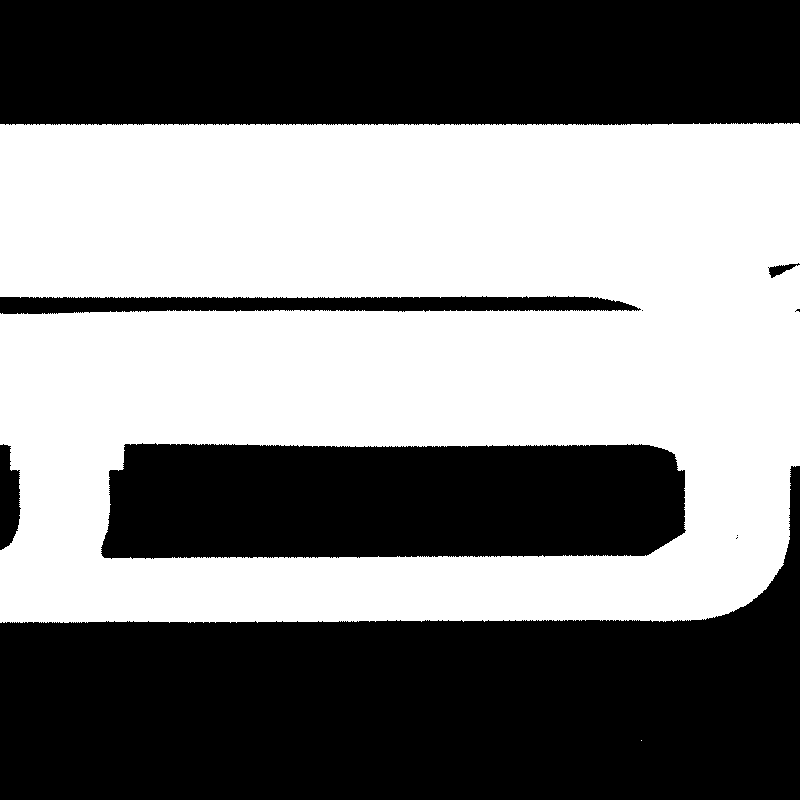

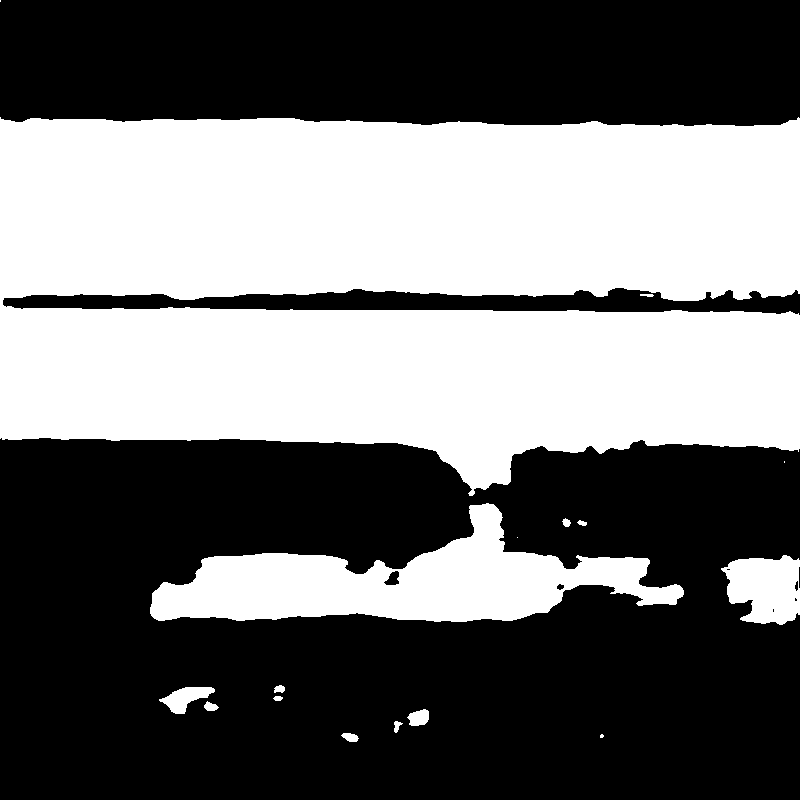

epoch 17, iter 0: 0.0273442342877388
epoch 17, iter 20: 0.04277440160512924
epoch 17, iter 40: 0.03765014186501503
epoch 17, iter 60: 0.04421320930123329
epoch 17, iter 80: 0.04876646026968956
epoch 17, iter 100: 0.03901892155408859
epoch 17, iter 120: 0.037157103419303894
epoch 17, iter 140: 0.03616473451256752
epoch 17, iter 160: 0.043382953852415085
epoch 17, iter 180: 0.029996218159794807
epoch 17, iter 200: 0.03987932950258255
epoch 17, iter 220: 0.03324279189109802
epoch 17, iter 240: 0.027863549068570137
epoch 17, iter 260: 0.03738788142800331
epoch 17, iter 280: 0.036357320845127106
epoch 17, iter 300: 0.026112329214811325
validation epoch 17: 0.0899631530046463


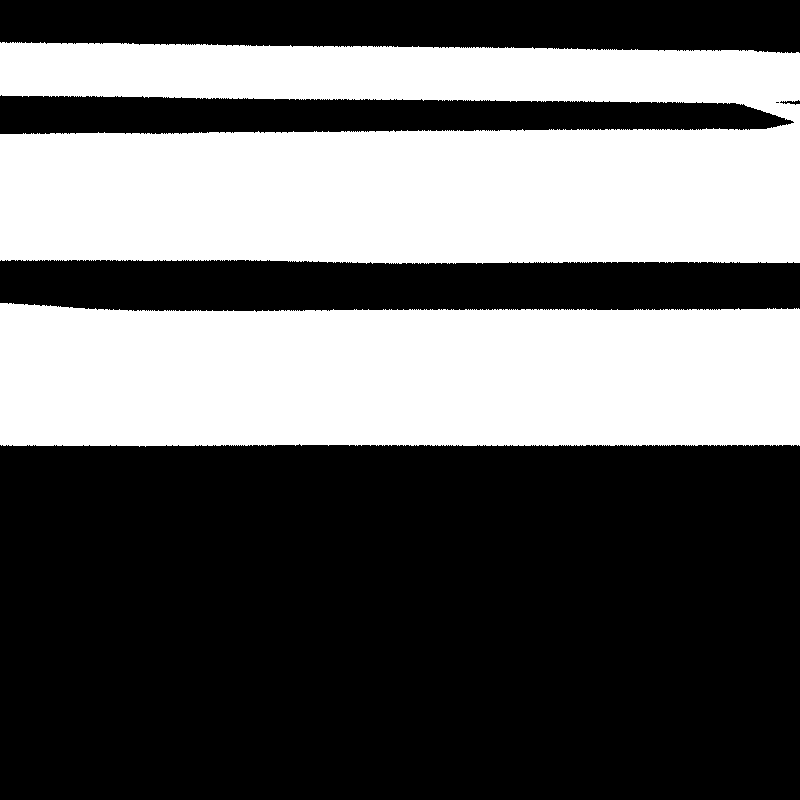

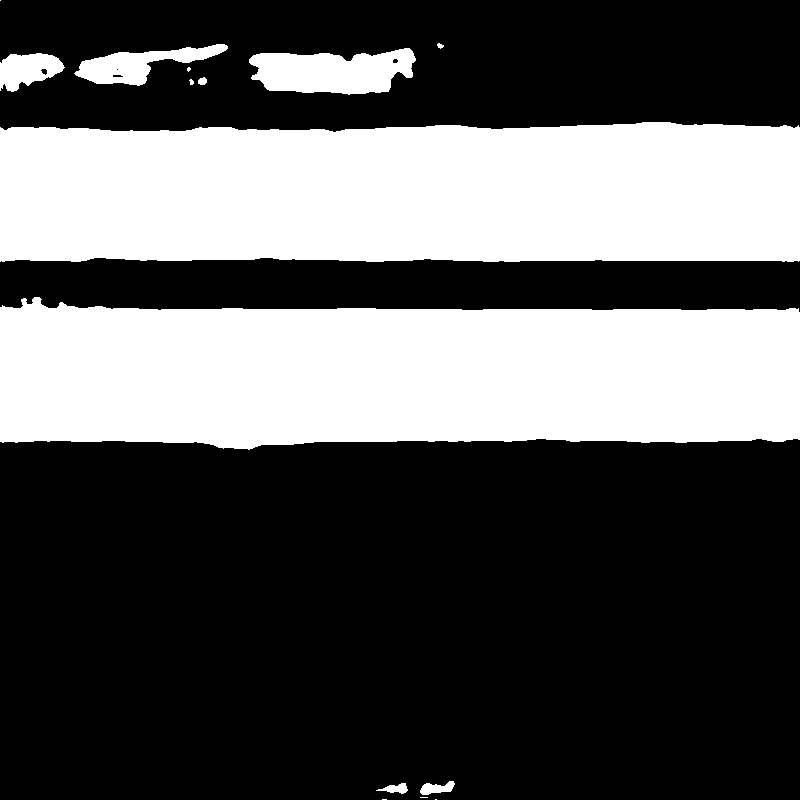

epoch 18, iter 0: 0.028443718329072
epoch 18, iter 20: 0.021818973124027252
epoch 18, iter 40: 0.0360419824719429
epoch 18, iter 60: 0.03239867463707924
epoch 18, iter 80: 0.033100396394729614
epoch 18, iter 100: 0.032279618084430695
epoch 18, iter 120: 0.02035750448703766
epoch 18, iter 140: 0.030555611476302147
epoch 18, iter 160: 0.03826383501291275
epoch 18, iter 180: 0.038533397018909454
epoch 18, iter 200: 0.034803833812475204
epoch 18, iter 220: 0.04802900180220604
epoch 18, iter 240: 0.04851154610514641
epoch 18, iter 260: 0.03350301831960678
epoch 18, iter 280: 0.041765958070755005
epoch 18, iter 300: 0.033168863505125046
validation epoch 18: 0.08969274163246155


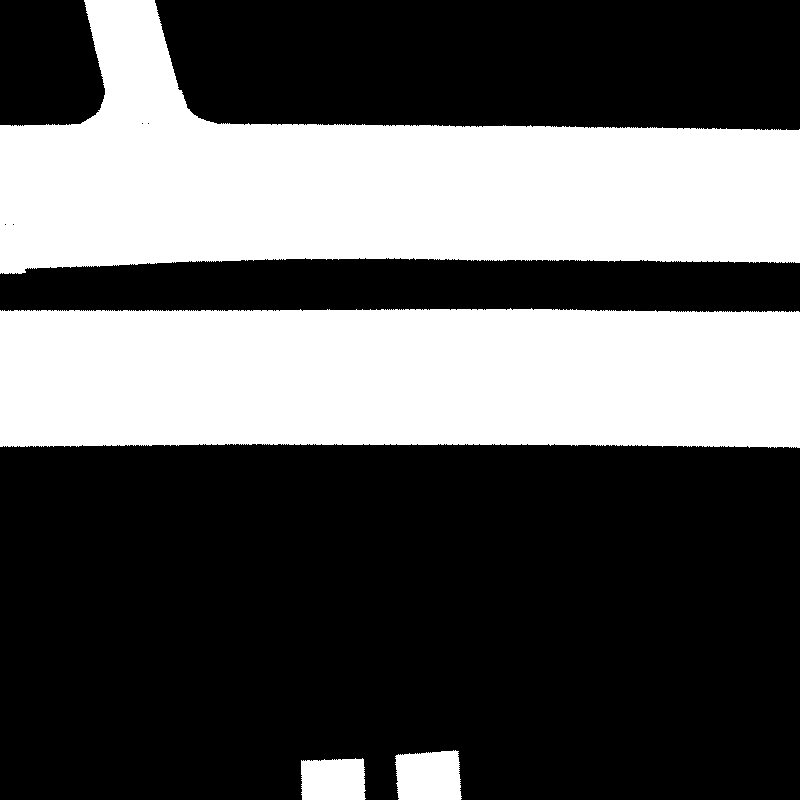

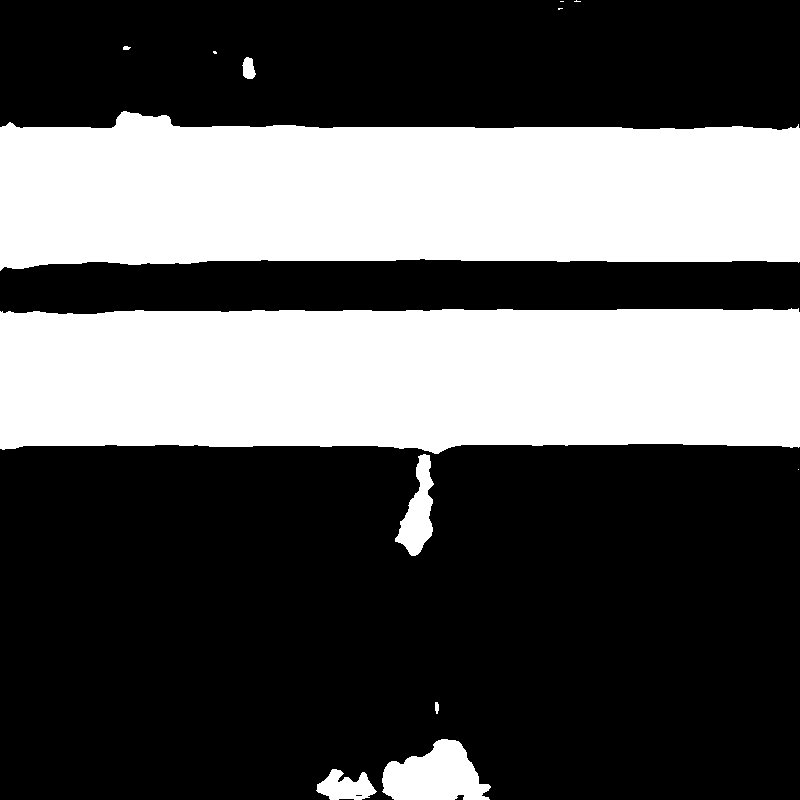

epoch 19, iter 0: 0.03292587399482727
epoch 19, iter 20: 0.02942255139350891
epoch 19, iter 40: 0.034597594290971756
epoch 19, iter 60: 0.03237195685505867
epoch 19, iter 80: 0.02785268798470497
epoch 19, iter 100: 0.03471766412258148
epoch 19, iter 120: 0.0327000692486763
epoch 19, iter 140: 0.019559085369110107
epoch 19, iter 160: 0.03825537860393524
epoch 19, iter 180: 0.03020014613866806
epoch 19, iter 200: 0.03843678534030914
epoch 19, iter 220: 0.027478734031319618
epoch 19, iter 240: 0.037283118814229965
epoch 19, iter 260: 0.03321623429656029
epoch 19, iter 280: 0.030875109136104584
epoch 19, iter 300: 0.03079836070537567
validation epoch 19: 0.08616960793733597


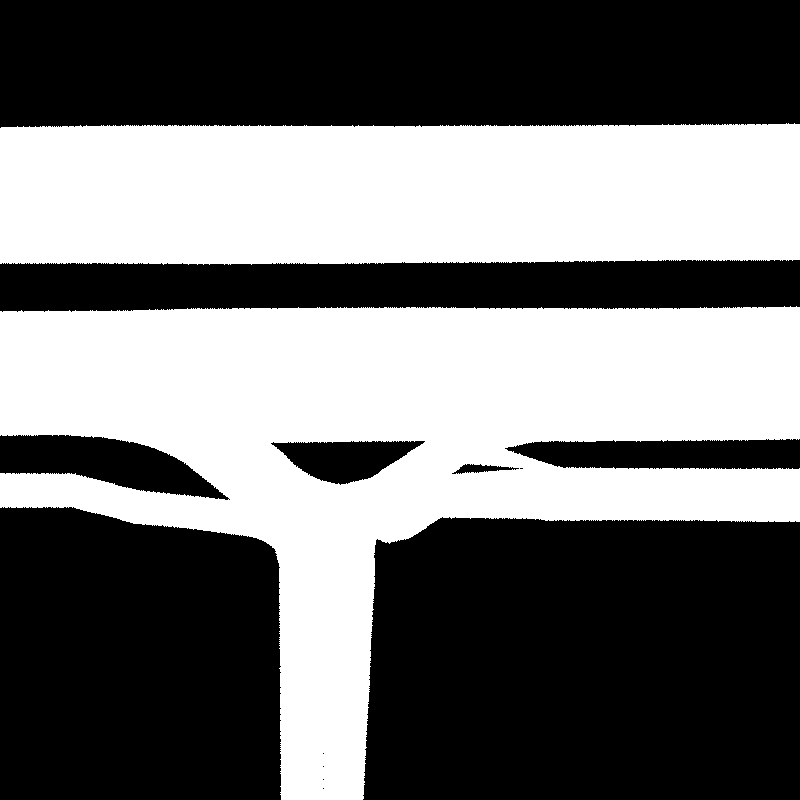

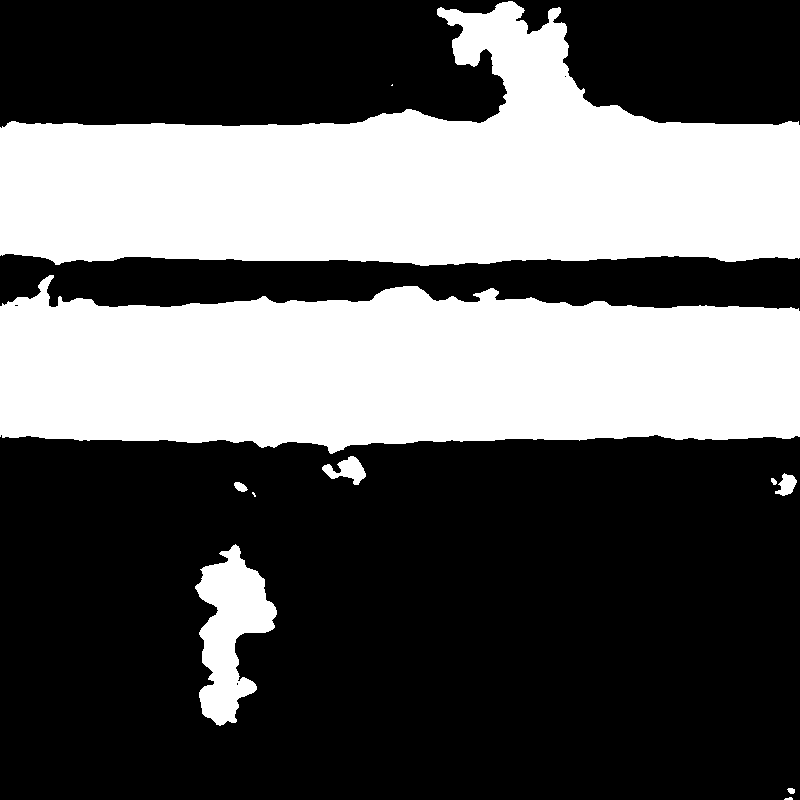

epoch 20, iter 0: 0.02606881409883499
epoch 20, iter 20: 0.03232989460229874
epoch 20, iter 40: 0.020763413980603218
epoch 20, iter 60: 0.03680630773305893
epoch 20, iter 80: 0.03942195326089859
epoch 20, iter 100: 0.04296481981873512
epoch 20, iter 120: 0.03380710631608963
epoch 20, iter 140: 0.027361150830984116
epoch 20, iter 160: 0.02439688704907894
epoch 20, iter 180: 0.03614020720124245
epoch 20, iter 200: 0.0377432256937027
epoch 20, iter 220: 0.039308760315179825
epoch 20, iter 240: 0.028765343129634857
epoch 20, iter 260: 0.02430219203233719
epoch 20, iter 280: 0.029707299545407295
epoch 20, iter 300: 0.031669605523347855
validation epoch 20: 0.08432502299547195


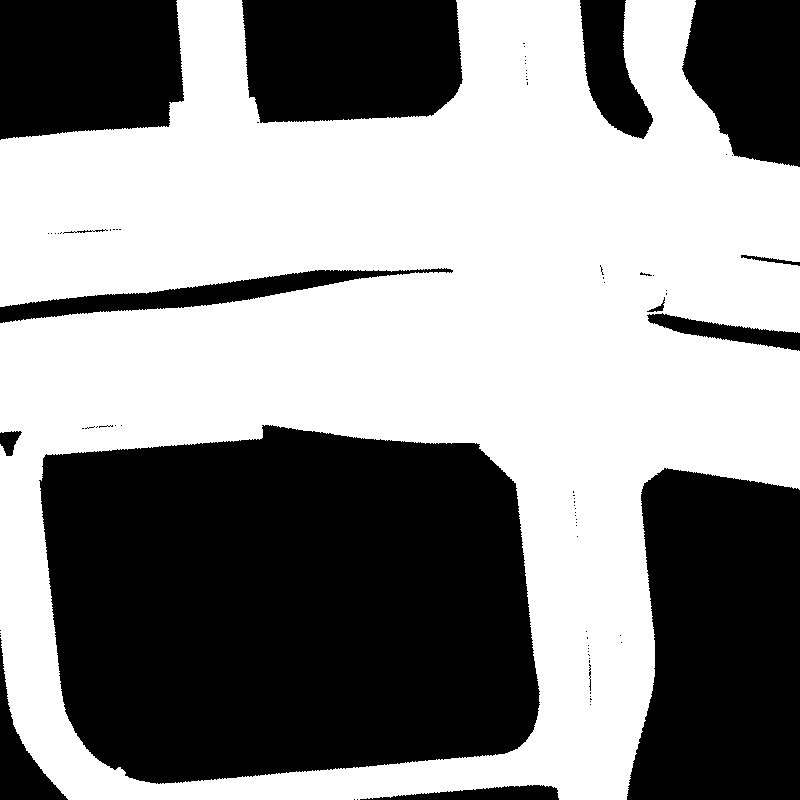

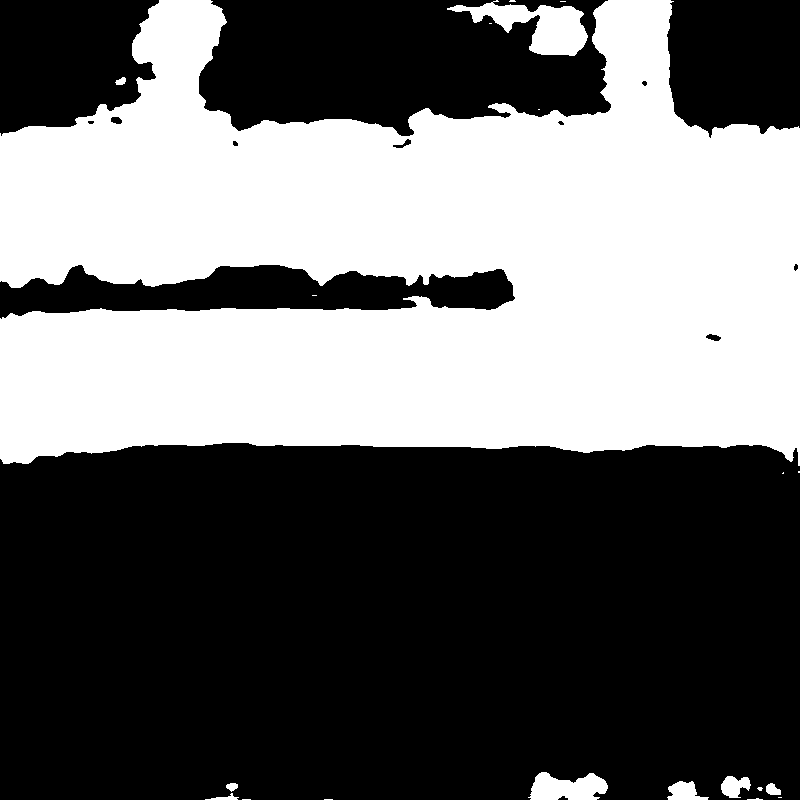

epoch 21, iter 0: 0.04020608589053154
epoch 21, iter 20: 0.04194759204983711
epoch 21, iter 40: 0.02635982073843479
epoch 21, iter 60: 0.03360071778297424
epoch 21, iter 80: 0.04223467782139778
epoch 21, iter 100: 0.035965949296951294
epoch 21, iter 120: 0.03422072157263756
epoch 21, iter 140: 0.027456313371658325
epoch 21, iter 160: 0.03536047413945198
epoch 21, iter 180: 0.02999000810086727
epoch 21, iter 200: 0.026081042364239693
epoch 21, iter 220: 0.02976284734904766
epoch 21, iter 240: 0.04519173875451088
epoch 21, iter 260: 0.0221161600202322
epoch 21, iter 280: 0.0301353819668293
epoch 21, iter 300: 0.026661450043320656
validation epoch 21: 0.08393111079931259


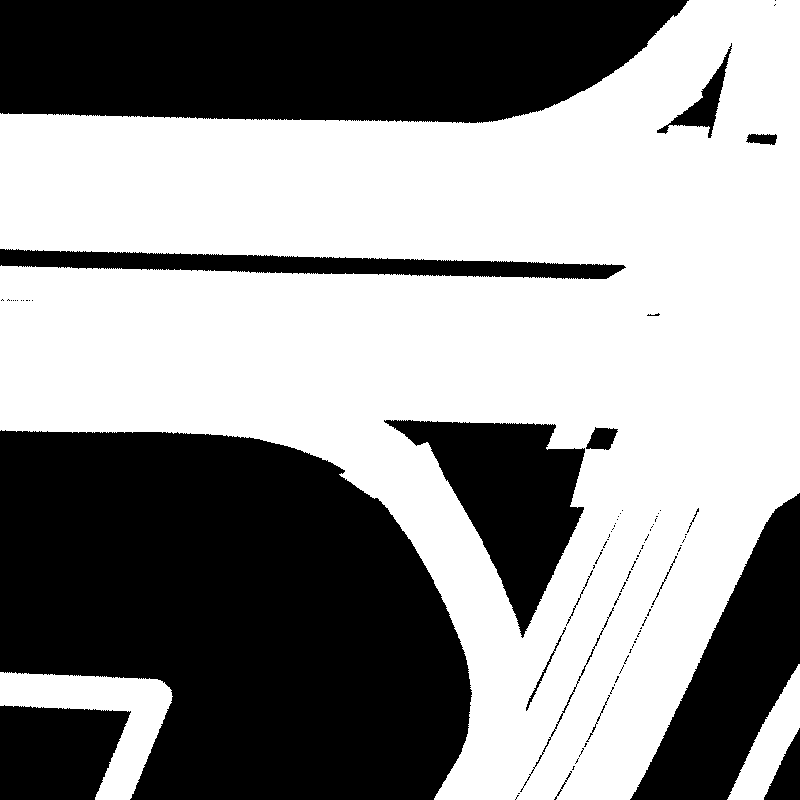

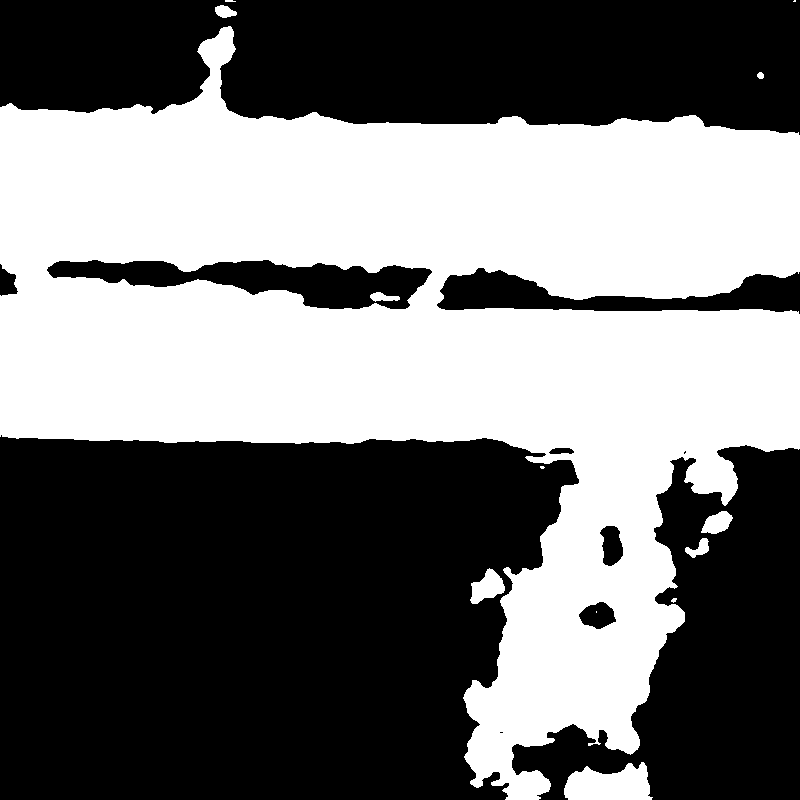

epoch 22, iter 0: 0.020763009786605835
epoch 22, iter 20: 0.02053143084049225
epoch 22, iter 40: 0.02515799179673195
epoch 22, iter 60: 0.03149633854627609
epoch 22, iter 80: 0.0377921424806118
epoch 22, iter 100: 0.03756320849061012
epoch 22, iter 120: 0.03487837314605713
epoch 22, iter 140: 0.02538333646953106
epoch 22, iter 160: 0.02223273180425167
epoch 22, iter 180: 0.037263914942741394
epoch 22, iter 200: 0.024561982601881027
epoch 22, iter 220: 0.0287153460085392
epoch 22, iter 240: 0.02750599943101406
epoch 22, iter 260: 0.04793664067983627
epoch 22, iter 280: 0.02829916402697563
epoch 22, iter 300: 0.03147462382912636
validation epoch 22: 0.08833224326372147


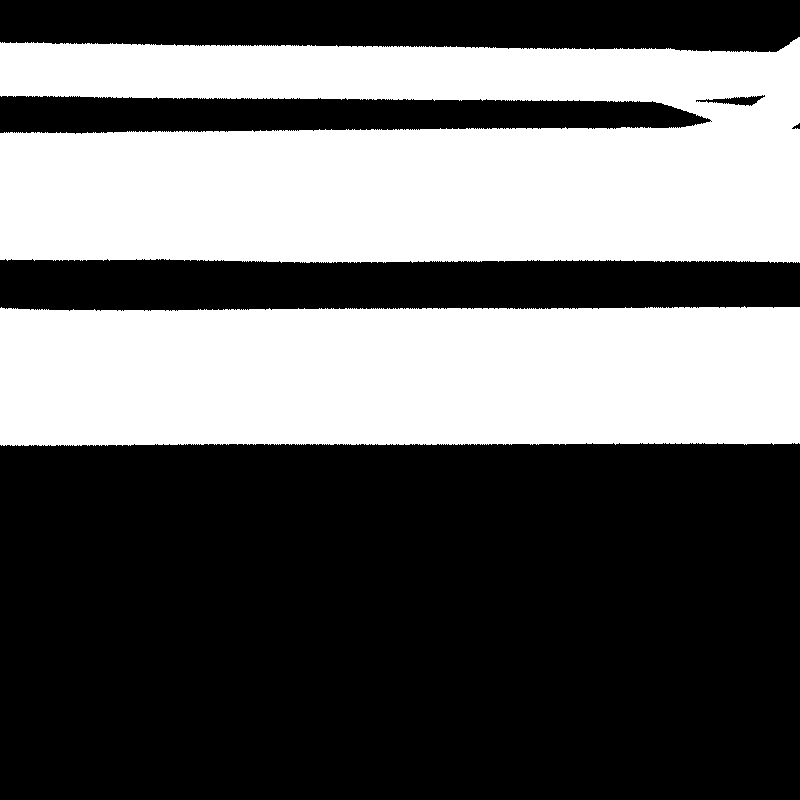

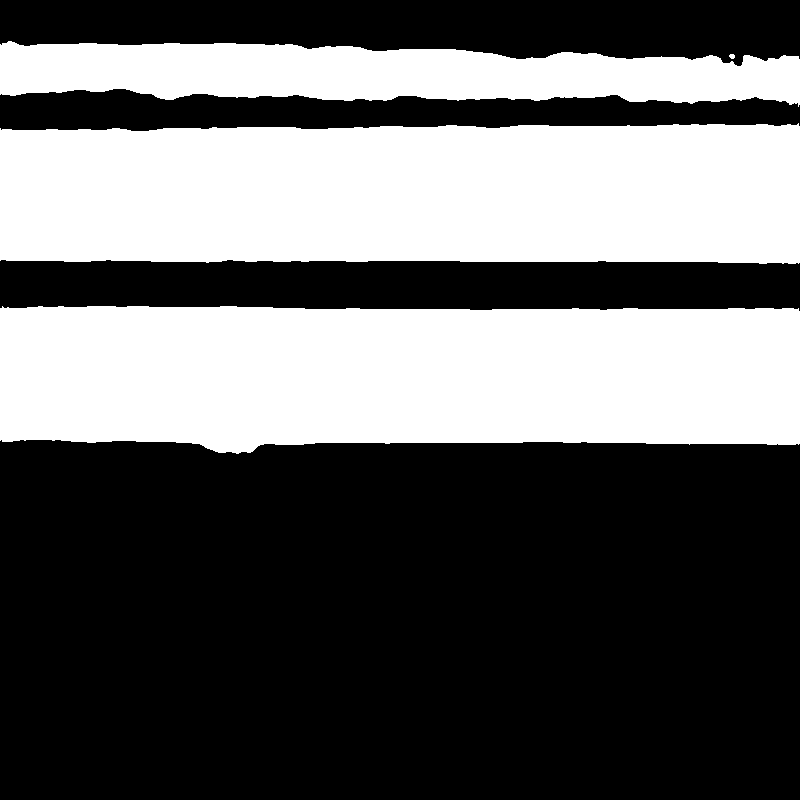

epoch 23, iter 0: 0.025926413014531136
epoch 23, iter 20: 0.03914031758904457
epoch 23, iter 40: 0.030523013323545456
epoch 23, iter 60: 0.02575918473303318
epoch 23, iter 80: 0.026569902896881104
epoch 23, iter 100: 0.02615216001868248
epoch 23, iter 120: 0.03183703497052193
epoch 23, iter 140: 0.04484213888645172
epoch 23, iter 160: 0.026654724031686783
epoch 23, iter 180: 0.03190059959888458
epoch 23, iter 200: 0.04713616147637367
epoch 23, iter 220: 0.030282407999038696
epoch 23, iter 240: 0.025096498429775238
epoch 23, iter 260: 0.019291119650006294
epoch 23, iter 280: 0.019015802070498466
epoch 23, iter 300: 0.021727509796619415
validation epoch 23: 0.08664008229970932


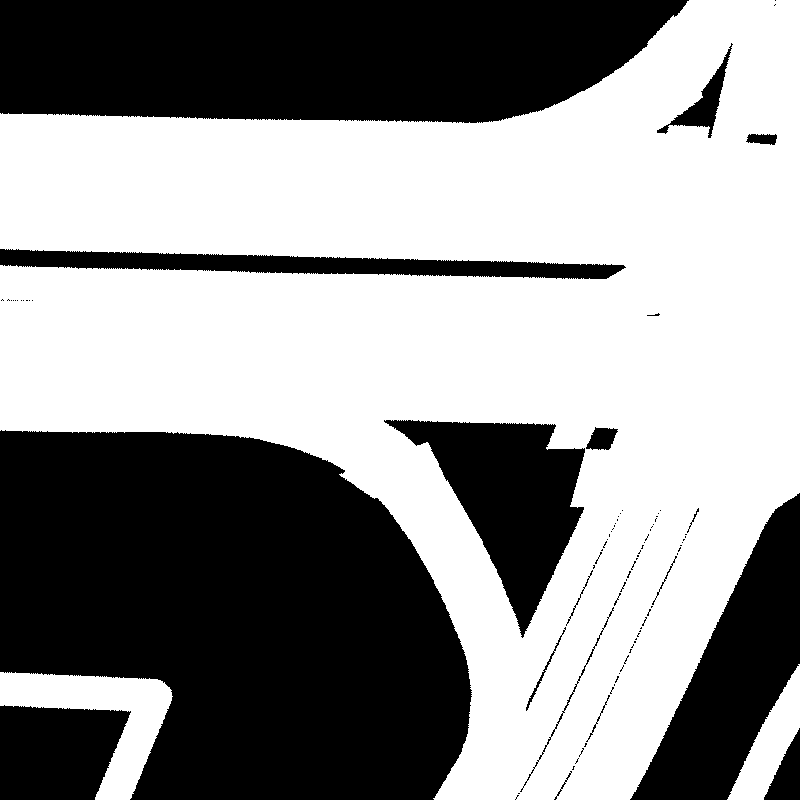

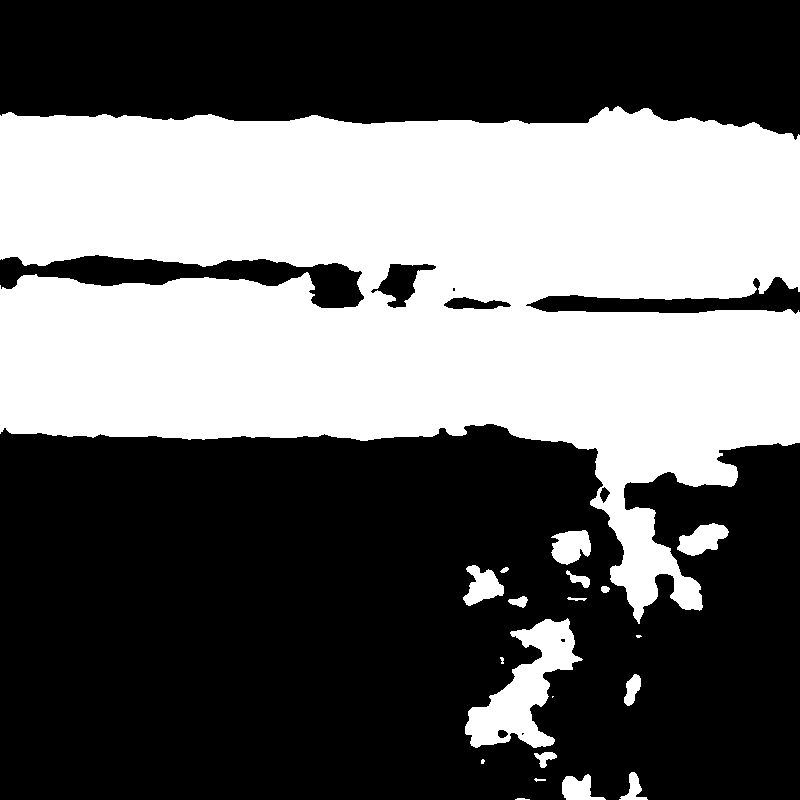

epoch 24, iter 0: 0.012540668249130249
epoch 24, iter 20: 0.03295939415693283
epoch 24, iter 40: 0.018831320106983185
epoch 24, iter 60: 0.030686013400554657
epoch 24, iter 80: 0.027705419808626175
epoch 24, iter 100: 0.019428294152021408
epoch 24, iter 120: 0.027966231107711792
epoch 24, iter 140: 0.024705272167921066
epoch 24, iter 160: 0.028551476076245308
epoch 24, iter 180: 0.030536137521266937
epoch 24, iter 200: 0.026880333200097084
epoch 24, iter 220: 0.028082216158509254
epoch 24, iter 240: 0.031288992613554
epoch 24, iter 260: 0.021824322640895844
epoch 24, iter 280: 0.02941714972257614
epoch 24, iter 300: 0.0335940420627594
validation epoch 24: 0.08697150647640228


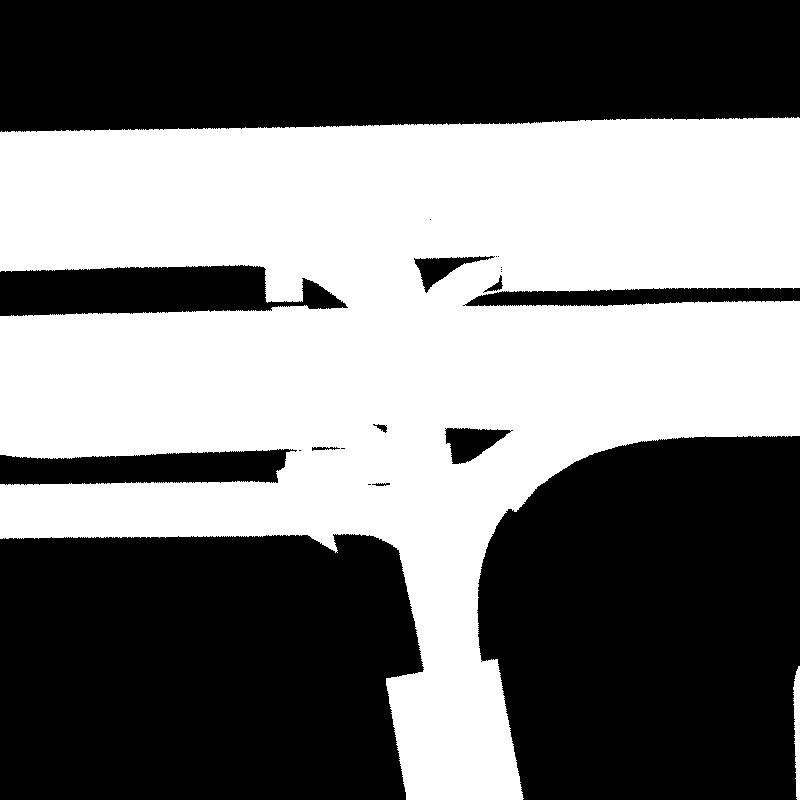

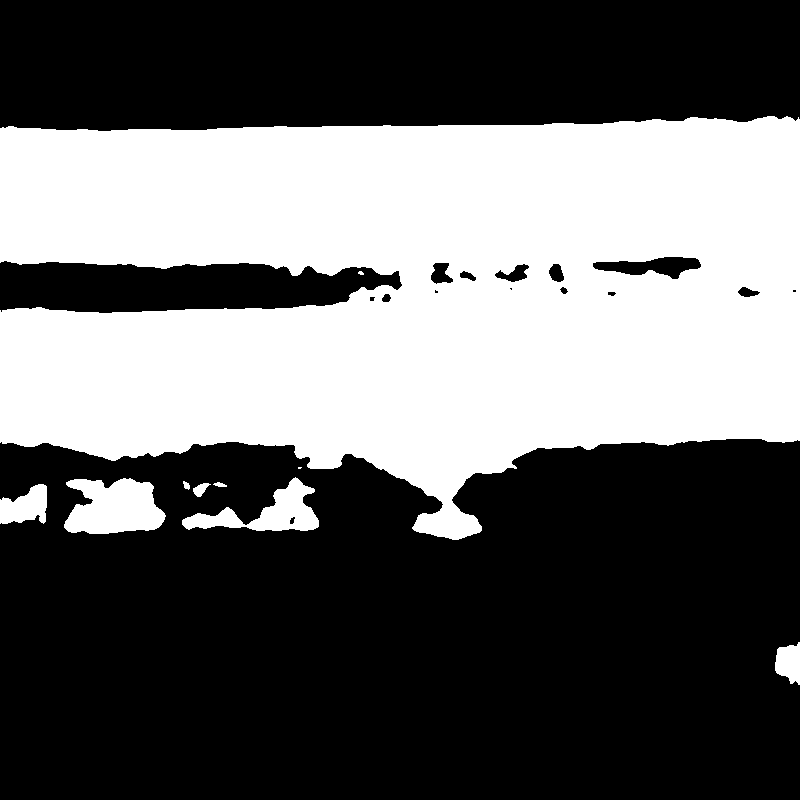

epoch 25, iter 0: 0.027671562507748604
epoch 25, iter 20: 0.019467057660222054
epoch 25, iter 40: 0.02887045592069626
epoch 25, iter 60: 0.022861899808049202
epoch 25, iter 80: 0.02510705403983593
epoch 25, iter 100: 0.03115377388894558
epoch 25, iter 120: 0.018003318458795547
epoch 25, iter 140: 0.025214139372110367
epoch 25, iter 160: 0.03299304097890854
epoch 25, iter 180: 0.024790648370981216
epoch 25, iter 200: 0.026561373844742775
epoch 25, iter 220: 0.026870526373386383
epoch 25, iter 240: 0.02430316060781479
epoch 25, iter 260: 0.025830598548054695
epoch 25, iter 280: 0.035000745207071304
epoch 25, iter 300: 0.02488980069756508
validation epoch 25: 0.09017804265022278


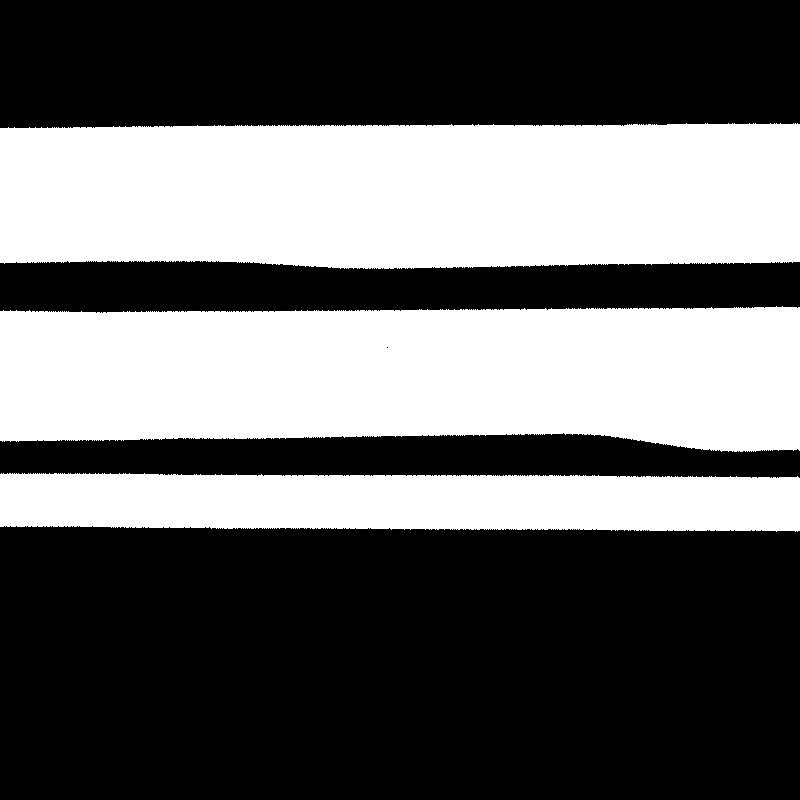

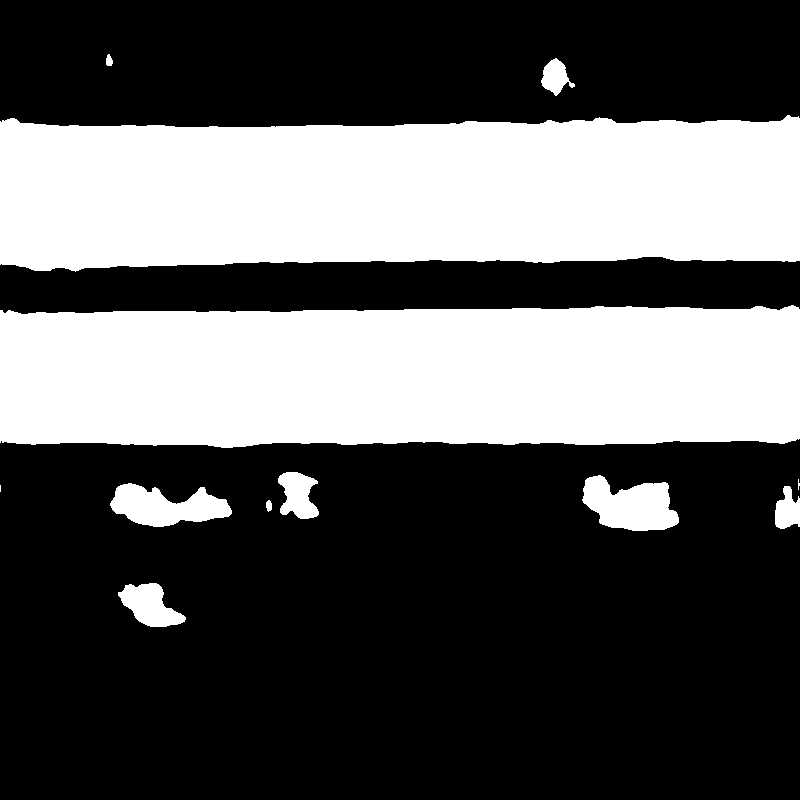

epoch 26, iter 0: 0.025585124269127846
epoch 26, iter 20: 0.019168389961123466
epoch 26, iter 40: 0.02600153721868992
epoch 26, iter 60: 0.014026226475834846
epoch 26, iter 80: 0.026161836460232735
epoch 26, iter 100: 0.020688626915216446
epoch 26, iter 120: 0.025090893730521202
epoch 26, iter 140: 0.021482763811945915
epoch 26, iter 160: 0.02533622458577156
epoch 26, iter 180: 0.02587711811065674
epoch 26, iter 200: 0.03011130355298519
epoch 26, iter 220: 0.025906676426529884
epoch 26, iter 240: 0.0273874681442976
epoch 26, iter 260: 0.019745079800486565
epoch 26, iter 280: 0.023228375241160393
epoch 26, iter 300: 0.019455276429653168
validation epoch 26: 0.0889950543642044


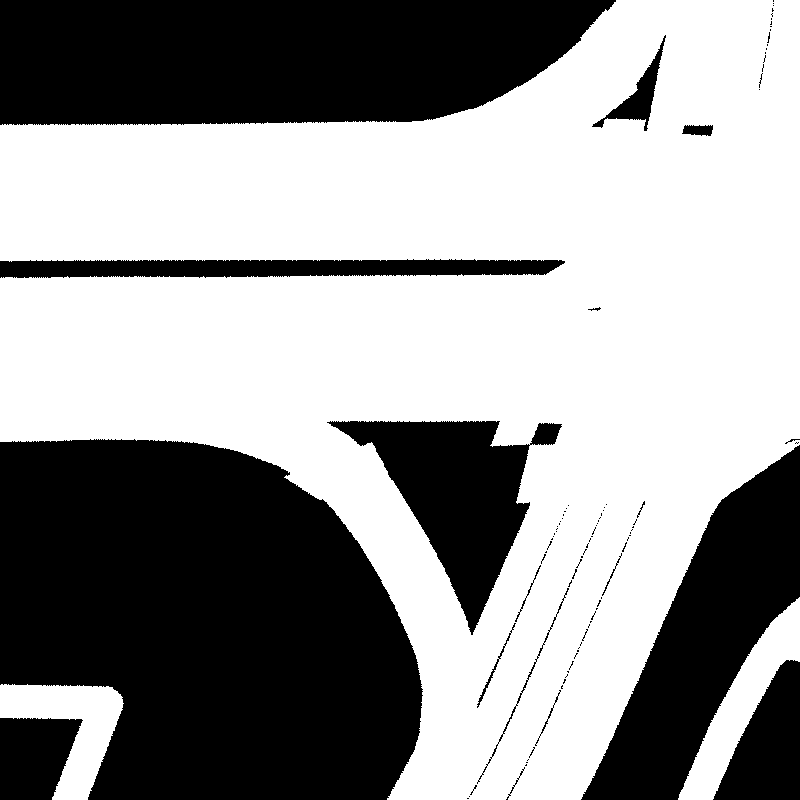

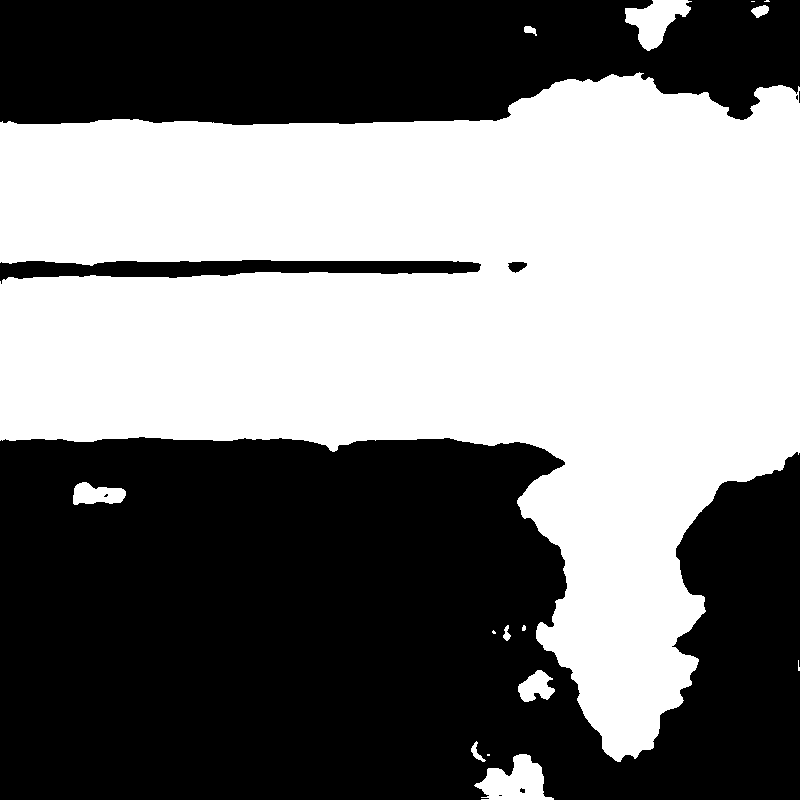

epoch 27, iter 0: 0.02671331726014614
epoch 27, iter 20: 0.018590861931443214
epoch 27, iter 40: 0.028389636427164078
epoch 27, iter 60: 0.018761442974209785
epoch 27, iter 80: 0.017410453408956528
epoch 27, iter 100: 0.020033519715070724
epoch 27, iter 120: 0.025304751470685005
epoch 27, iter 140: 0.02283373661339283
epoch 27, iter 160: 0.02459223009645939
epoch 27, iter 180: 0.02528558298945427
epoch 27, iter 200: 0.026049327105283737
epoch 27, iter 220: 0.022679349407553673
epoch 27, iter 240: 0.027041131630539894
epoch 27, iter 260: 0.027232220396399498
epoch 27, iter 280: 0.02411716617643833
epoch 27, iter 300: 0.020845549181103706
validation epoch 27: 0.08916890621185303


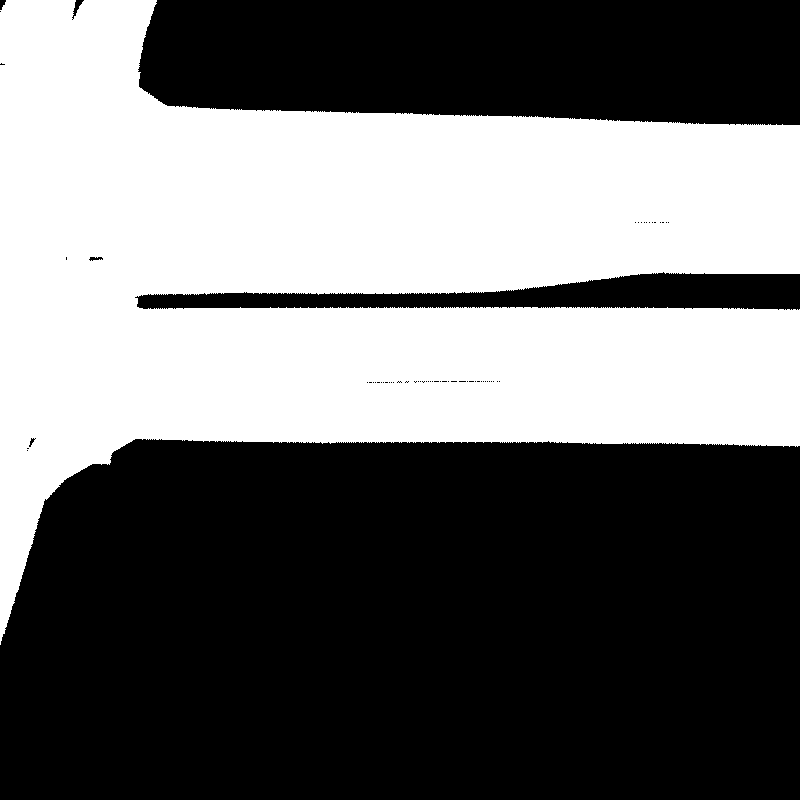

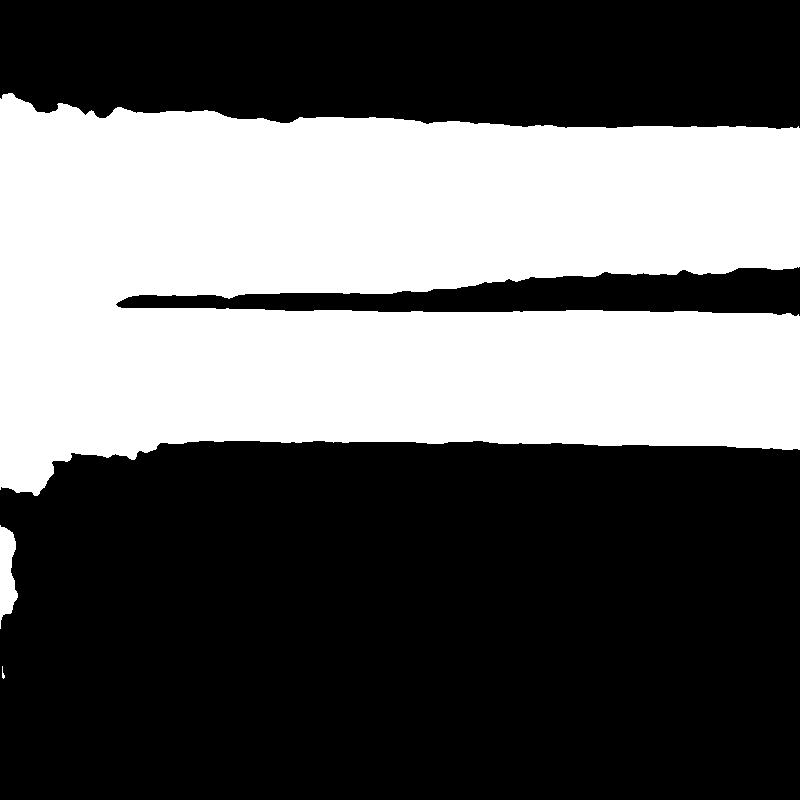

epoch 28, iter 0: 0.025297334417700768
epoch 28, iter 20: 0.02066655457019806
epoch 28, iter 40: 0.01612677052617073
epoch 28, iter 60: 0.021687008440494537
epoch 28, iter 80: 0.023821013048291206
epoch 28, iter 100: 0.028754033148288727
epoch 28, iter 120: 0.023357365280389786
epoch 28, iter 140: 0.0240660198032856
epoch 28, iter 160: 0.024912303313612938
epoch 28, iter 180: 0.018567699939012527
epoch 28, iter 200: 0.02715683914721012
epoch 28, iter 220: 0.029944878071546555
epoch 28, iter 240: 0.01724673993885517
epoch 28, iter 260: 0.02459132857620716
epoch 28, iter 280: 0.027496937662363052
epoch 28, iter 300: 0.01607663929462433
validation epoch 28: 0.08888544887304306


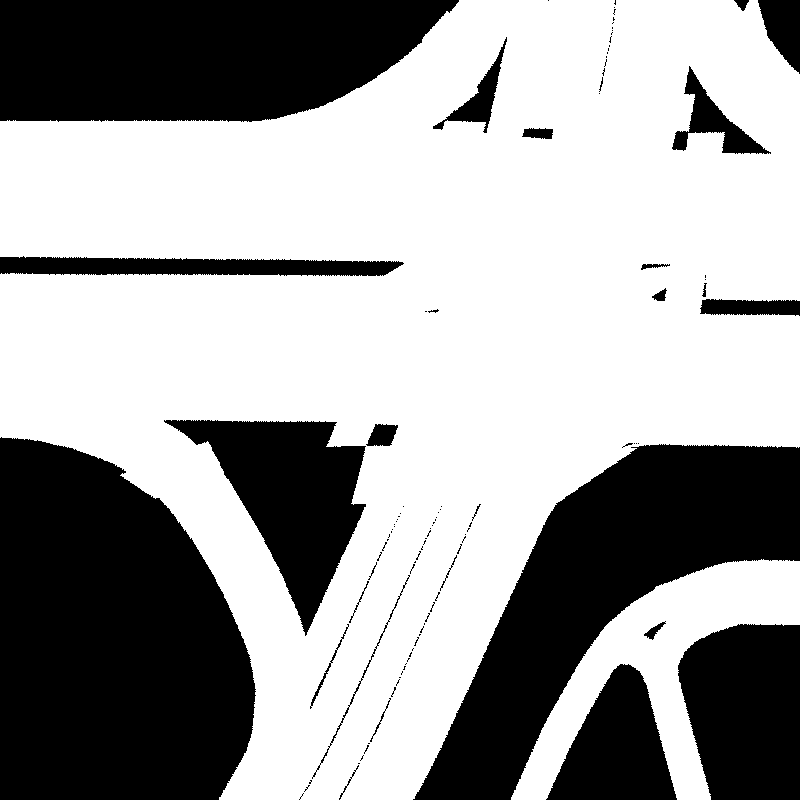

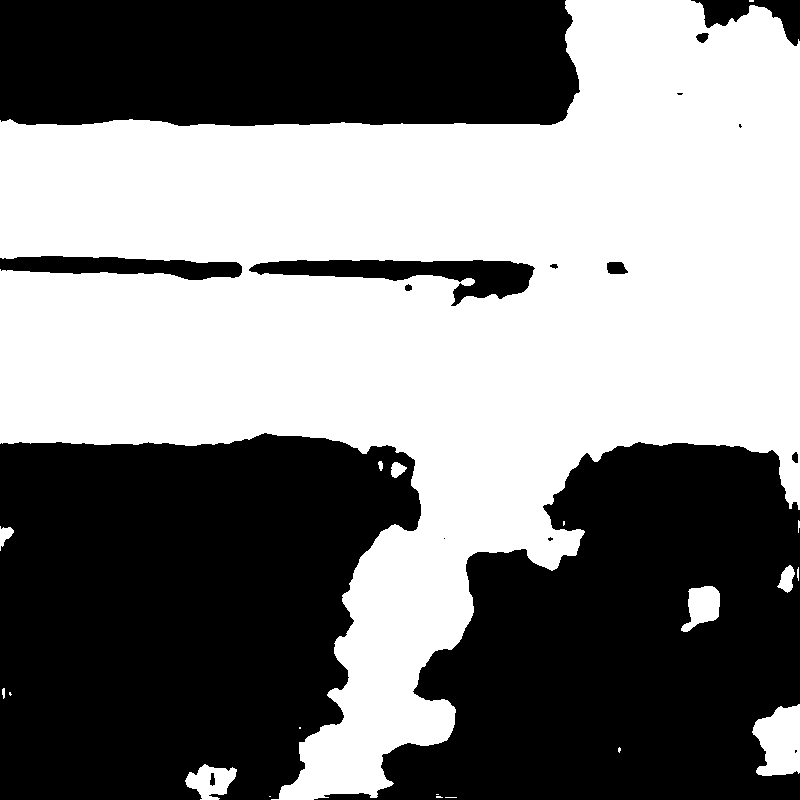

epoch 29, iter 0: 0.019566643983125687
epoch 29, iter 20: 0.025163797661662102
epoch 29, iter 40: 0.016413360834121704
epoch 29, iter 60: 0.016357507556676865
epoch 29, iter 80: 0.020854616537690163
epoch 29, iter 100: 0.024859407916665077
epoch 29, iter 120: 0.021498754620552063
epoch 29, iter 140: 0.027392210438847542
epoch 29, iter 160: 0.01649143546819687
epoch 29, iter 180: 0.025523412972688675
epoch 29, iter 200: 0.01774250902235508
epoch 29, iter 220: 0.020654942840337753
epoch 29, iter 240: 0.02835792489349842
epoch 29, iter 260: 0.02553403005003929
epoch 29, iter 280: 0.02644117921590805
epoch 29, iter 300: 0.016333095729351044
validation epoch 29: 0.08986473083496094


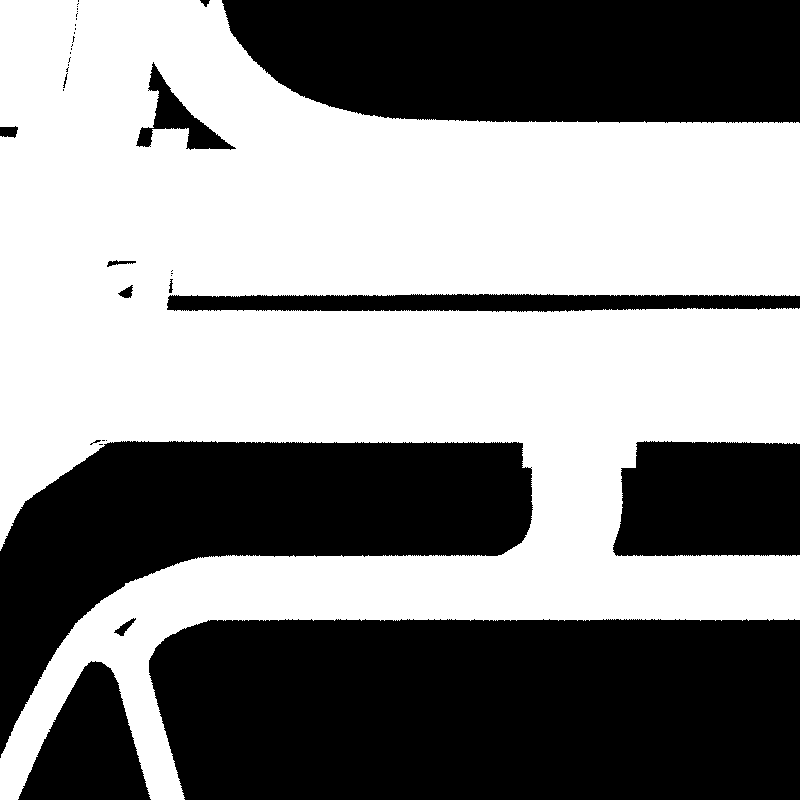

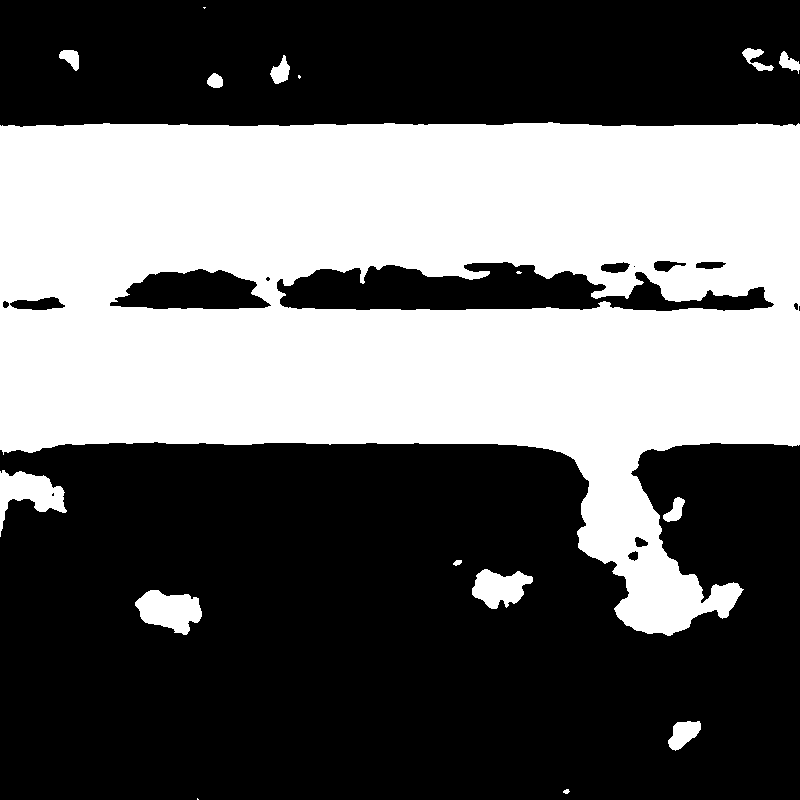

epoch 30, iter 0: 0.02228769101202488
epoch 30, iter 20: 0.01825662888586521
epoch 30, iter 40: 0.022166527807712555
epoch 30, iter 60: 0.02132265642285347
epoch 30, iter 80: 0.021809473633766174
epoch 30, iter 100: 0.017935171723365784
epoch 30, iter 120: 0.029093770310282707
epoch 30, iter 140: 0.023607850074768066
epoch 30, iter 160: 0.024663280695676804
epoch 30, iter 180: 0.018171802163124084
epoch 30, iter 200: 0.01647147536277771
epoch 30, iter 220: 0.021999260410666466
epoch 30, iter 240: 0.024061910808086395
epoch 30, iter 260: 0.020470621064305305
epoch 30, iter 280: 0.03230476751923561
epoch 30, iter 300: 0.02226741798222065
validation epoch 30: 0.08401922881603241


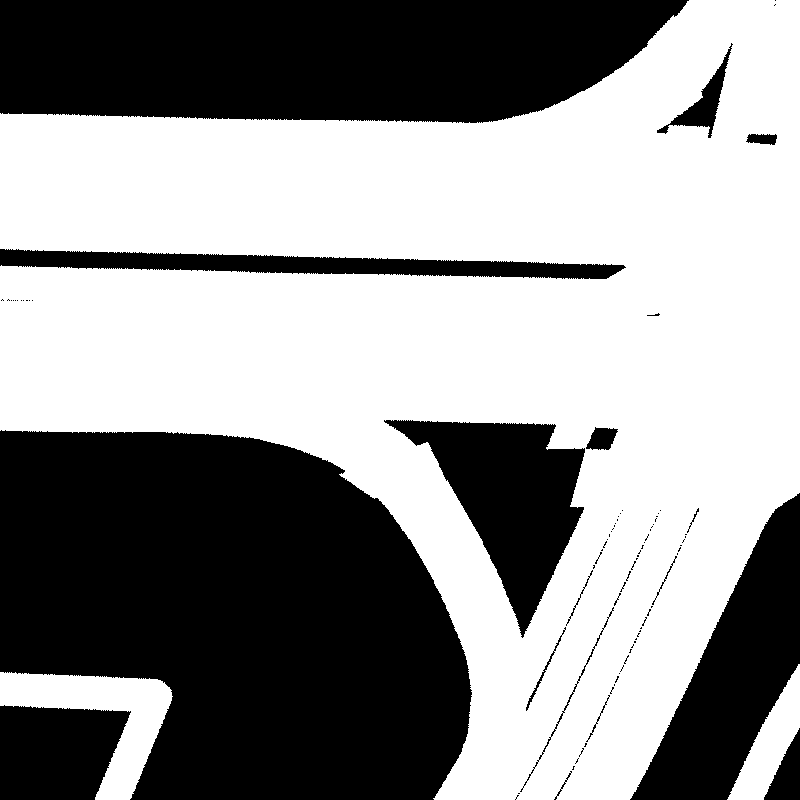

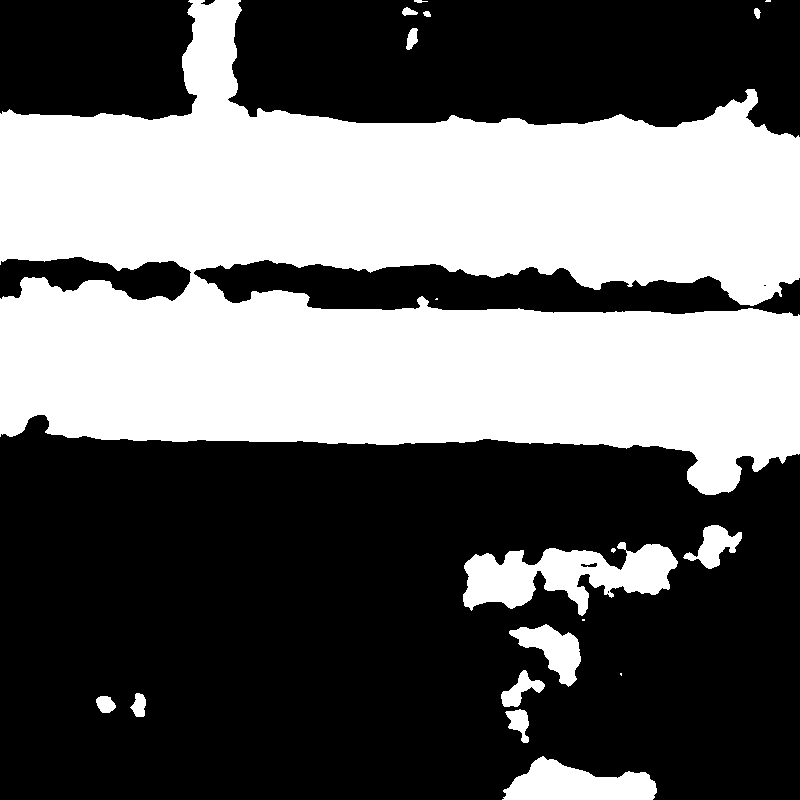

epoch 31, iter 0: 0.020899921655654907
epoch 31, iter 20: 0.016148561611771584
epoch 31, iter 40: 0.027081817388534546
epoch 31, iter 60: 0.01990561932325363
epoch 31, iter 80: 0.018812276422977448
epoch 31, iter 100: 0.015675721690058708
epoch 31, iter 120: 0.022783320397138596
epoch 31, iter 140: 0.022449582815170288
epoch 31, iter 160: 0.024061135947704315
epoch 31, iter 180: 0.020194988697767258
epoch 31, iter 200: 0.017425665631890297
epoch 31, iter 220: 0.022151939570903778
epoch 31, iter 240: 0.015734946355223656
epoch 31, iter 260: 0.018951771780848503
epoch 31, iter 280: 0.025952812284231186
epoch 31, iter 300: 0.016436908394098282
validation epoch 31: 0.0854281485080719


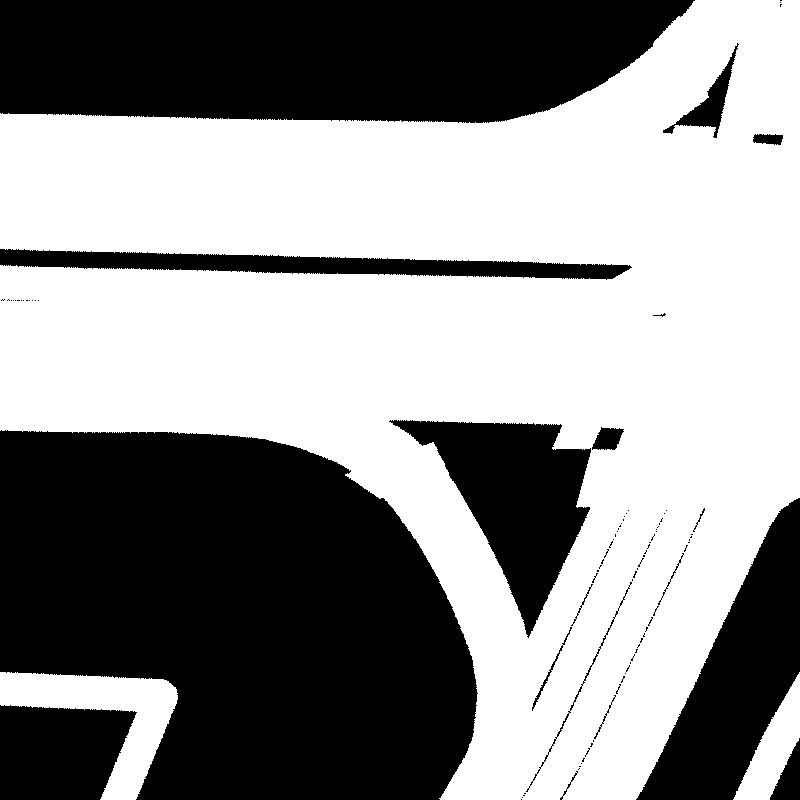

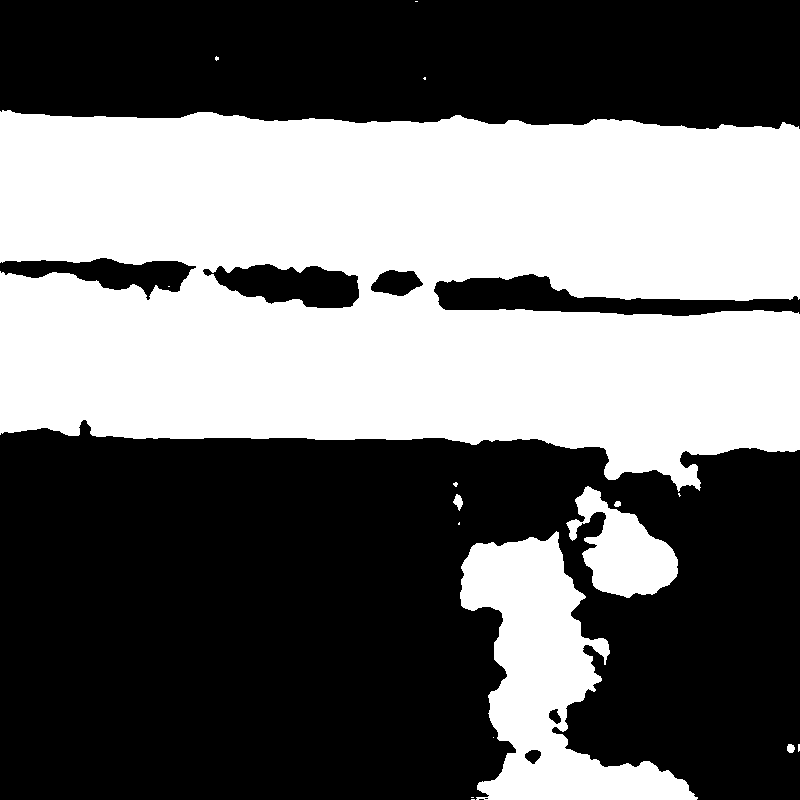

epoch 32, iter 0: 0.015585882589221
epoch 32, iter 20: 0.017743047326803207
epoch 32, iter 40: 0.02095598727464676
epoch 32, iter 60: 0.017588775604963303
epoch 32, iter 80: 0.01861593872308731
epoch 32, iter 100: 0.017561061307787895
epoch 32, iter 120: 0.015594884753227234
epoch 32, iter 140: 0.02577175572514534
epoch 32, iter 160: 0.020247897133231163
epoch 32, iter 180: 0.014249254949390888
epoch 32, iter 200: 0.01715165749192238
epoch 32, iter 220: 0.023432156071066856
epoch 32, iter 240: 0.018699197098612785
epoch 32, iter 260: 0.014241076074540615
epoch 32, iter 280: 0.026330694556236267
epoch 32, iter 300: 0.022950146347284317
validation epoch 32: 0.0841536596417427


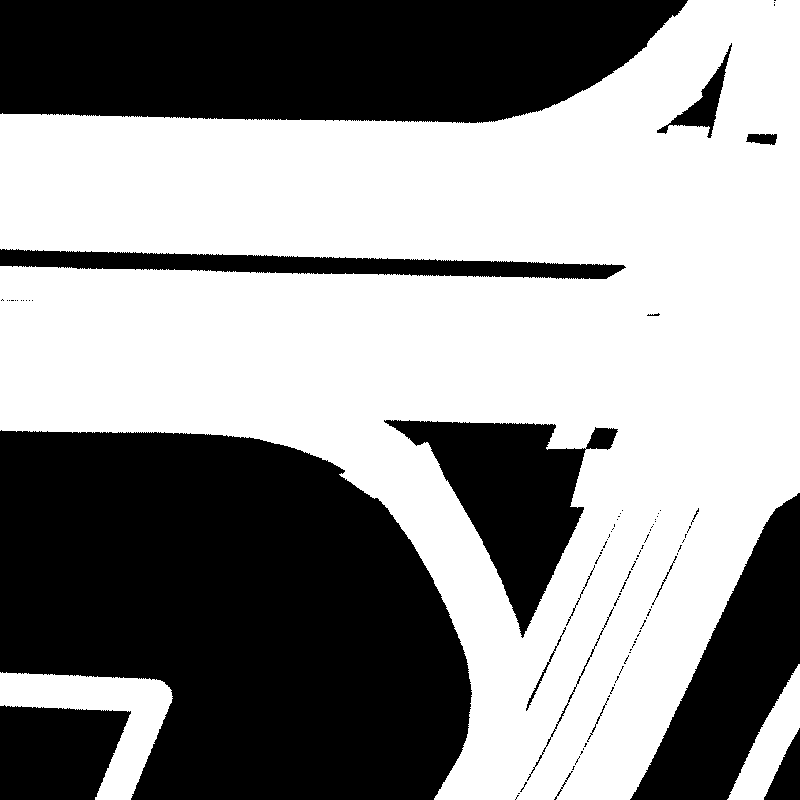

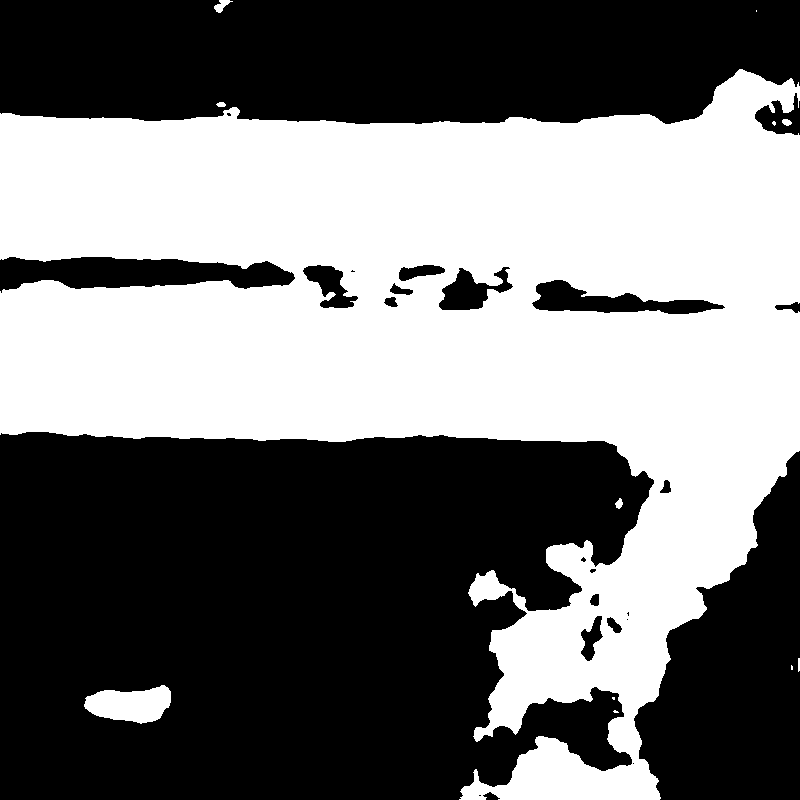

epoch 33, iter 0: 0.020089028403162956
epoch 33, iter 20: 0.016161873936653137
epoch 33, iter 40: 0.013422285206615925
epoch 33, iter 60: 0.02047482132911682
epoch 33, iter 80: 0.010844317264854908
epoch 33, iter 100: 0.020072534680366516
epoch 33, iter 120: 0.021599045023322105
epoch 33, iter 140: 0.014486489817500114
epoch 33, iter 160: 0.015764156356453896
epoch 33, iter 180: 0.015551803633570671
epoch 33, iter 200: 0.014256319962441921
epoch 33, iter 220: 0.013795263133943081
epoch 33, iter 240: 0.01989045925438404
epoch 33, iter 260: 0.022714443504810333
epoch 33, iter 280: 0.024147802963852882
epoch 33, iter 300: 0.01613912545144558
validation epoch 33: 0.08955676108598709


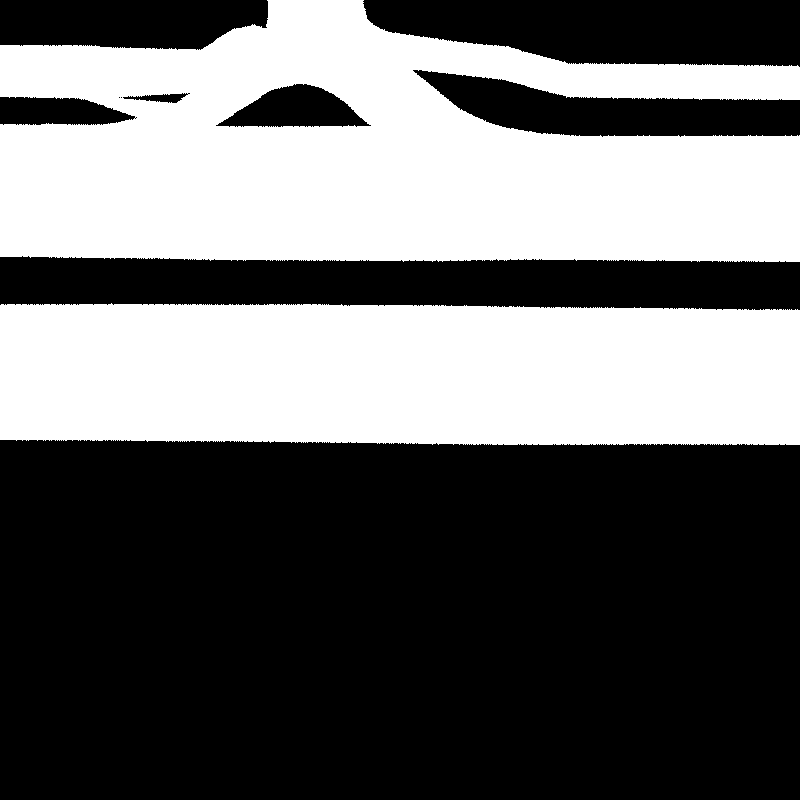

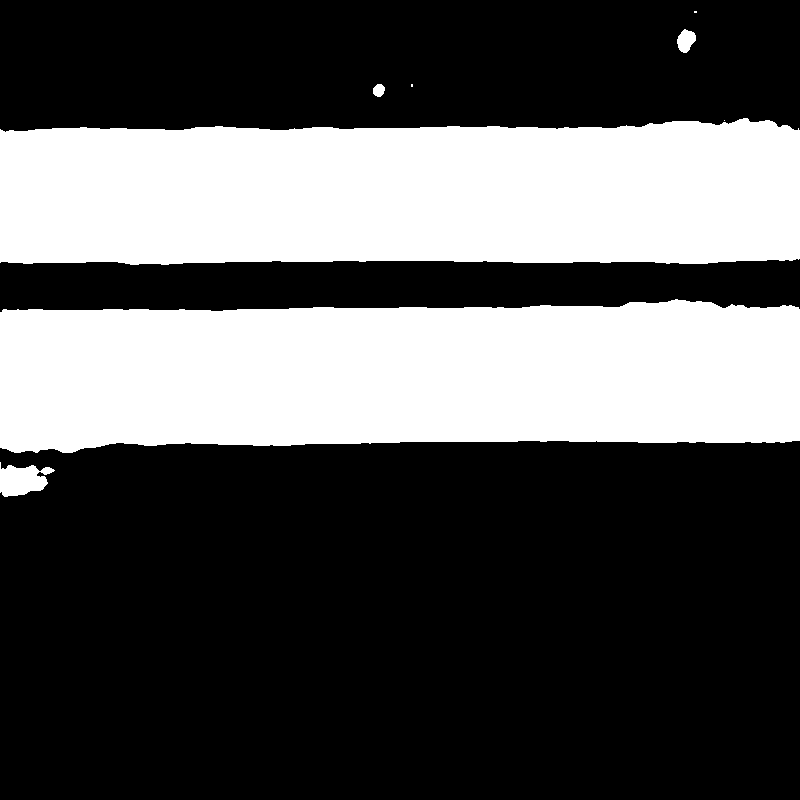

epoch 34, iter 0: 0.019777080044150352
epoch 34, iter 20: 0.019215090200304985
epoch 34, iter 40: 0.016963623464107513
epoch 34, iter 60: 0.014973306097090244
epoch 34, iter 80: 0.020058773458003998
epoch 34, iter 100: 0.021867660805583
epoch 34, iter 120: 0.012618359178304672
epoch 34, iter 140: 0.021518254652619362
epoch 34, iter 160: 0.014241770841181278
epoch 34, iter 180: 0.015249724499881268
epoch 34, iter 200: 0.03321469575166702
epoch 34, iter 220: 0.01723145693540573
epoch 34, iter 240: 0.021214559674263
epoch 34, iter 260: 0.014897963963449001
epoch 34, iter 280: 0.01661868393421173
epoch 34, iter 300: 0.01527355331927538
validation epoch 34: 0.08955014497041702


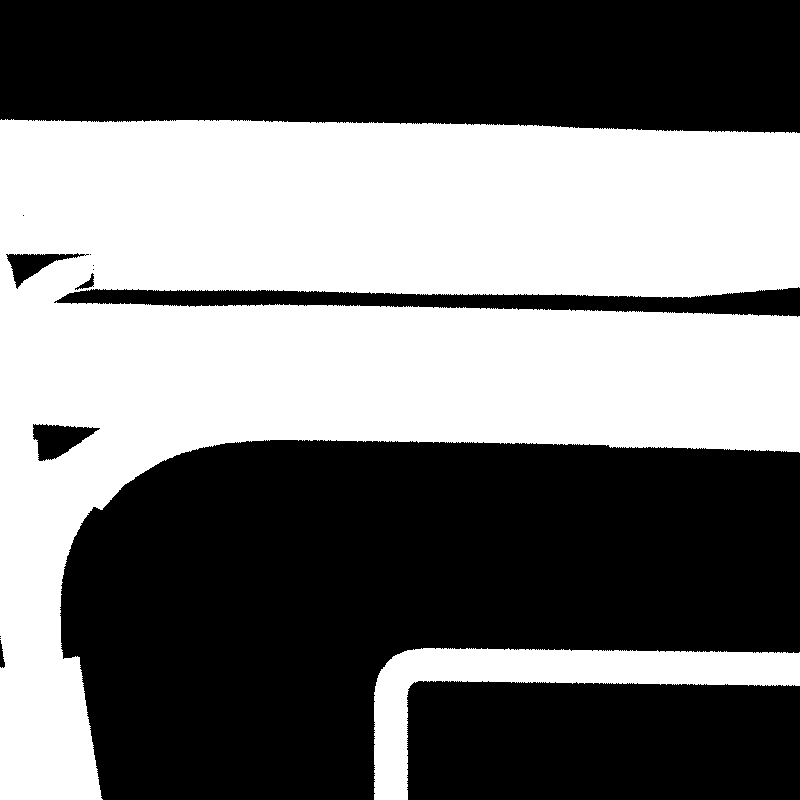

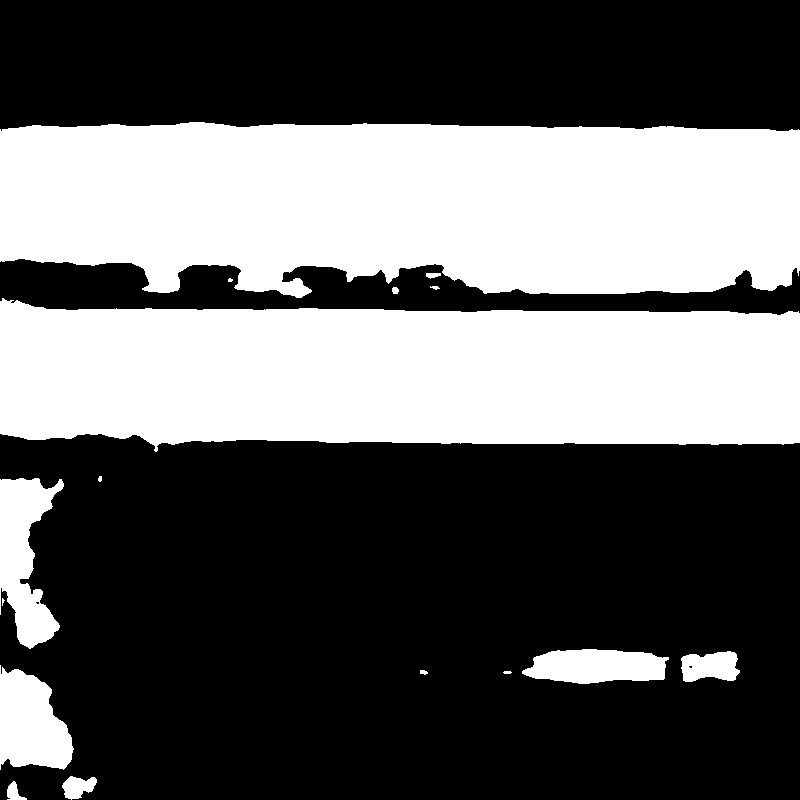

epoch 35, iter 0: 0.018742965534329414
epoch 35, iter 20: 0.020363010466098785
epoch 35, iter 40: 0.018761642277240753
epoch 35, iter 60: 0.015159244649112225
epoch 35, iter 80: 0.020768074318766594
epoch 35, iter 100: 0.021688681095838547
epoch 35, iter 120: 0.015429327264428139
epoch 35, iter 140: 0.012924161739647388
epoch 35, iter 160: 0.023696815595030785
epoch 35, iter 180: 0.019352970644831657
epoch 35, iter 200: 0.015817871317267418
epoch 35, iter 220: 0.013723478652536869
epoch 35, iter 240: 0.02727845311164856
epoch 35, iter 260: 0.02398166060447693
epoch 35, iter 280: 0.018411876633763313
epoch 35, iter 300: 0.0163921806961298
validation epoch 35: 0.08557002991437912


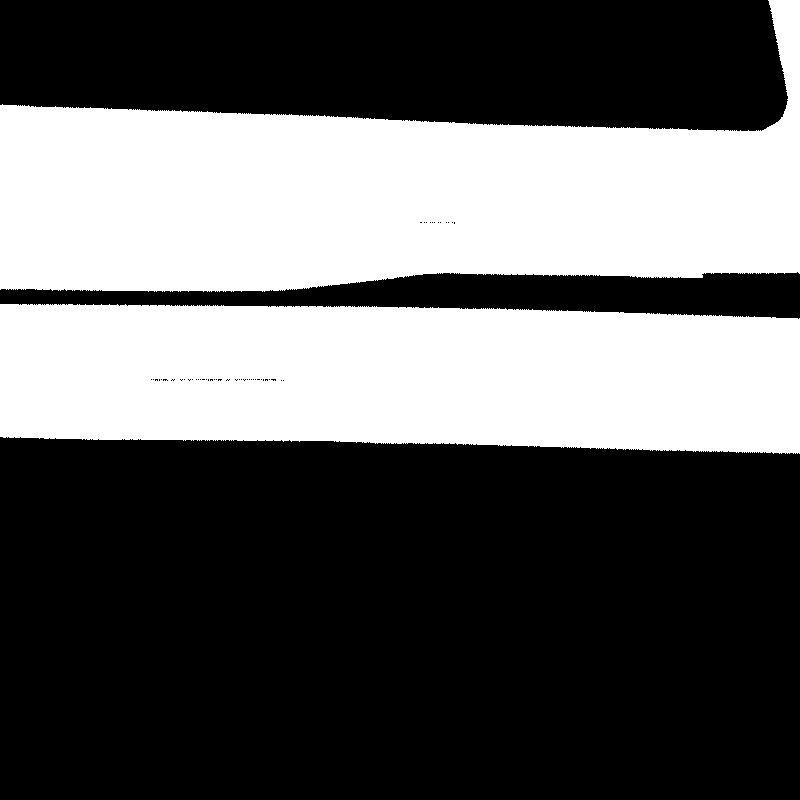

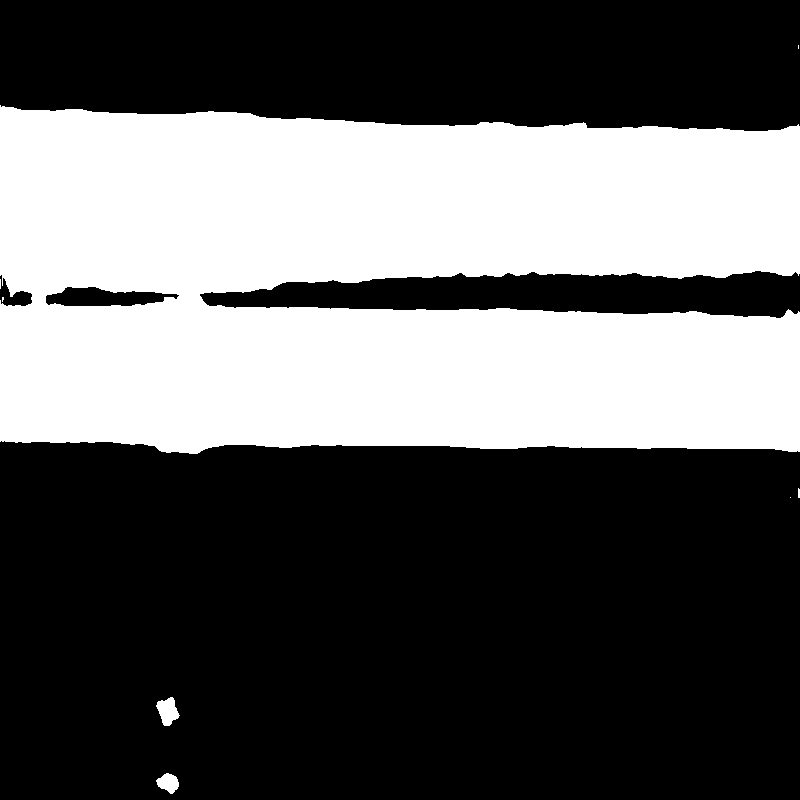

epoch 36, iter 0: 0.015588454902172089
epoch 36, iter 20: 0.01697337068617344
epoch 36, iter 40: 0.016874054446816444
epoch 36, iter 60: 0.013602548278868198
epoch 36, iter 80: 0.0241289883852005
epoch 36, iter 100: 0.015840258449316025
epoch 36, iter 120: 0.01857260800898075
epoch 36, iter 140: 0.016350502148270607
epoch 36, iter 160: 0.018660498782992363
epoch 36, iter 180: 0.011256380937993526
epoch 36, iter 200: 0.02105129137635231
epoch 36, iter 220: 0.018511708825826645
epoch 36, iter 240: 0.015159985050559044
epoch 36, iter 260: 0.01950252056121826
epoch 36, iter 280: 0.01759774051606655
epoch 36, iter 300: 0.01666228286921978
validation epoch 36: 0.0885234847664833


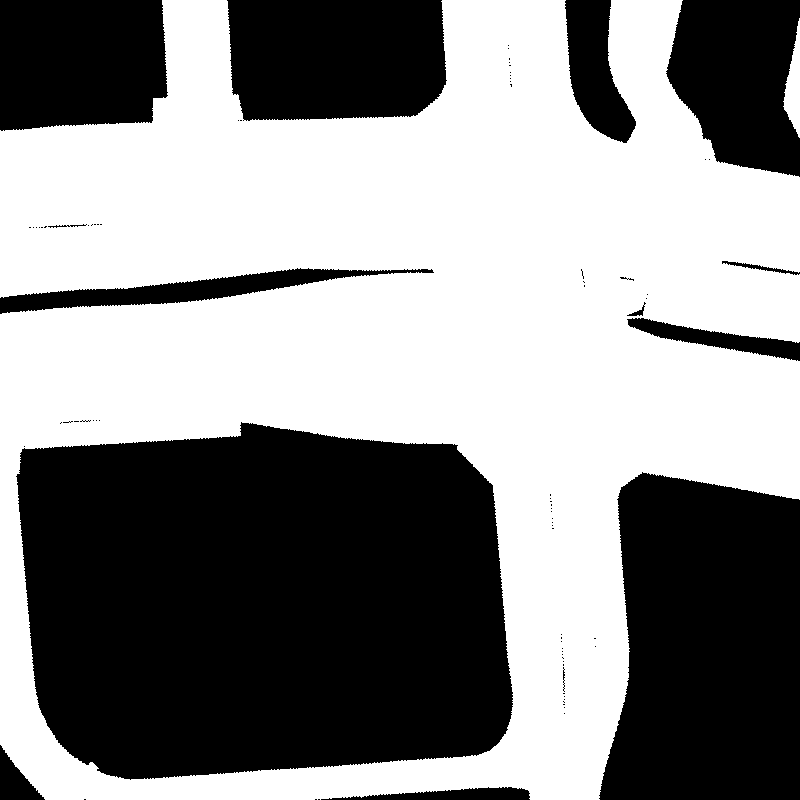

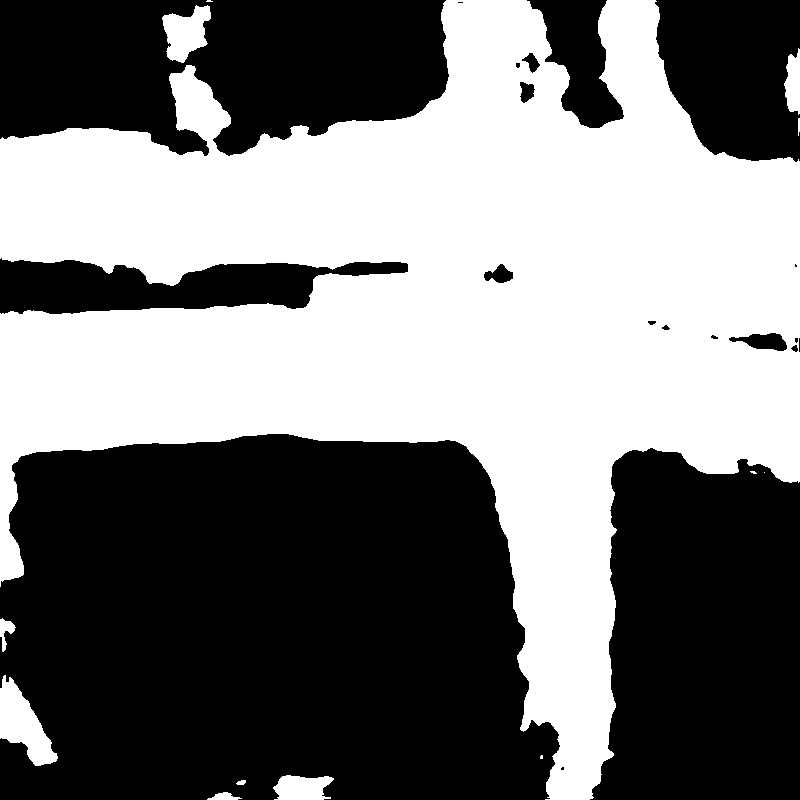

epoch 37, iter 0: 0.019753091037273407
epoch 37, iter 20: 0.014245457015931606
epoch 37, iter 40: 0.0164032019674778
epoch 37, iter 60: 0.019259674474596977
epoch 37, iter 80: 0.014984148554503918
epoch 37, iter 100: 0.018245259299874306
epoch 37, iter 120: 0.01647447980940342
epoch 37, iter 140: 0.022750044241547585
epoch 37, iter 160: 0.013718775473535061
epoch 37, iter 180: 0.01390550471842289
epoch 37, iter 200: 0.021809609606862068
epoch 37, iter 220: 0.021367505192756653
epoch 37, iter 240: 0.02864675782620907
epoch 37, iter 260: 0.01849503256380558
epoch 37, iter 280: 0.02338014356791973
epoch 37, iter 300: 0.01799514703452587
validation epoch 37: 0.08471356332302094


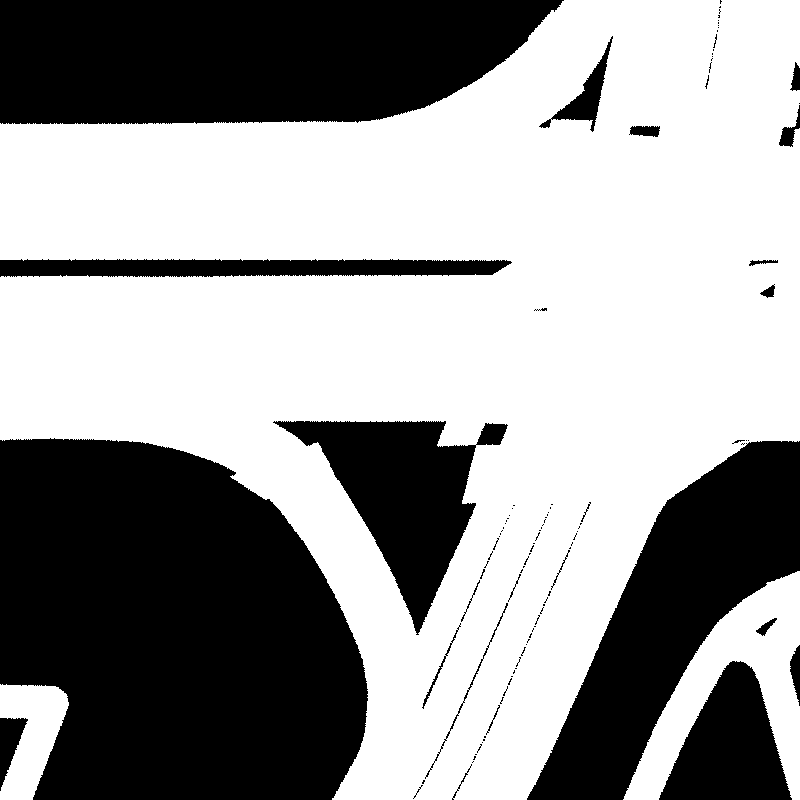

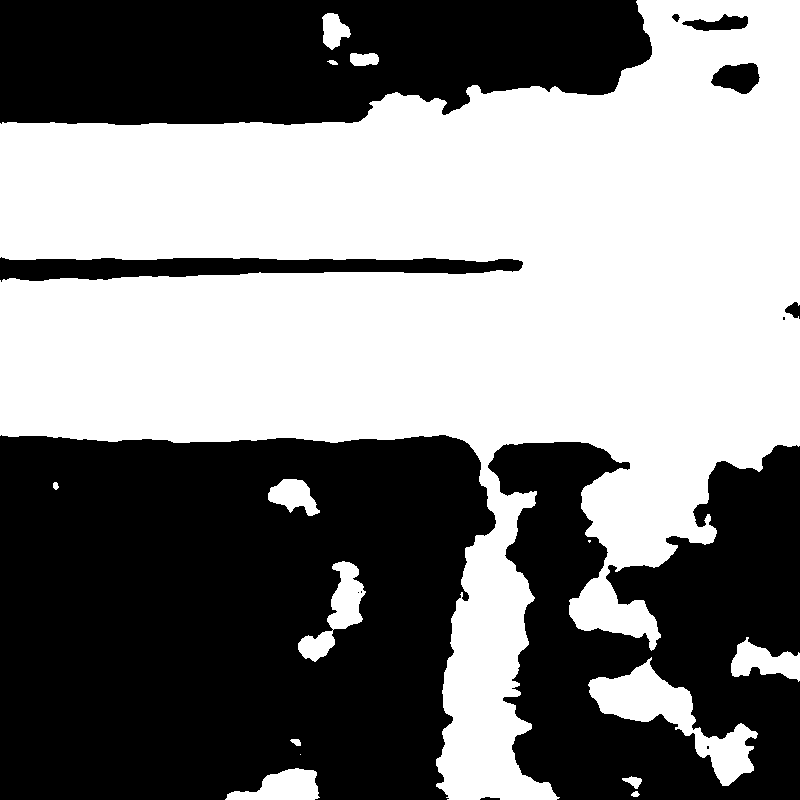

epoch 38, iter 0: 0.01567830704152584
epoch 38, iter 20: 0.024364281445741653
epoch 38, iter 40: 0.022278135642409325
epoch 38, iter 60: 0.016852950677275658
epoch 38, iter 80: 0.019447509199380875
epoch 38, iter 100: 0.01456593256443739
epoch 38, iter 120: 0.012658298015594482
epoch 38, iter 140: 0.015359718352556229
epoch 38, iter 160: 0.019208000972867012
epoch 38, iter 180: 0.014519849792122841
epoch 38, iter 200: 0.020919209346175194
epoch 38, iter 220: 0.018545251339673996
epoch 38, iter 240: 0.0195431150496006
epoch 38, iter 260: 0.017611194401979446
epoch 38, iter 280: 0.013667907565832138
epoch 38, iter 300: 0.027064230293035507
validation epoch 38: 0.08684686571359634


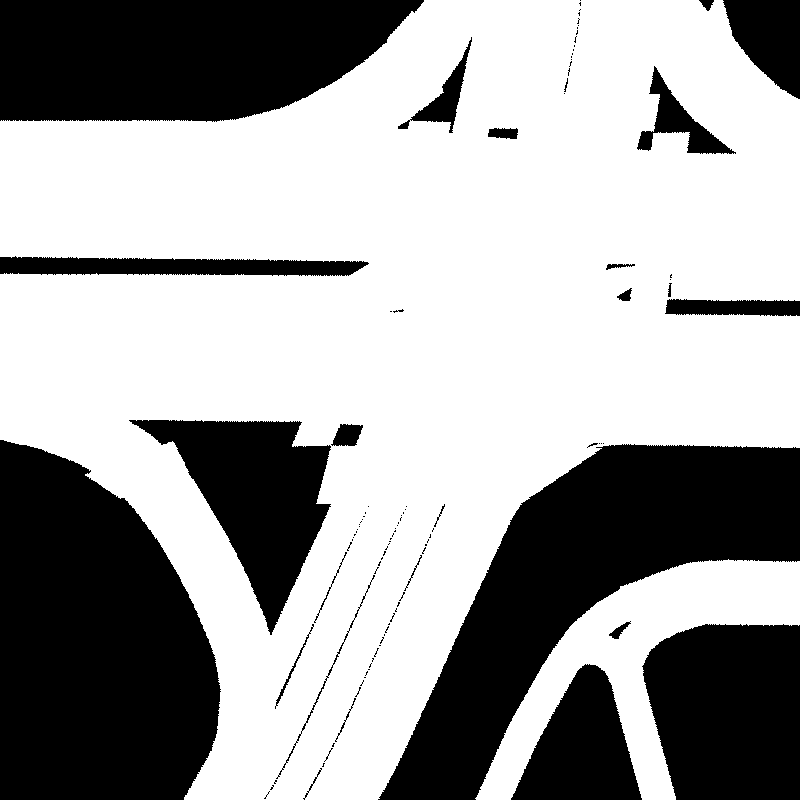

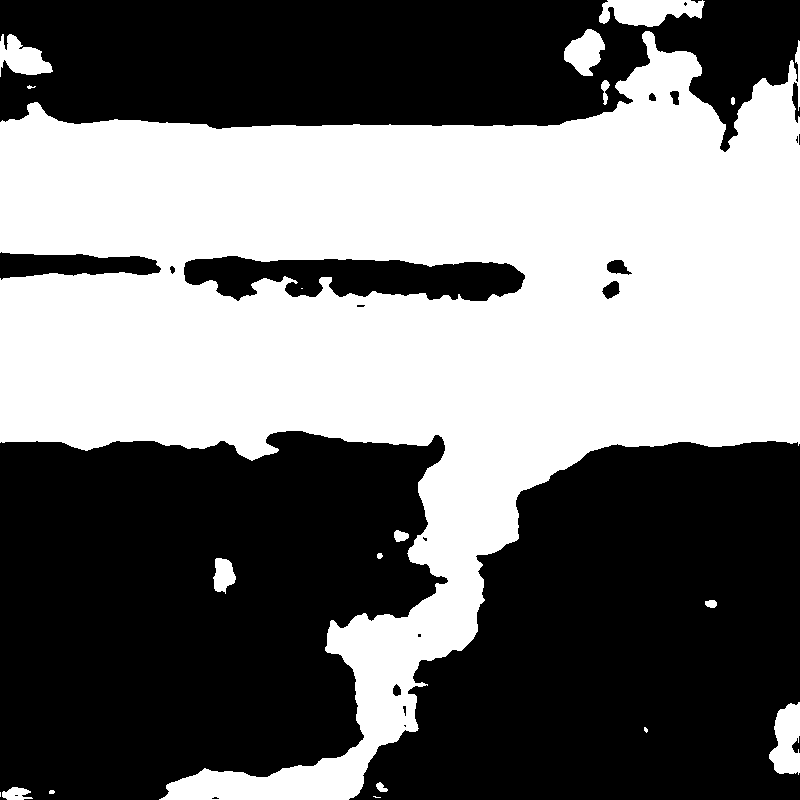

epoch 39, iter 0: 0.008627688512206078
epoch 39, iter 20: 0.018274299800395966
epoch 39, iter 40: 0.015624484047293663
epoch 39, iter 60: 0.015125170350074768
epoch 39, iter 80: 0.02181600220501423
epoch 39, iter 100: 0.01605108007788658
epoch 39, iter 120: 0.01965722255408764
epoch 39, iter 140: 0.013425750657916069
epoch 39, iter 160: 0.01600566692650318
epoch 39, iter 180: 0.016623182222247124
epoch 39, iter 200: 0.015750784426927567
epoch 39, iter 220: 0.018291259184479713
epoch 39, iter 240: 0.016849126666784286
epoch 39, iter 260: 0.0209809597581625
epoch 39, iter 280: 0.022105377167463303
epoch 39, iter 300: 0.0144532835111022
validation epoch 39: 0.08696246147155762


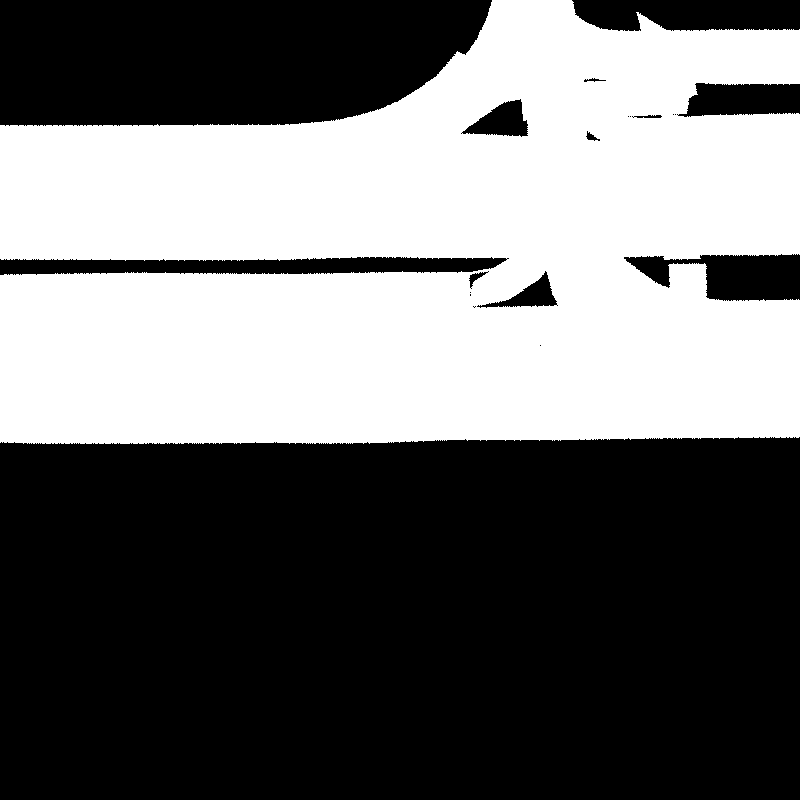

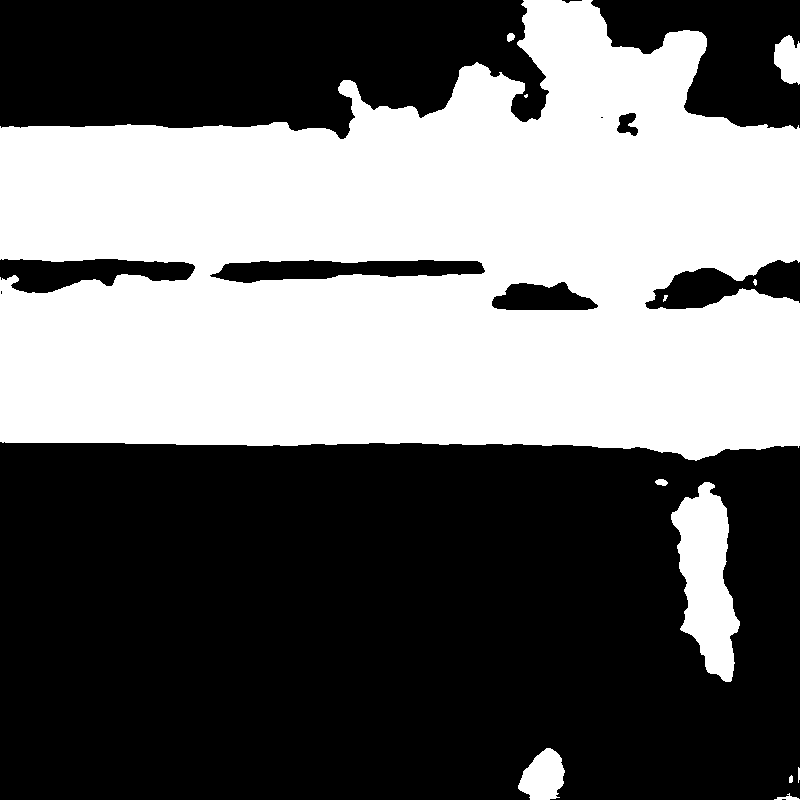

epoch 40, iter 0: 0.026150023564696312
epoch 40, iter 20: 0.01552114263176918
epoch 40, iter 40: 0.017011307179927826
epoch 40, iter 60: 0.02119440771639347
epoch 40, iter 80: 0.01816391572356224
epoch 40, iter 100: 0.017597338184714317
epoch 40, iter 120: 0.020124755799770355
epoch 40, iter 140: 0.02071947231888771
epoch 40, iter 160: 0.016764990985393524
epoch 40, iter 180: 0.01897249184548855
epoch 40, iter 200: 0.0176215972751379
epoch 40, iter 220: 0.009078487753868103
epoch 40, iter 240: 0.013892858289182186
epoch 40, iter 260: 0.009089713916182518
epoch 40, iter 280: 0.0168157946318388
epoch 40, iter 300: 0.01256824005395174
validation epoch 40: 0.0866239070892334


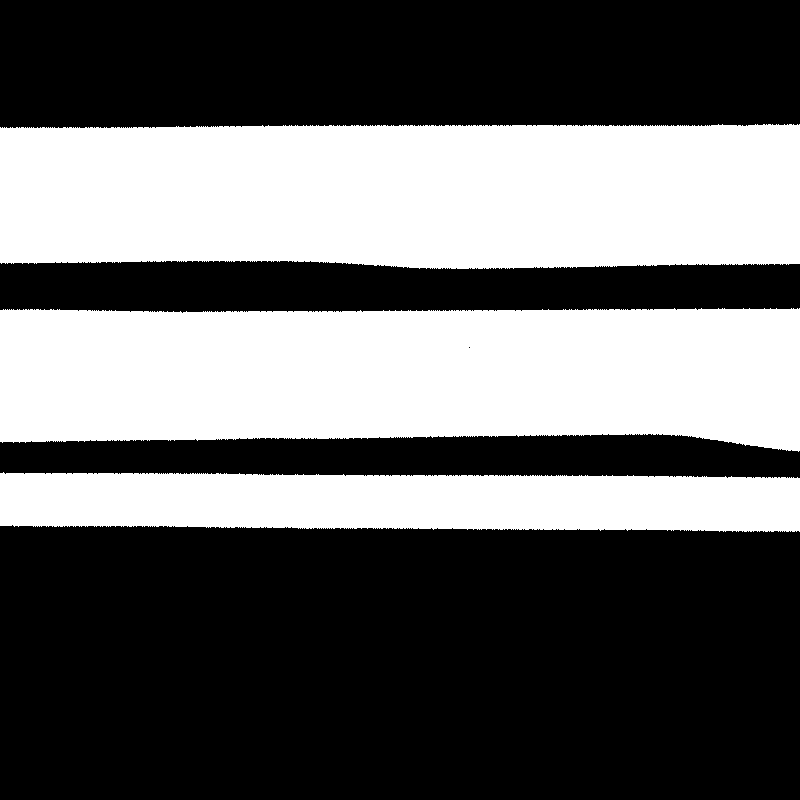

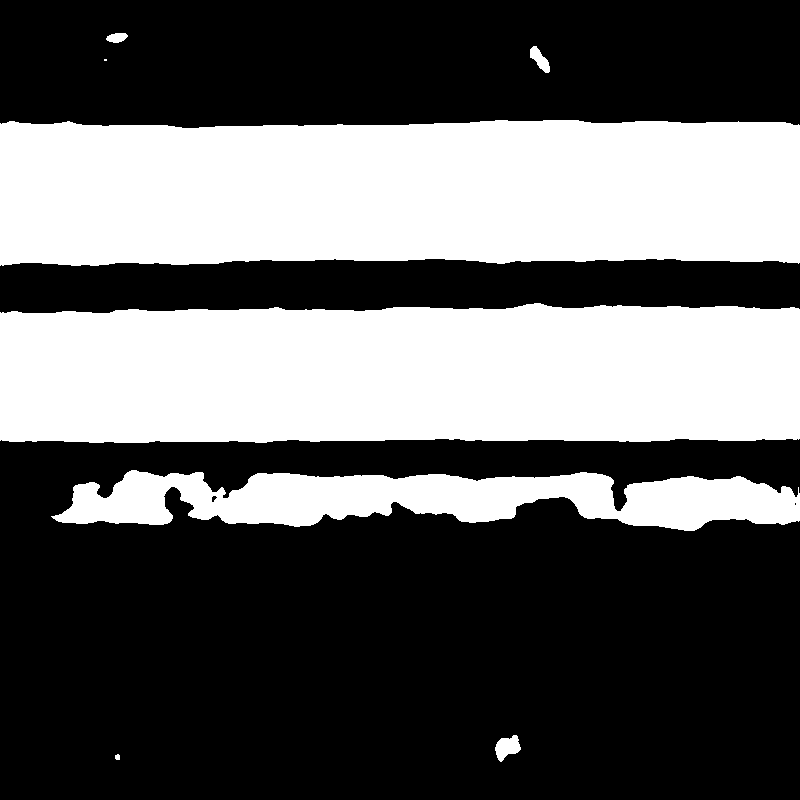

epoch 41, iter 0: 0.01980794034898281
epoch 41, iter 20: 0.01836462691426277
epoch 41, iter 40: 0.013262787833809853
epoch 41, iter 60: 0.022019565105438232
epoch 41, iter 80: 0.013876058161258698
epoch 41, iter 100: 0.012182217091321945
epoch 41, iter 120: 0.018614880740642548
epoch 41, iter 140: 0.017105907201766968
epoch 41, iter 160: 0.02049478329718113
epoch 41, iter 180: 0.017234692350029945
epoch 41, iter 200: 0.022967806085944176
epoch 41, iter 220: 0.012175068259239197
epoch 41, iter 240: 0.013948154635727406
epoch 41, iter 260: 0.014972266741096973
epoch 41, iter 280: 0.012790322303771973
epoch 41, iter 300: 0.024835892021656036
validation epoch 41: 0.09376950562000275


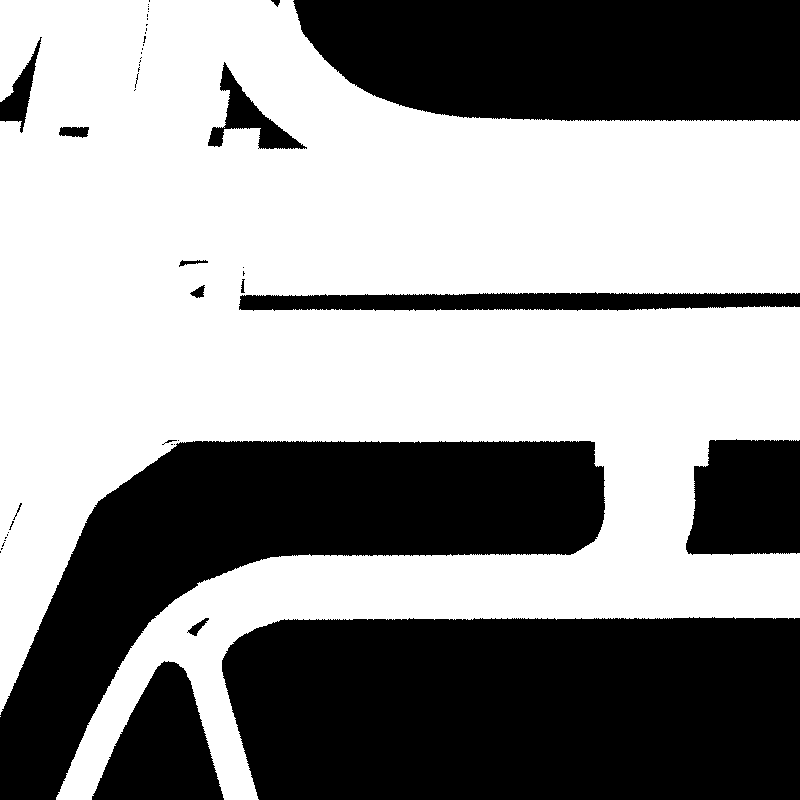

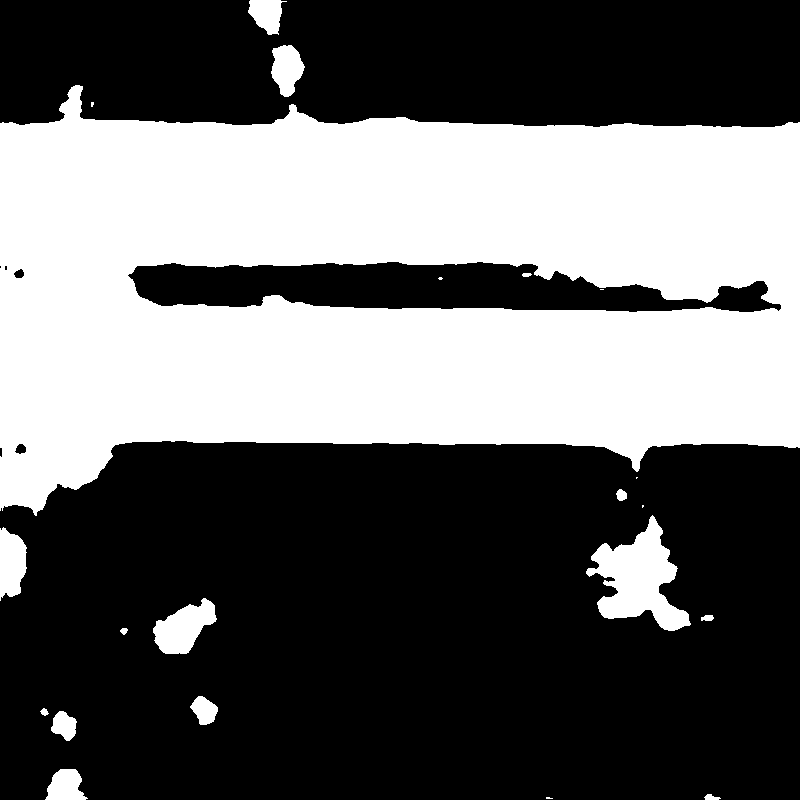

epoch 42, iter 0: 0.015280468389391899
epoch 42, iter 20: 0.013946877792477608
epoch 42, iter 40: 0.009771136566996574
epoch 42, iter 60: 0.016681058332324028
epoch 42, iter 80: 0.014560324139893055
epoch 42, iter 100: 0.013532082550227642
epoch 42, iter 120: 0.022739751264452934
epoch 42, iter 140: 0.014028843492269516
epoch 42, iter 160: 0.017032461240887642
epoch 42, iter 180: 0.016560716554522514
epoch 42, iter 200: 0.012949331663548946
epoch 42, iter 220: 0.015821028500795364
epoch 42, iter 240: 0.012689619325101376
epoch 42, iter 260: 0.022109434008598328
epoch 42, iter 280: 0.01576322317123413
epoch 42, iter 300: 0.014894213527441025
validation epoch 42: 0.0860196202993393


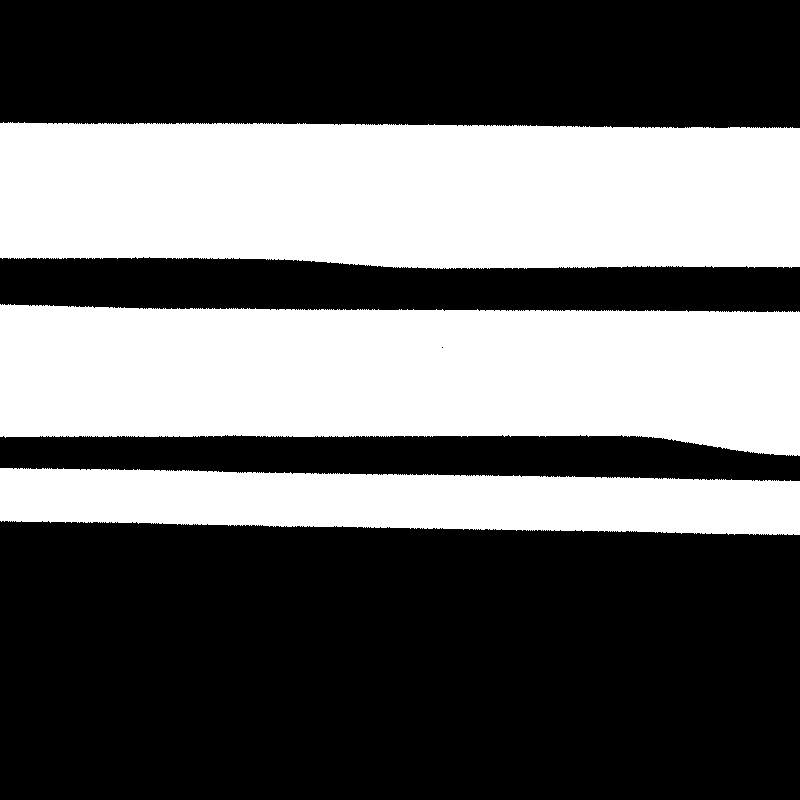

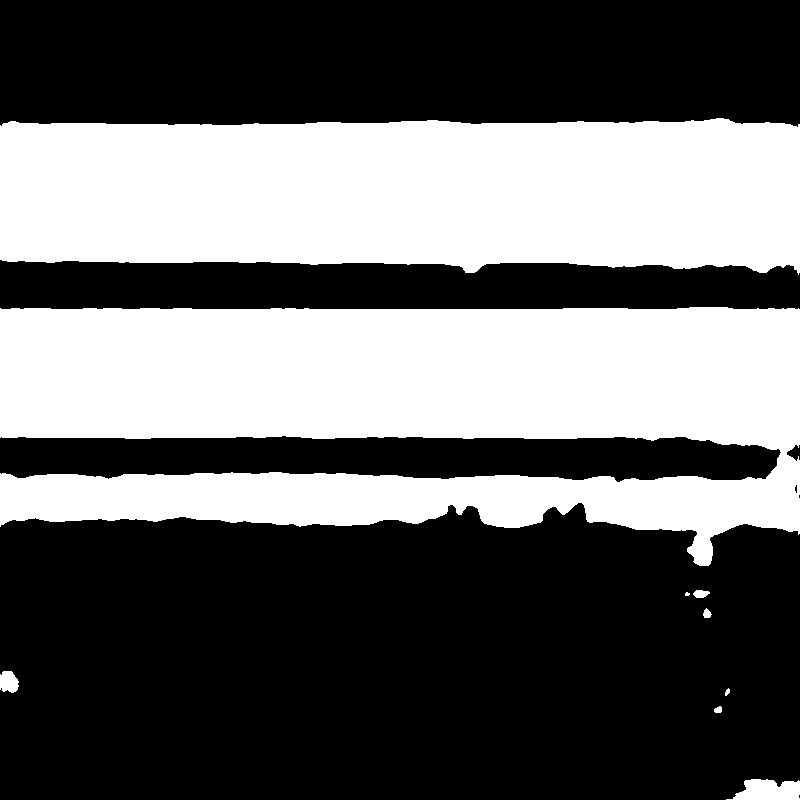

epoch 43, iter 0: 0.017798755317926407
epoch 43, iter 20: 0.01450110413134098
epoch 43, iter 40: 0.015275826677680016
epoch 43, iter 60: 0.013148050755262375
epoch 43, iter 80: 0.016202297061681747
epoch 43, iter 100: 0.014354052022099495
epoch 43, iter 120: 0.01749156229197979
epoch 43, iter 140: 0.013939016498625278
epoch 43, iter 160: 0.016841839998960495
epoch 43, iter 180: 0.021831493824720383
epoch 43, iter 200: 0.015701305121183395
epoch 43, iter 220: 0.017418116331100464
epoch 43, iter 240: 0.013222761452198029
epoch 43, iter 260: 0.018209965899586678
epoch 43, iter 280: 0.024230333045125008
epoch 43, iter 300: 0.018214378505945206
validation epoch 43: 0.0886722058057785


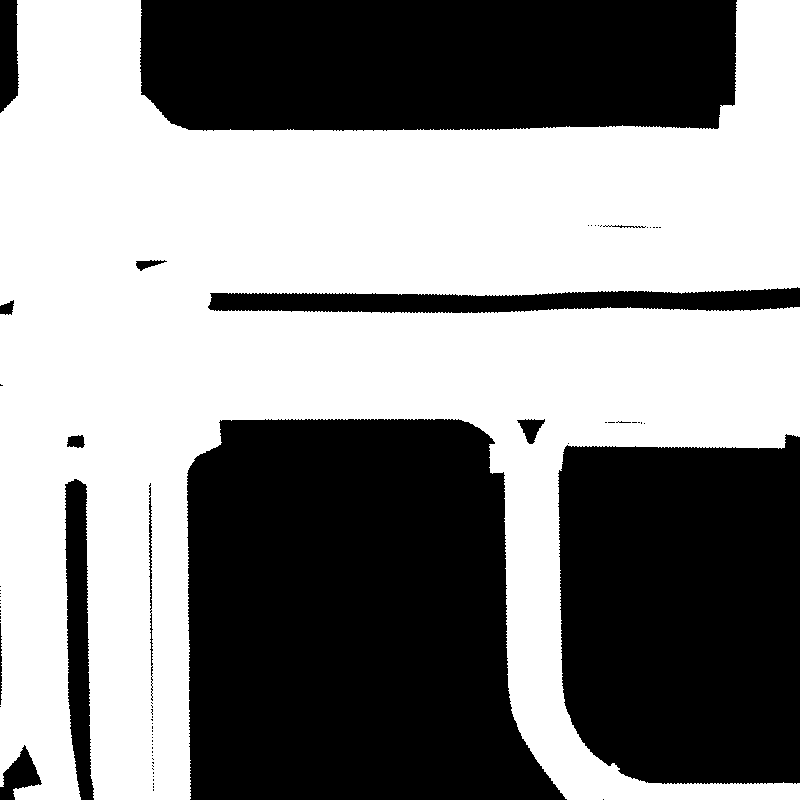

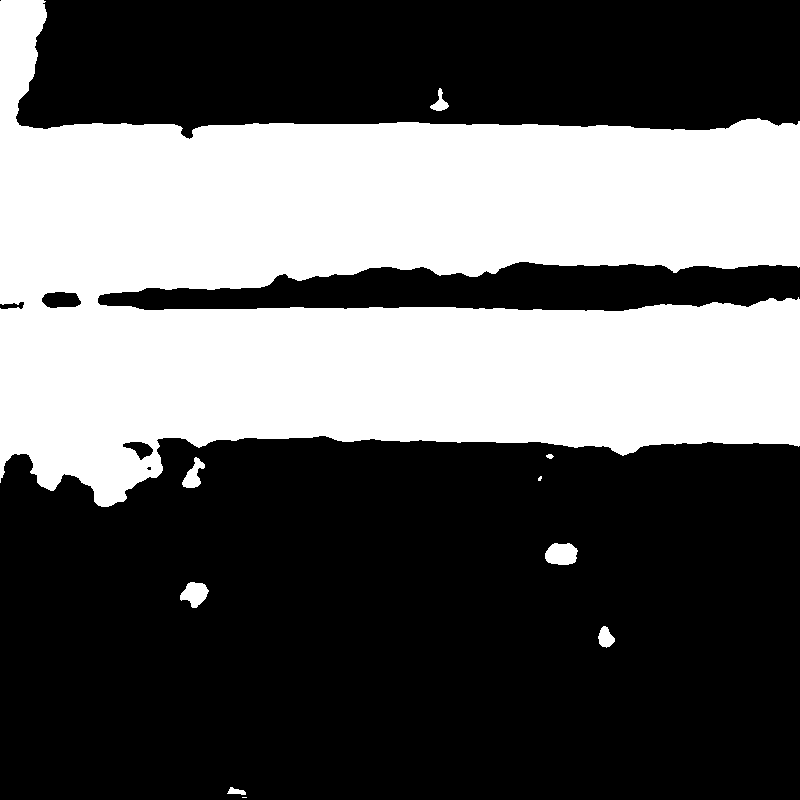

epoch 44, iter 0: 0.013063852675259113
epoch 44, iter 20: 0.013362896628677845
epoch 44, iter 40: 0.014385683462023735
epoch 44, iter 60: 0.006573652382940054
epoch 44, iter 80: 0.006848923861980438
epoch 44, iter 100: 0.012626833282411098
epoch 44, iter 120: 0.01856786385178566
epoch 44, iter 140: 0.019223880022764206
epoch 44, iter 160: 0.018385643139481544
epoch 44, iter 180: 0.010249958373606205
epoch 44, iter 200: 0.022137420251965523
epoch 44, iter 220: 0.015573721379041672
epoch 44, iter 240: 0.012648063711822033
epoch 44, iter 260: 0.013472240418195724
epoch 44, iter 280: 0.01579858735203743
epoch 44, iter 300: 0.012328610755503178
validation epoch 44: 0.08851145952939987


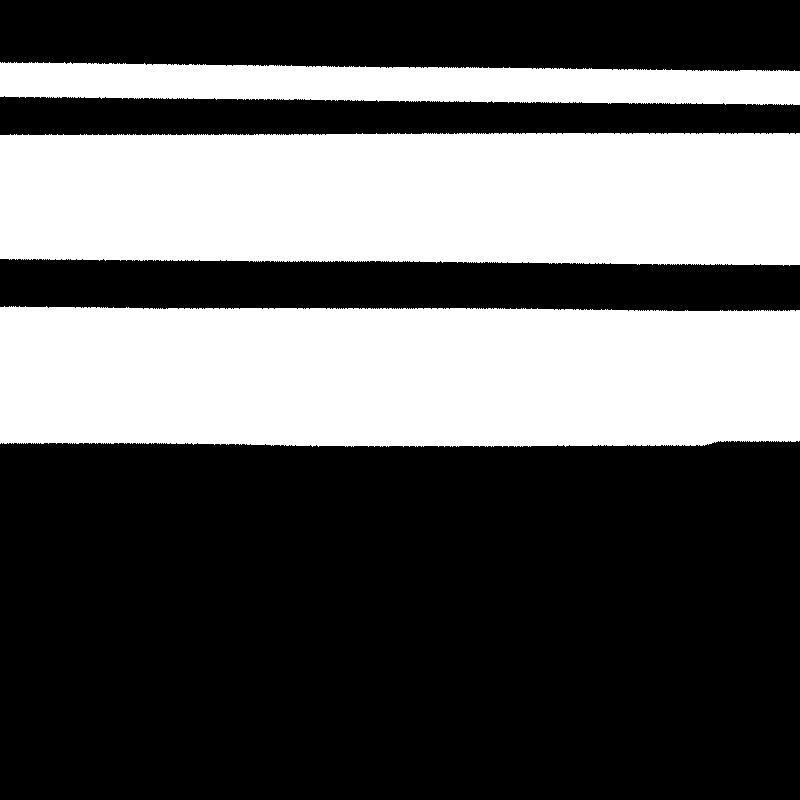

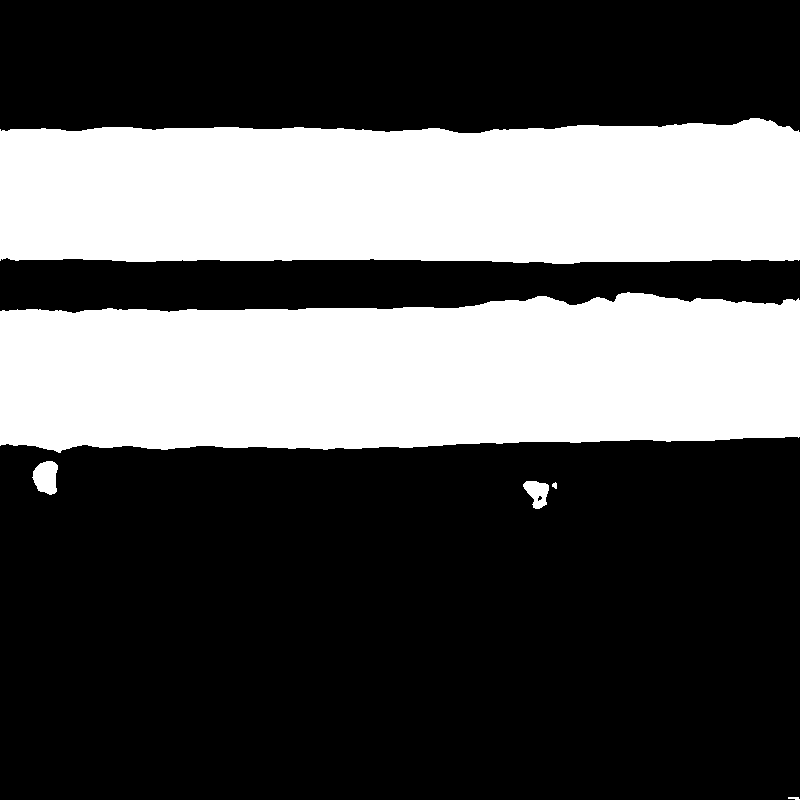

epoch 45, iter 0: 0.01411229558289051
epoch 45, iter 20: 0.014825018122792244
epoch 45, iter 40: 0.014422304928302765
epoch 45, iter 60: 0.018373701721429825
epoch 45, iter 80: 0.012342157773673534
epoch 45, iter 100: 0.010341914370656013
epoch 45, iter 120: 0.018098095431923866
epoch 45, iter 140: 0.016589943319559097
epoch 45, iter 160: 0.009202433750033379
epoch 45, iter 180: 0.012642033398151398
epoch 45, iter 200: 0.012098865583539009
epoch 45, iter 220: 0.010016177780926228
epoch 45, iter 240: 0.014104287140071392
epoch 45, iter 260: 0.01597815752029419
epoch 45, iter 280: 0.010210730135440826
epoch 45, iter 300: 0.01582472398877144
validation epoch 45: 0.08579035103321075


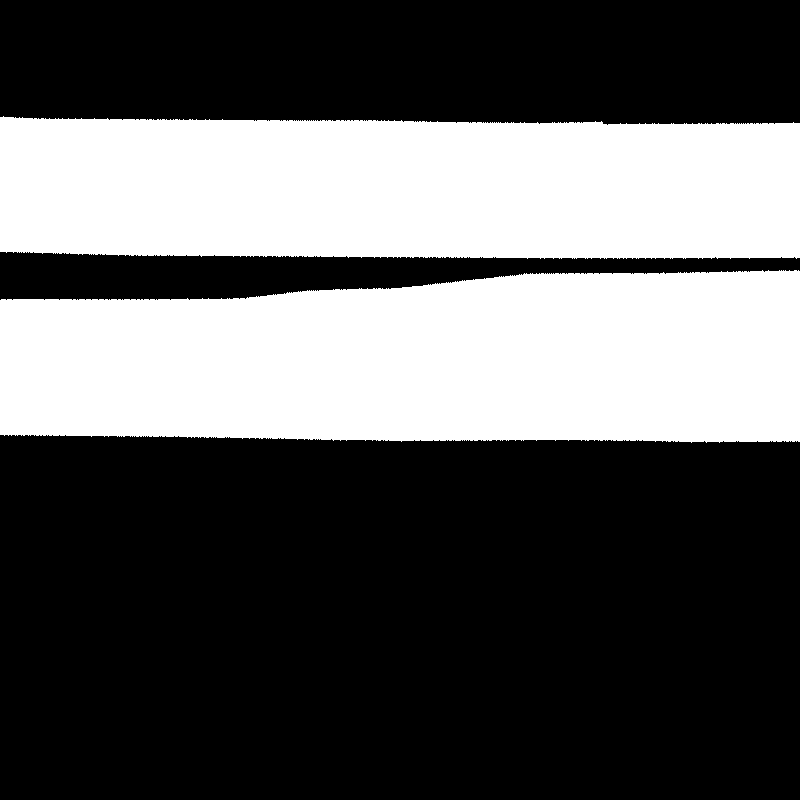

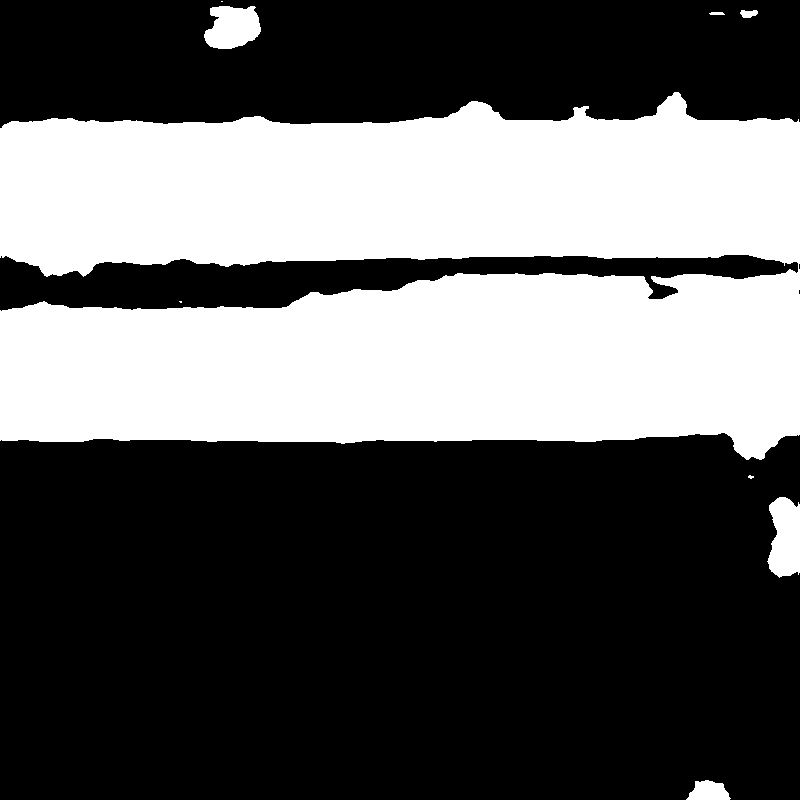

epoch 46, iter 0: 0.015607696026563644
epoch 46, iter 20: 0.010693354532122612
epoch 46, iter 40: 0.01525439228862524
epoch 46, iter 60: 0.011779981665313244
epoch 46, iter 80: 0.015272432938218117
epoch 46, iter 100: 0.014875209890305996
epoch 46, iter 120: 0.012835245579481125
epoch 46, iter 140: 0.018359487876296043
epoch 46, iter 160: 0.014145205728709698
epoch 46, iter 180: 0.012307011522352695
epoch 46, iter 200: 0.013895980082452297
epoch 46, iter 220: 0.016219858080148697
epoch 46, iter 240: 0.013719161972403526
epoch 46, iter 260: 0.015153820626437664
epoch 46, iter 280: 0.0158822163939476
epoch 46, iter 300: 0.018237844109535217
validation epoch 46: 0.08687916398048401


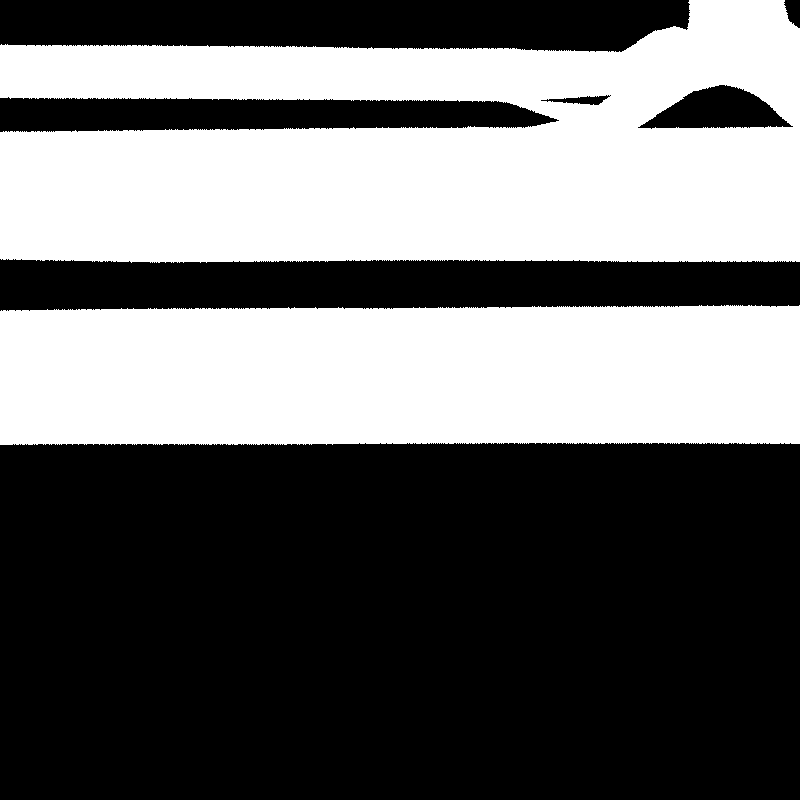

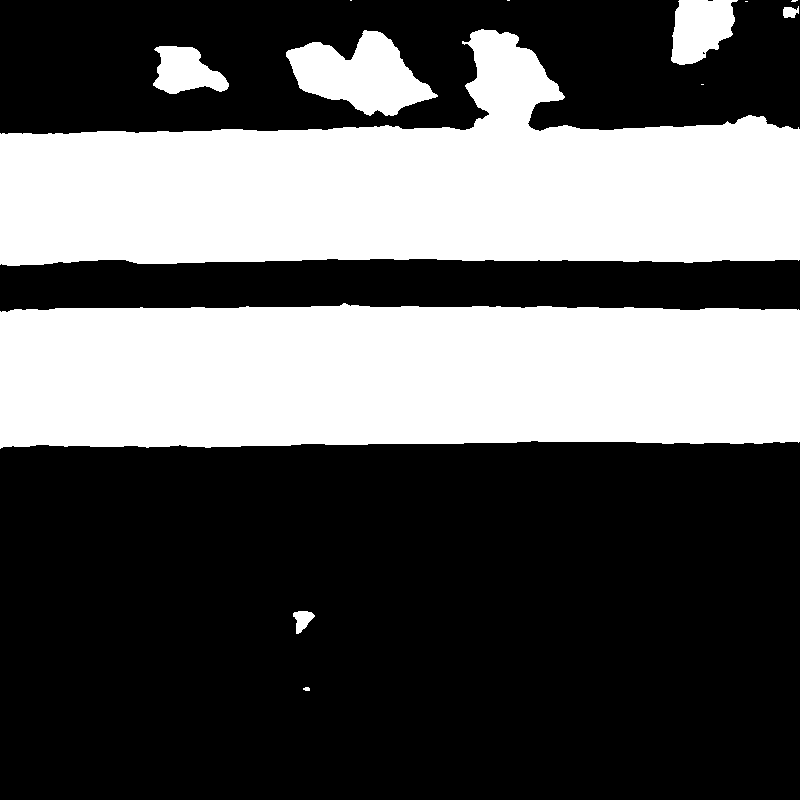

epoch 47, iter 0: 0.011856409721076488
epoch 47, iter 20: 0.013586398214101791
epoch 47, iter 40: 0.019792184233665466
epoch 47, iter 60: 0.017458995804190636
epoch 47, iter 80: 0.009314454160630703
epoch 47, iter 100: 0.013947253115475178
epoch 47, iter 120: 0.017729613929986954
epoch 47, iter 140: 0.020109018310904503
epoch 47, iter 160: 0.014458857476711273
epoch 47, iter 180: 0.012971383519470692
epoch 47, iter 200: 0.016093067824840546
epoch 47, iter 220: 0.0071259490214288235
epoch 47, iter 240: 0.013360506854951382
epoch 47, iter 260: 0.01584767736494541
epoch 47, iter 280: 0.019364306703209877
epoch 47, iter 300: 0.014096630737185478
validation epoch 47: 0.0884818285703659


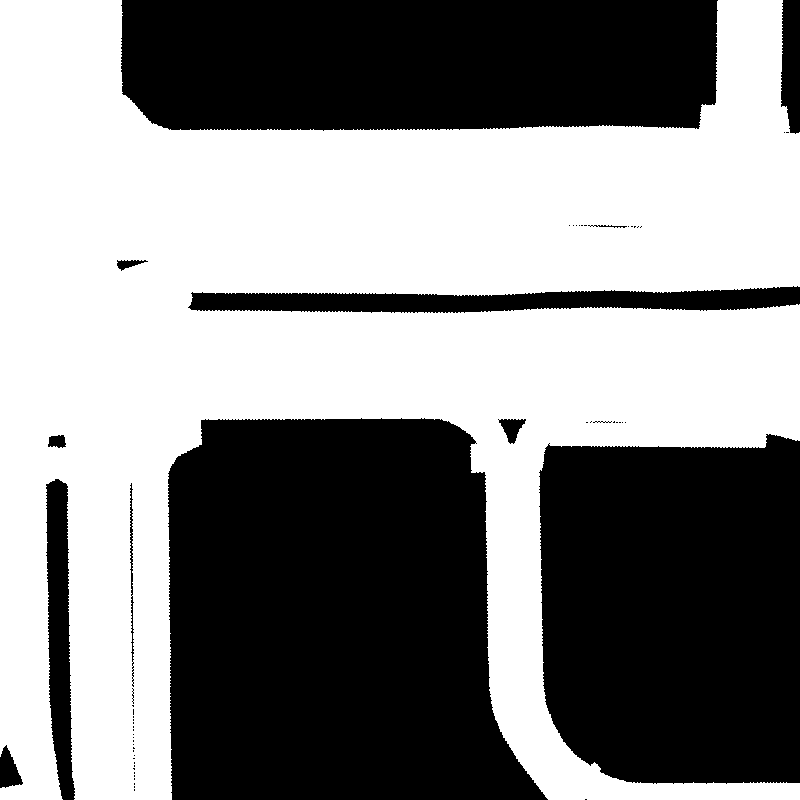

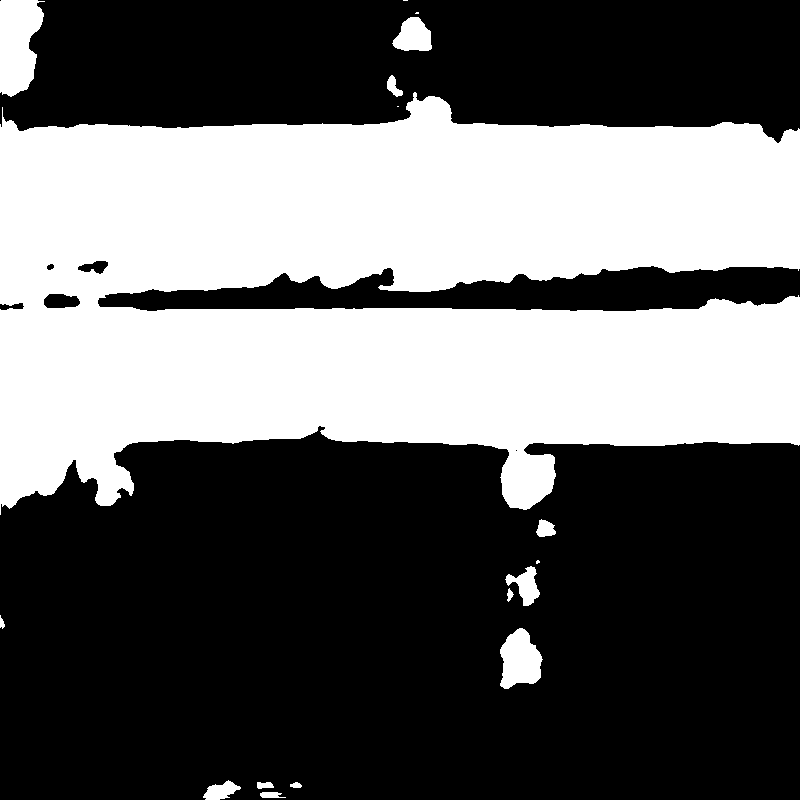

epoch 48, iter 0: 0.013577062636613846
epoch 48, iter 20: 0.012391549535095692
epoch 48, iter 40: 0.016628164798021317
epoch 48, iter 60: 0.013073809444904327
epoch 48, iter 80: 0.017396753653883934
epoch 48, iter 100: 0.01291680708527565
epoch 48, iter 120: 0.006826189812272787
epoch 48, iter 140: 0.012152005918323994
epoch 48, iter 160: 0.01180140022188425
epoch 48, iter 180: 0.008059121668338776
epoch 48, iter 200: 0.014271842315793037
epoch 48, iter 220: 0.014128446578979492
epoch 48, iter 240: 0.014606594108045101
epoch 48, iter 260: 0.013049880973994732
epoch 48, iter 280: 0.010241217911243439
epoch 48, iter 300: 0.015173055231571198
validation epoch 48: 0.08598336577415466


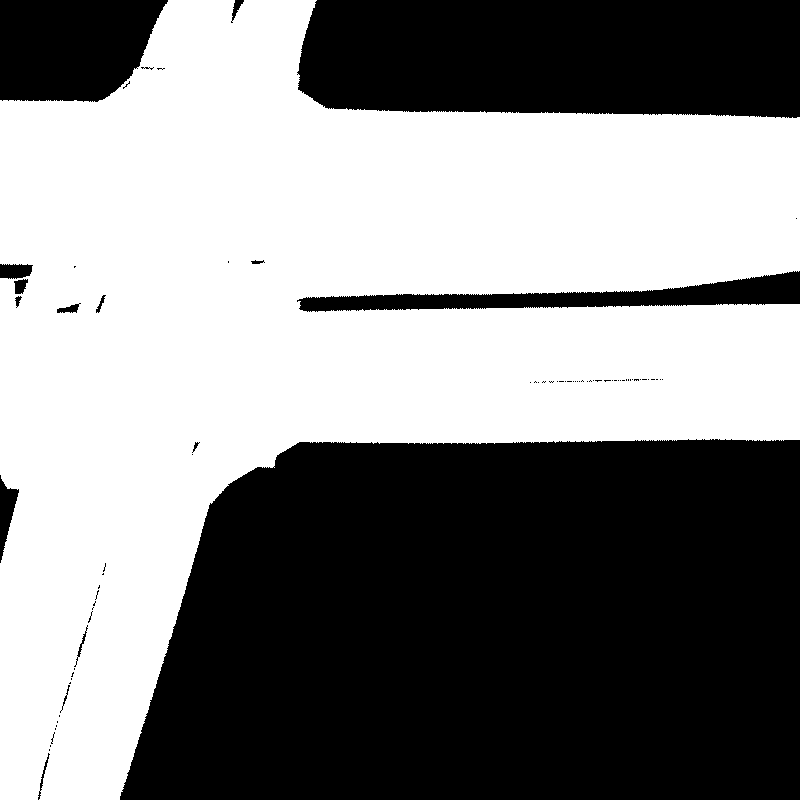

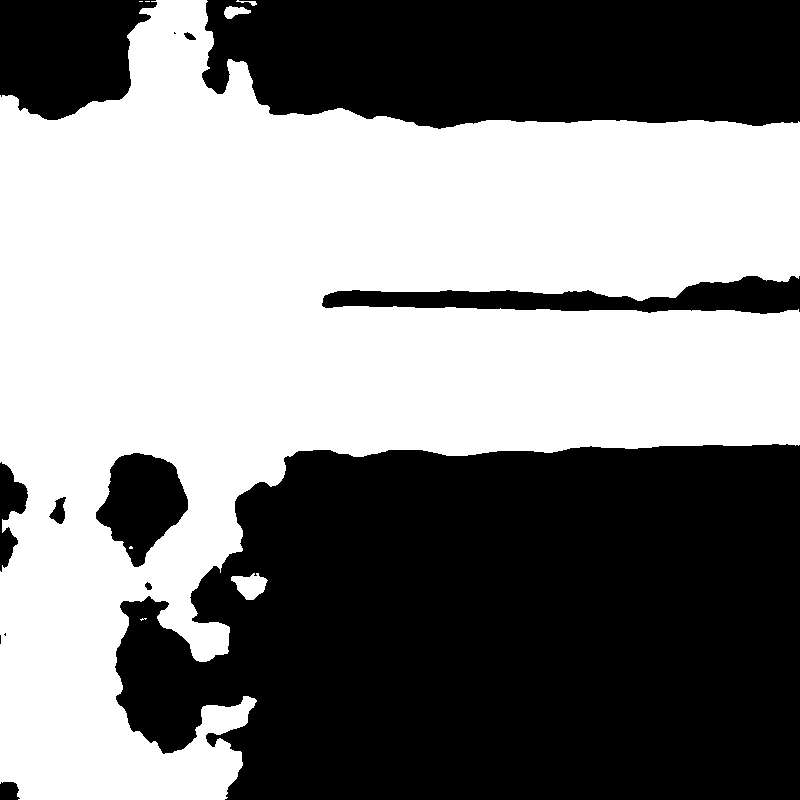

epoch 49, iter 0: 0.01480895932763815
epoch 49, iter 20: 0.0144880386069417
epoch 49, iter 40: 0.012471853755414486
epoch 49, iter 60: 0.01684020832180977
epoch 49, iter 80: 0.014436913654208183
epoch 49, iter 100: 0.015295944176614285
epoch 49, iter 120: 0.01929348334670067
epoch 49, iter 140: 0.014050555415451527
epoch 49, iter 160: 0.015828944742679596
epoch 49, iter 180: 0.01756683550775051
epoch 49, iter 200: 0.014702904969453812
epoch 49, iter 220: 0.014754190109670162
epoch 49, iter 240: 0.01666281186044216
epoch 49, iter 260: 0.011240046471357346
epoch 49, iter 280: 0.015860872343182564
epoch 49, iter 300: 0.009851614013314247
validation epoch 49: 0.08709942549467087


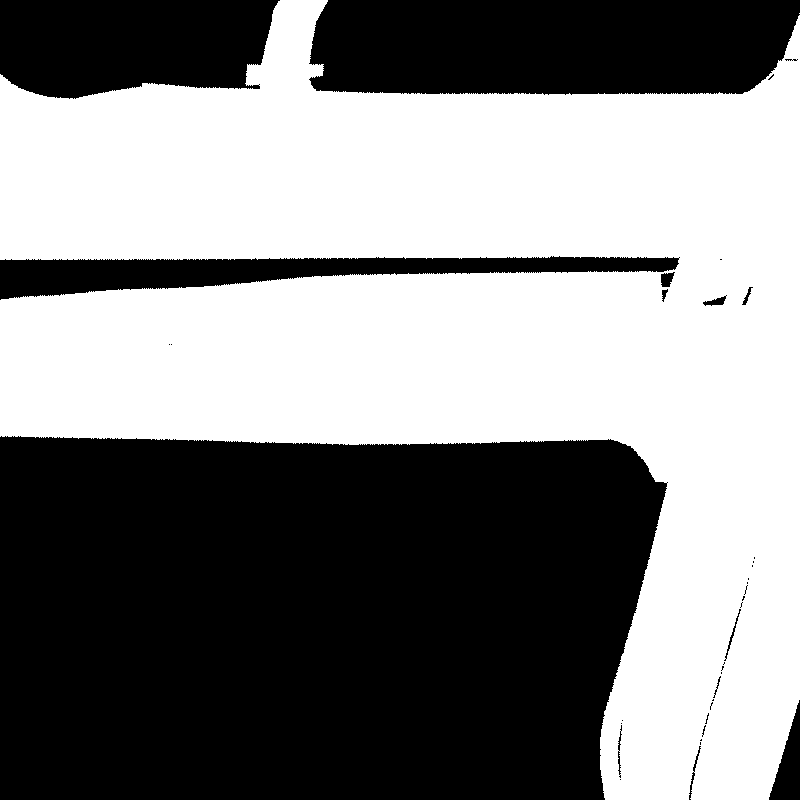

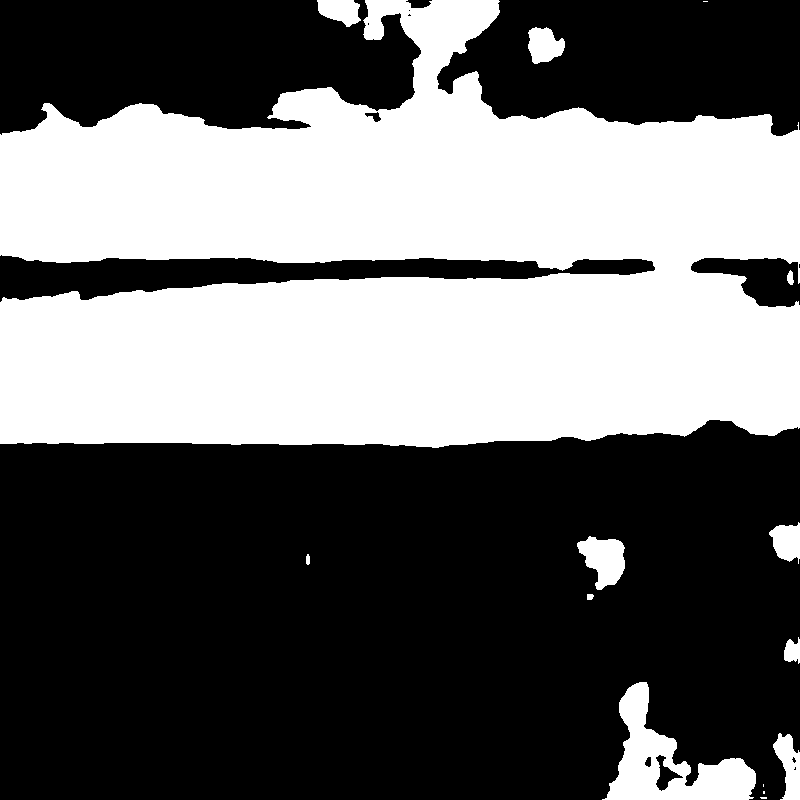

epoch 50, iter 0: 0.019651206210255623
epoch 50, iter 20: 0.011471959762275219
epoch 50, iter 40: 0.011685897596180439
epoch 50, iter 60: 0.01400744915008545
epoch 50, iter 80: 0.012036493048071861
epoch 50, iter 100: 0.012034326791763306
epoch 50, iter 120: 0.01429713424295187
epoch 50, iter 140: 0.012080206535756588
epoch 50, iter 160: 0.007739877328276634
epoch 50, iter 180: 0.013351397588849068
epoch 50, iter 200: 0.01164290588349104
epoch 50, iter 220: 0.009218520484864712
epoch 50, iter 240: 0.011972255073487759
epoch 50, iter 260: 0.00941719301044941
epoch 50, iter 280: 0.010678067803382874
epoch 50, iter 300: 0.011227629147469997
validation epoch 50: 0.08625000715255737


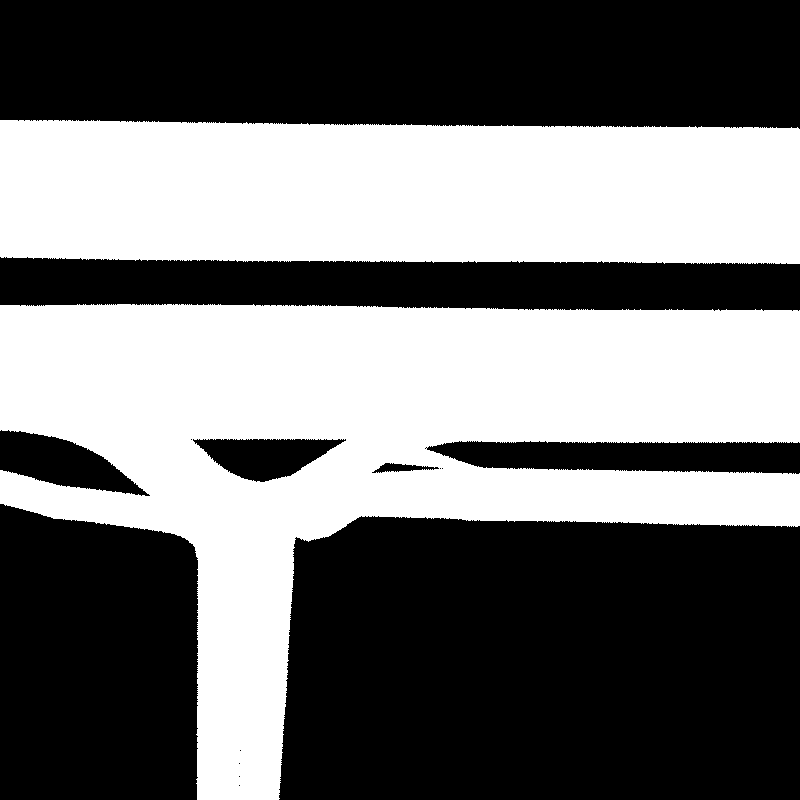

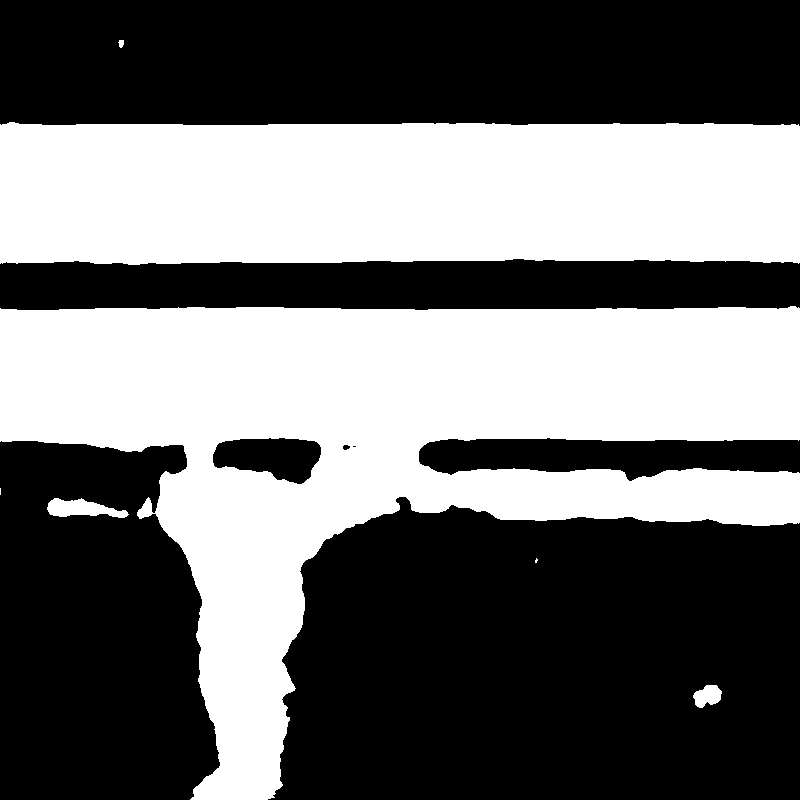

epoch 51, iter 0: 0.011318969540297985
epoch 51, iter 20: 0.01415779534727335
epoch 51, iter 40: 0.013729210011661053
epoch 51, iter 60: 0.0146213723346591
epoch 51, iter 80: 0.00883618276566267
epoch 51, iter 100: 0.014119908213615417
epoch 51, iter 120: 0.017934387549757957
epoch 51, iter 140: 0.016725264489650726
epoch 51, iter 160: 0.017869148403406143
epoch 51, iter 180: 0.013868841342628002
epoch 51, iter 200: 0.009384619072079659
epoch 51, iter 220: 0.014377924613654613
epoch 51, iter 240: 0.014159765094518661
epoch 51, iter 260: 0.013962344266474247
epoch 51, iter 280: 0.012499714270234108
epoch 51, iter 300: 0.013830384239554405
validation epoch 51: 0.08566136658191681


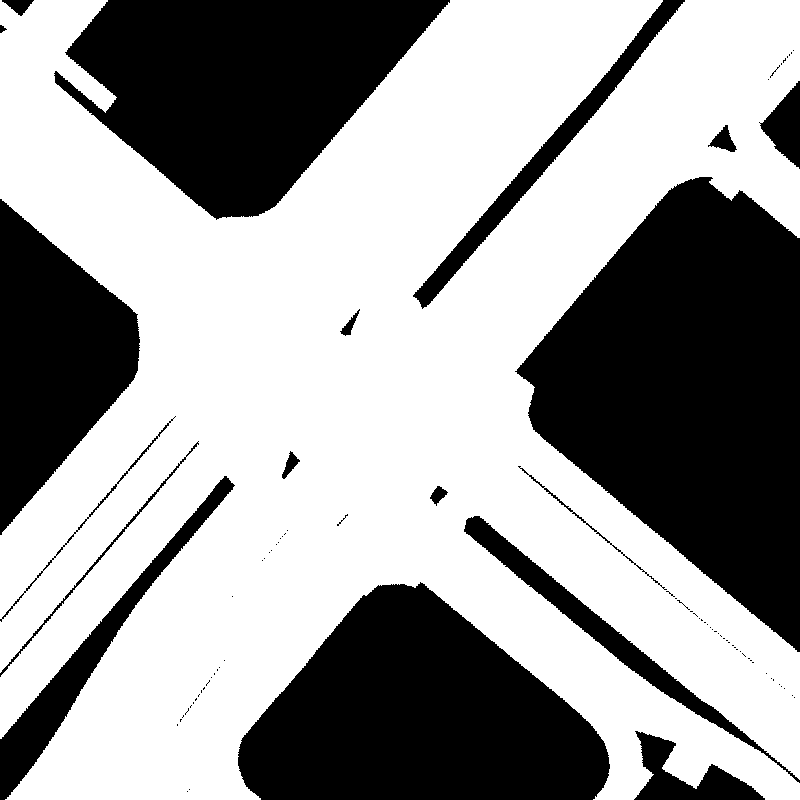

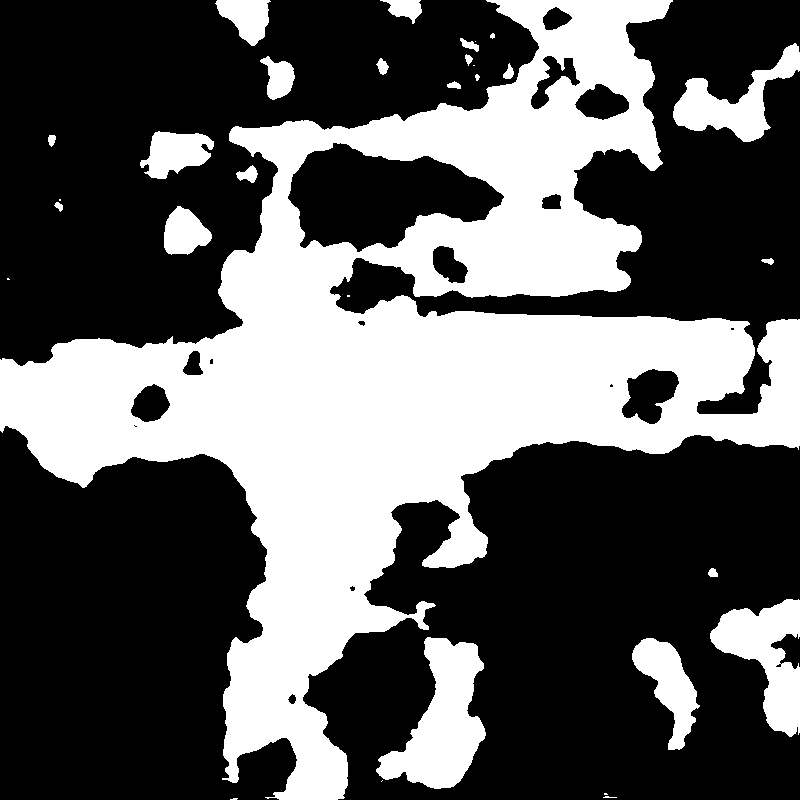

epoch 52, iter 0: 0.013554824516177177
epoch 52, iter 20: 0.01620067097246647
epoch 52, iter 40: 0.01568402536213398
epoch 52, iter 60: 0.013845566660165787
epoch 52, iter 80: 0.016505884006619453
epoch 52, iter 100: 0.01566133089363575
epoch 52, iter 120: 0.014690850861370564
epoch 52, iter 140: 0.011000663042068481
epoch 52, iter 160: 0.017072780057787895
epoch 52, iter 180: 0.01656251773238182
epoch 52, iter 200: 0.014318997971713543
epoch 52, iter 220: 0.01063085813075304
epoch 52, iter 240: 0.013895878568291664
epoch 52, iter 260: 0.008995911106467247
epoch 52, iter 280: 0.009375790134072304
epoch 52, iter 300: 0.015353774651885033
validation epoch 52: 0.0863087922334671


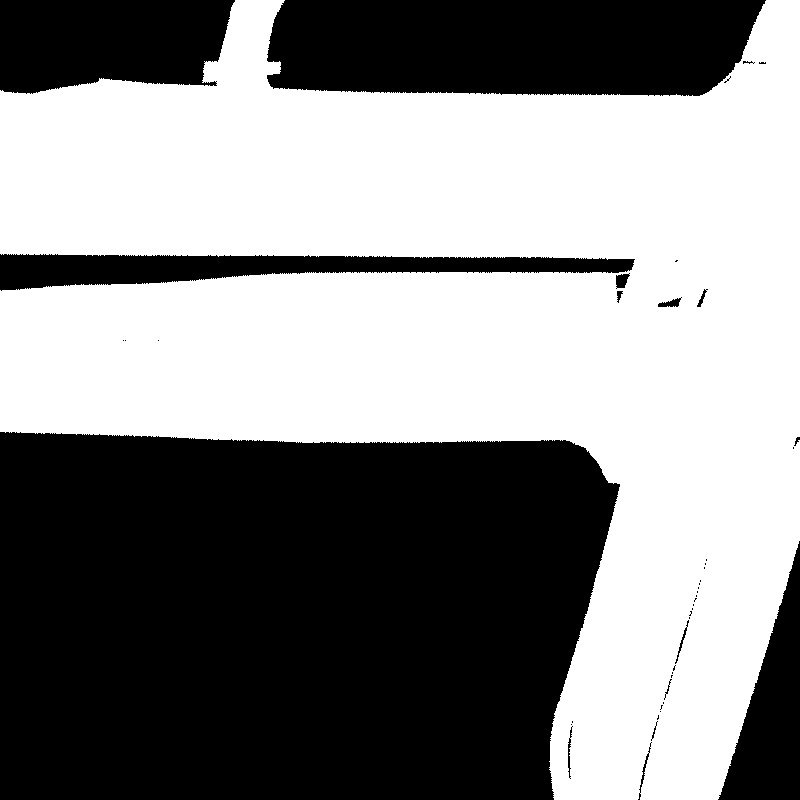

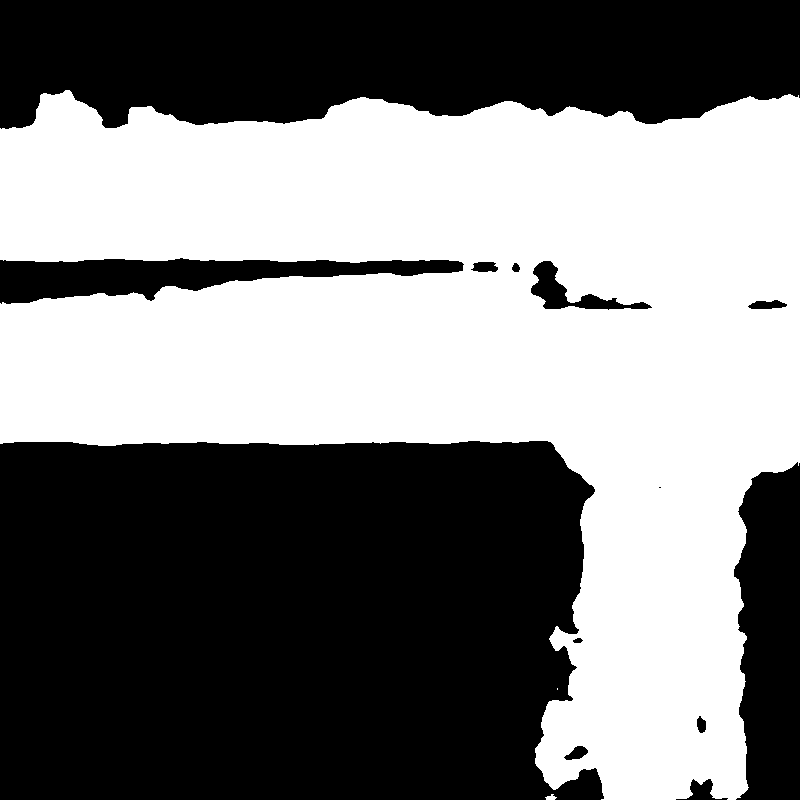

epoch 53, iter 0: 0.009041561745107174
epoch 53, iter 20: 0.01183817908167839
epoch 53, iter 40: 0.014529624953866005
epoch 53, iter 60: 0.011169204488396645
epoch 53, iter 80: 0.014877943322062492
epoch 53, iter 100: 0.013666870072484016
epoch 53, iter 120: 0.012787584215402603
epoch 53, iter 140: 0.00973622128367424
epoch 53, iter 160: 0.01141378004103899
epoch 53, iter 180: 0.009817417711019516
epoch 53, iter 200: 0.012952465564012527
epoch 53, iter 220: 0.01515701599419117
epoch 53, iter 240: 0.013721656054258347
epoch 53, iter 260: 0.010032013058662415
epoch 53, iter 280: 0.01038572657853365
epoch 53, iter 300: 0.01537071168422699
validation epoch 53: 0.08827148377895355


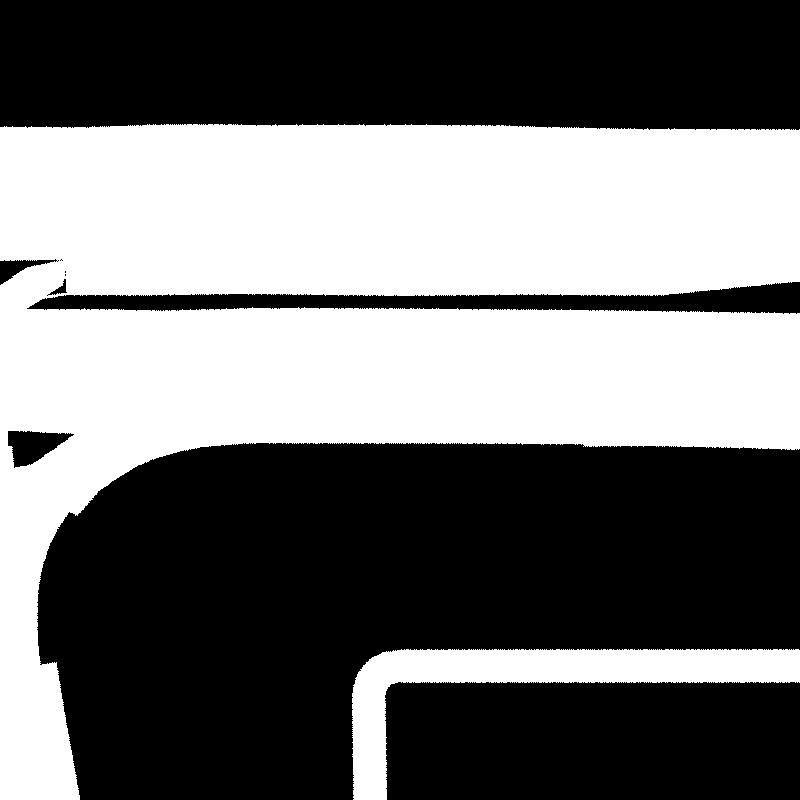

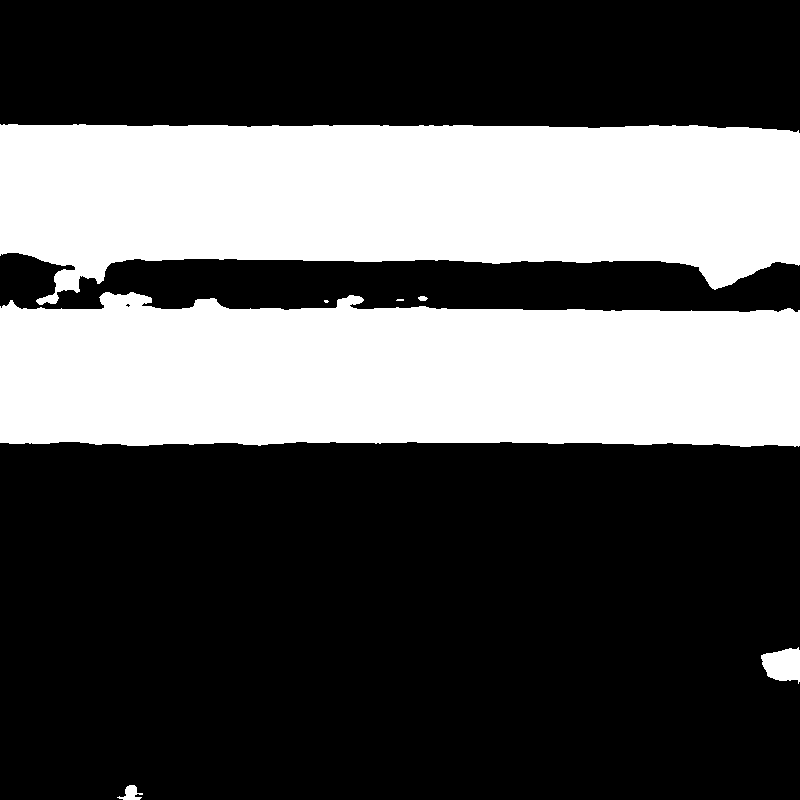

epoch 54, iter 0: 0.013936654664576054
epoch 54, iter 20: 0.014916784130036831
epoch 54, iter 40: 0.013444563373923302
epoch 54, iter 60: 0.00975033175200224
epoch 54, iter 80: 0.010821453295648098
epoch 54, iter 100: 0.013167266733944416
epoch 54, iter 120: 0.013676010072231293
epoch 54, iter 140: 0.014983873814344406
epoch 54, iter 160: 0.014294720254838467
epoch 54, iter 180: 0.013091099448502064
epoch 54, iter 200: 0.010664797388017178
epoch 54, iter 220: 0.013378234580159187
epoch 54, iter 240: 0.010331245139241219
epoch 54, iter 260: 0.012484027072787285
epoch 54, iter 280: 0.014472953043878078
epoch 54, iter 300: 0.014667791314423084
validation epoch 54: 0.08482202142477036


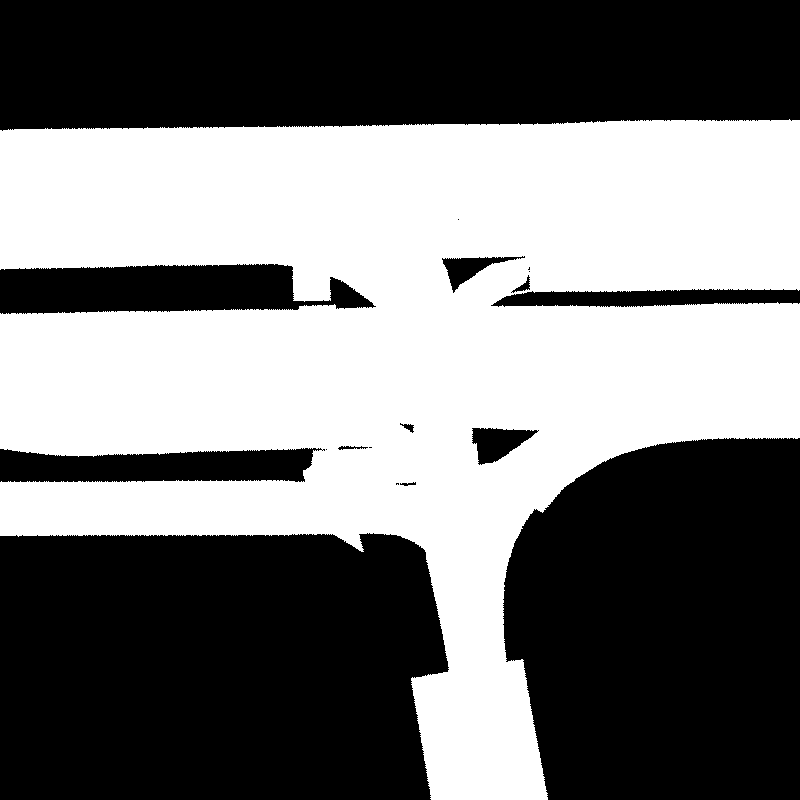

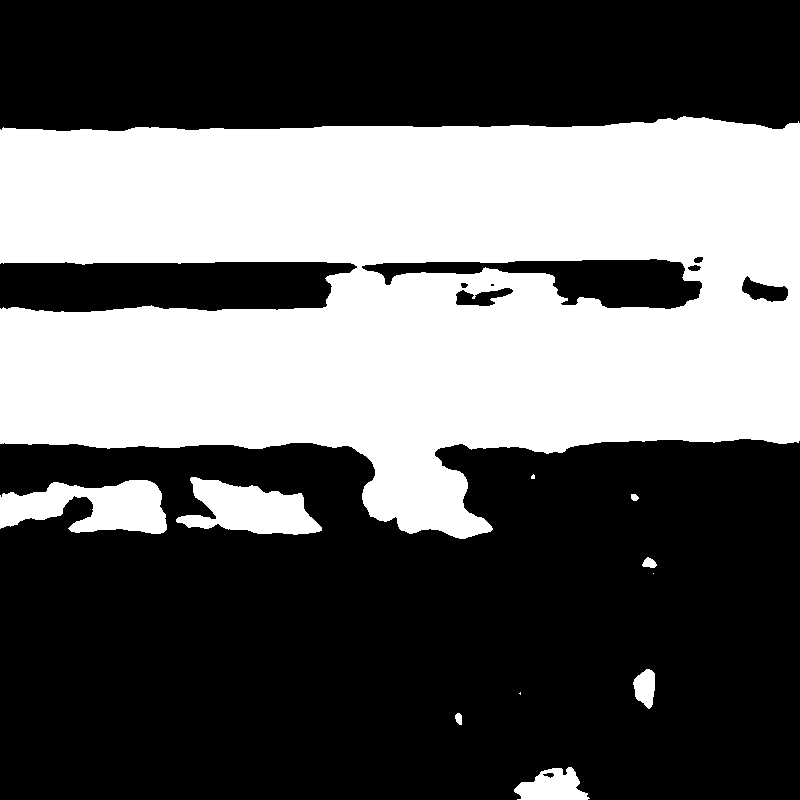

epoch 55, iter 0: 0.012181974947452545
epoch 55, iter 20: 0.01153233926743269
epoch 55, iter 40: 0.011586957611143589
epoch 55, iter 60: 0.009674359112977982
epoch 55, iter 80: 0.013337680138647556
epoch 55, iter 100: 0.014749654568731785
epoch 55, iter 120: 0.01496542152017355
epoch 55, iter 140: 0.018898282200098038
epoch 55, iter 160: 0.014420577324926853
epoch 55, iter 180: 0.014268775470554829
epoch 55, iter 200: 0.01332803349941969
epoch 55, iter 220: 0.00939355231821537
epoch 55, iter 240: 0.013647979125380516
epoch 55, iter 260: 0.01730179972946644
epoch 55, iter 280: 0.010952253825962543
epoch 55, iter 300: 0.01135418564081192
validation epoch 55: 0.08502878248691559


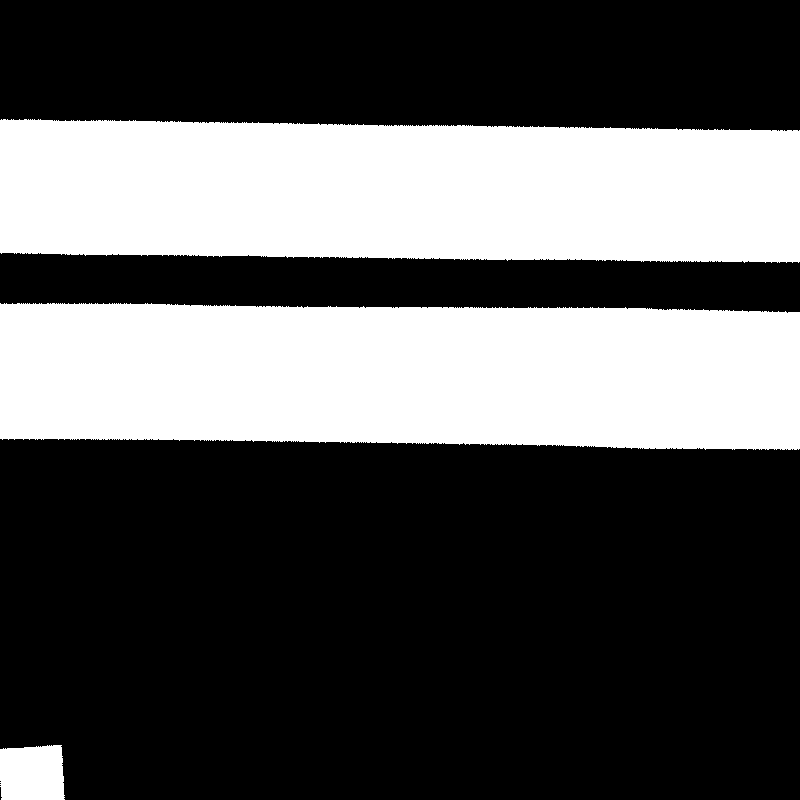

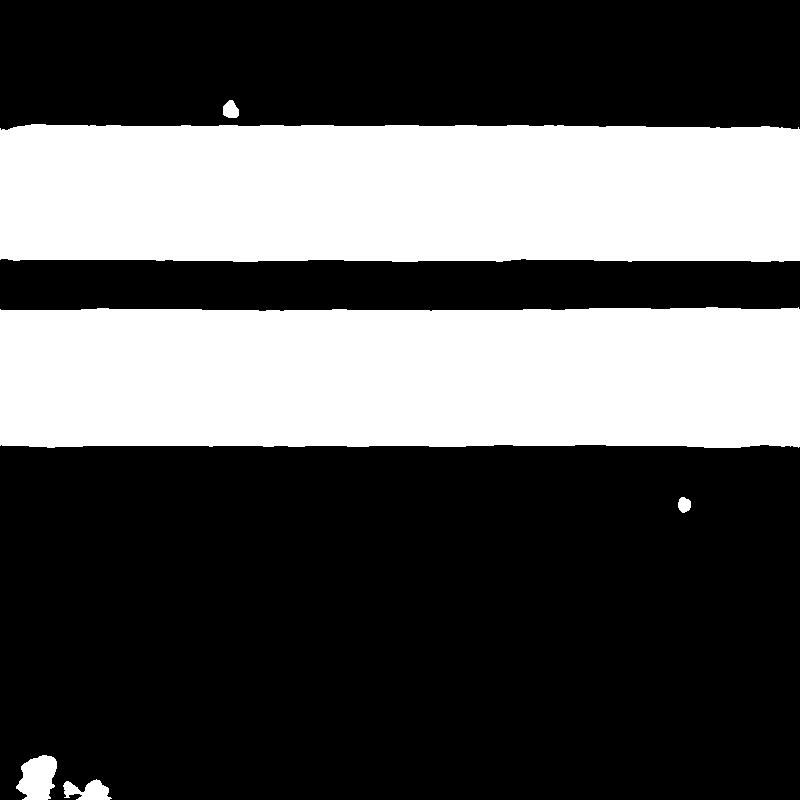

epoch 56, iter 0: 0.011497781611979008
epoch 56, iter 20: 0.007800086867064238
epoch 56, iter 40: 0.011085426434874535
epoch 56, iter 60: 0.008197802118957043
epoch 56, iter 80: 0.012897377833724022
epoch 56, iter 100: 0.01615631952881813
epoch 56, iter 120: 0.011948937550187111
epoch 56, iter 140: 0.01104215532541275
epoch 56, iter 160: 0.01459169015288353
epoch 56, iter 180: 0.01300389040261507
epoch 56, iter 200: 0.010533295571804047
epoch 56, iter 220: 0.009978392161428928
epoch 56, iter 240: 0.0188366137444973
epoch 56, iter 260: 0.015867775306105614
epoch 56, iter 280: 0.0121393371373415
epoch 56, iter 300: 0.0145740807056427
validation epoch 56: 0.08707194775342941


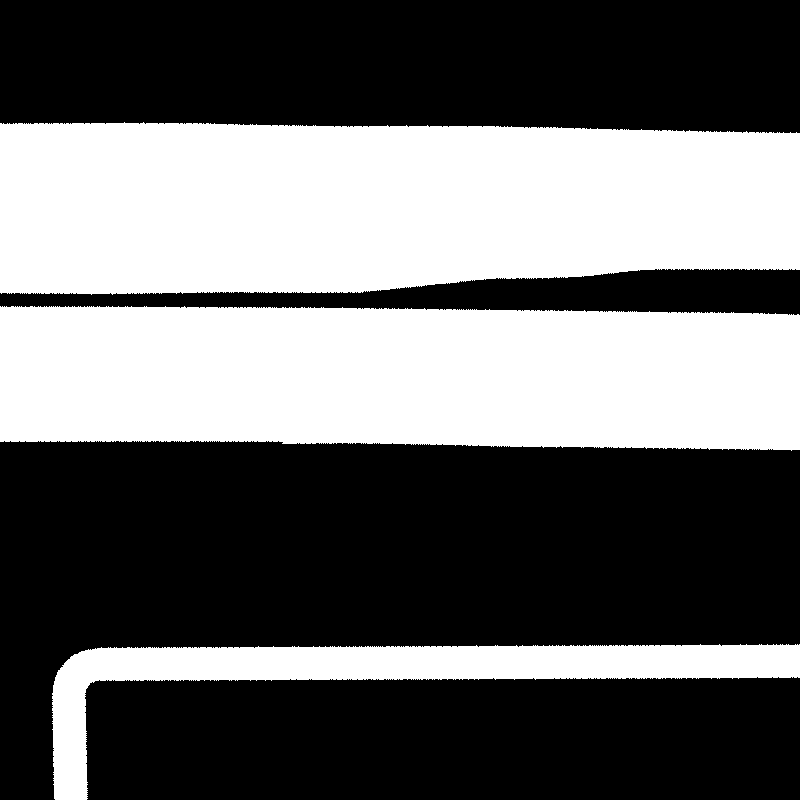

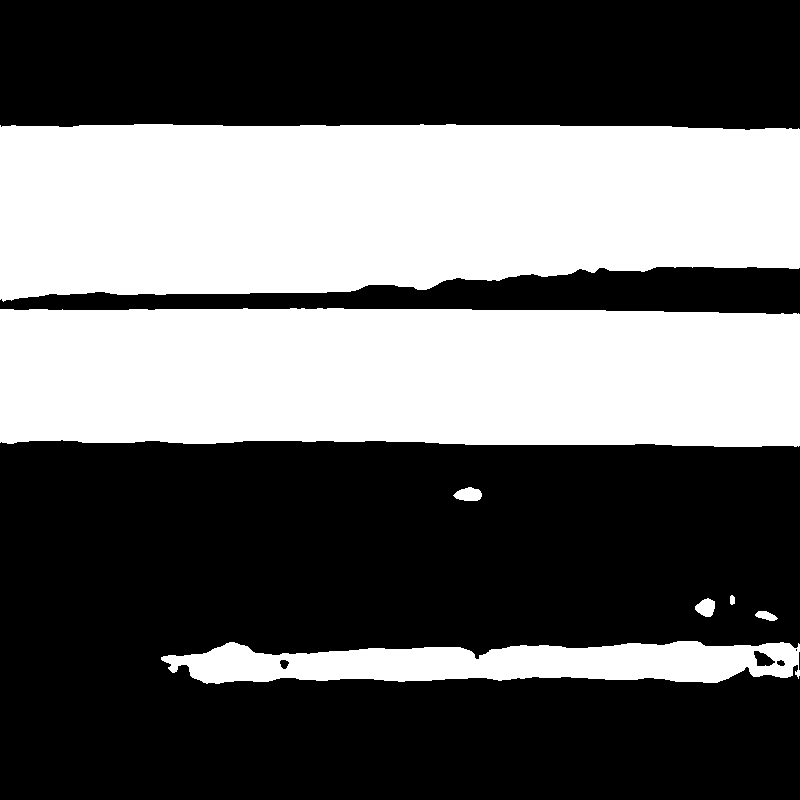

epoch 57, iter 0: 0.008072094060480595
epoch 57, iter 20: 0.01140722818672657
epoch 57, iter 40: 0.011313998140394688
epoch 57, iter 60: 0.012140762060880661
epoch 57, iter 80: 0.011340863071382046
epoch 57, iter 100: 0.009060140699148178
epoch 57, iter 120: 0.012748748995363712
epoch 57, iter 140: 0.011176965199410915
epoch 57, iter 160: 0.009283587336540222
epoch 57, iter 180: 0.01053699292242527
epoch 57, iter 200: 0.014106856659054756
epoch 57, iter 220: 0.010200696997344494
epoch 57, iter 240: 0.012032194063067436
epoch 57, iter 260: 0.012497189454734325
epoch 57, iter 280: 0.013409801758825779
epoch 57, iter 300: 0.018239105120301247
validation epoch 57: 0.09099502861499786


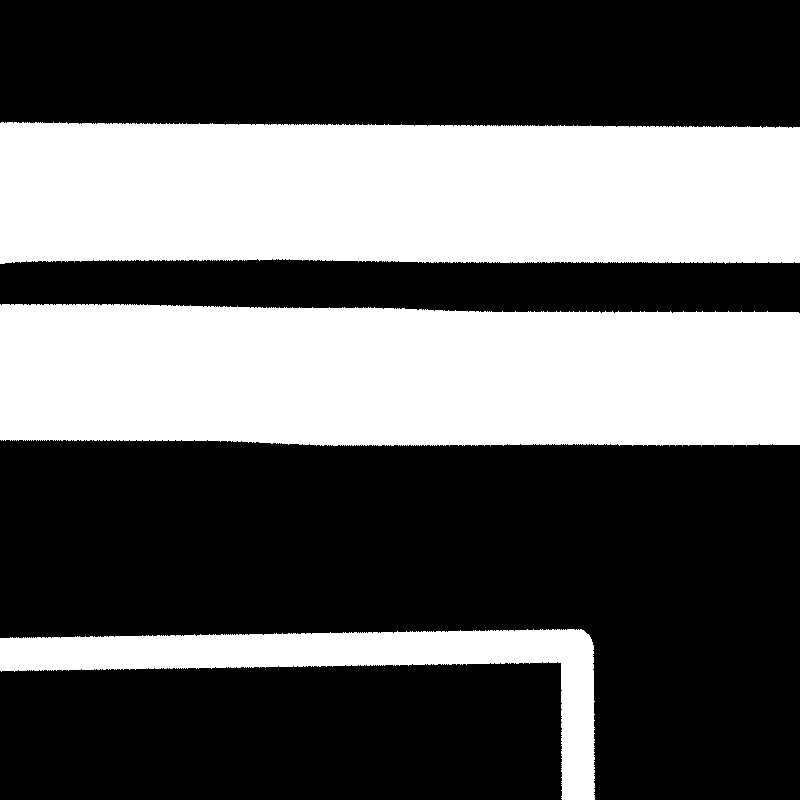

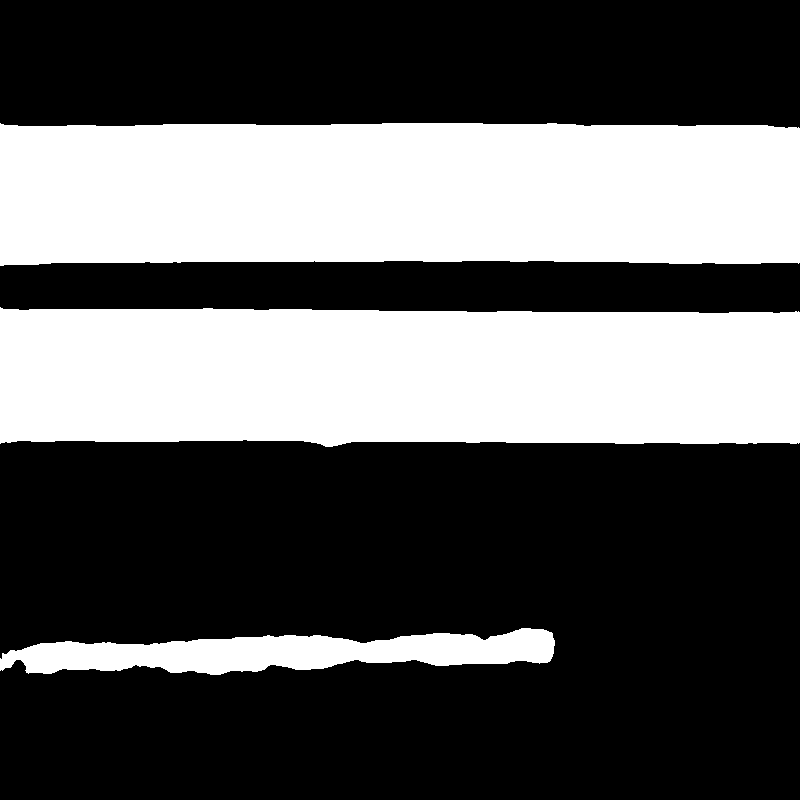

epoch 58, iter 0: 0.01903107948601246
epoch 58, iter 20: 0.011590165086090565
epoch 58, iter 40: 0.009654696099460125
epoch 58, iter 60: 0.010371641255915165
epoch 58, iter 80: 0.01396003644913435
epoch 58, iter 100: 0.013983956538140774
epoch 58, iter 120: 0.011888868175446987
epoch 58, iter 140: 0.009959095157682896
epoch 58, iter 160: 0.012415740638971329
epoch 58, iter 180: 0.015360482037067413
epoch 58, iter 200: 0.016294972971081734
epoch 58, iter 220: 0.01556026004254818
epoch 58, iter 240: 0.011756343767046928
epoch 58, iter 260: 0.01242153625935316
epoch 58, iter 280: 0.011450729332864285
epoch 58, iter 300: 0.010949324816465378
validation epoch 58: 0.08497045934200287


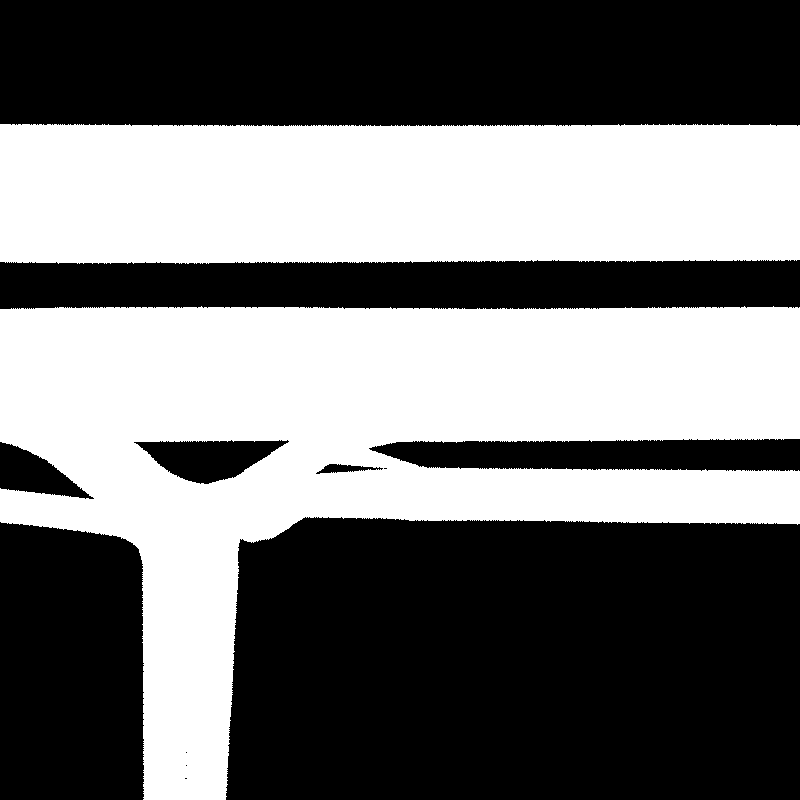

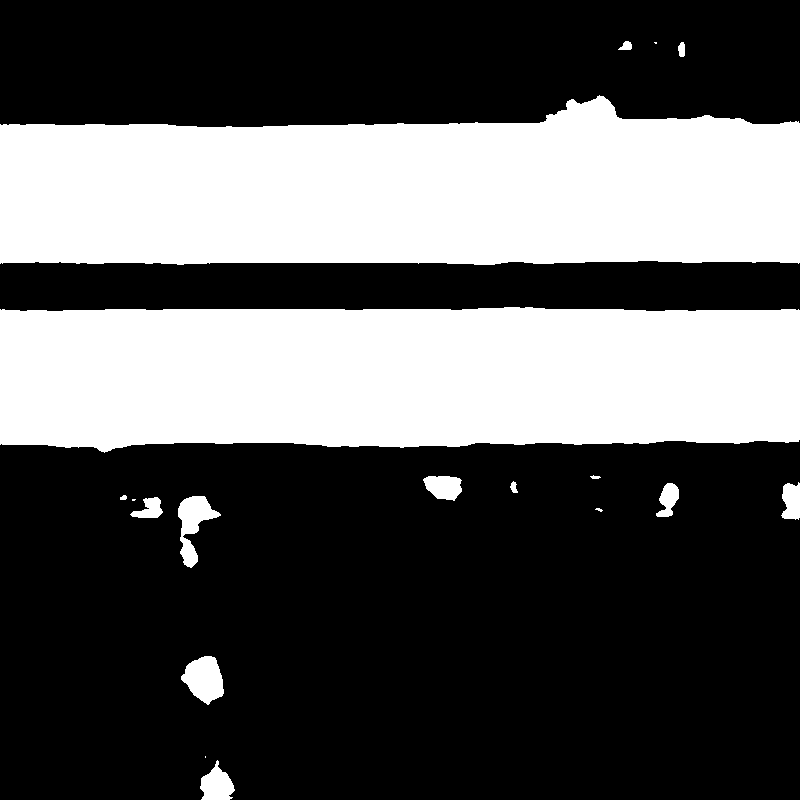

epoch 59, iter 0: 0.012999996542930603
epoch 59, iter 20: 0.00884590856730938
epoch 59, iter 40: 0.014645516872406006
epoch 59, iter 60: 0.010014170780777931
epoch 59, iter 80: 0.016618862748146057
epoch 59, iter 100: 0.01011146791279316
epoch 59, iter 120: 0.014553429558873177
epoch 59, iter 140: 0.013582163490355015
epoch 59, iter 160: 0.014594284817576408
epoch 59, iter 180: 0.015355627052485943
epoch 59, iter 200: 0.012547016143798828
epoch 59, iter 220: 0.012495175935328007
epoch 59, iter 240: 0.008720763958990574
epoch 59, iter 260: 0.012565787881612778
epoch 59, iter 280: 0.01048839371651411
epoch 59, iter 300: 0.010607395321130753
validation epoch 59: 0.09217959642410278


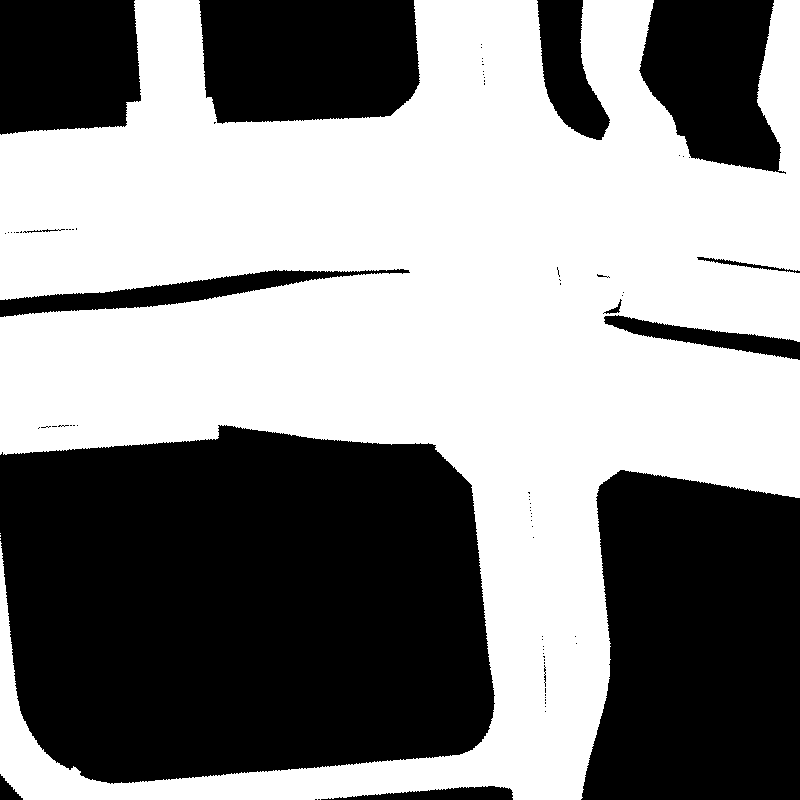

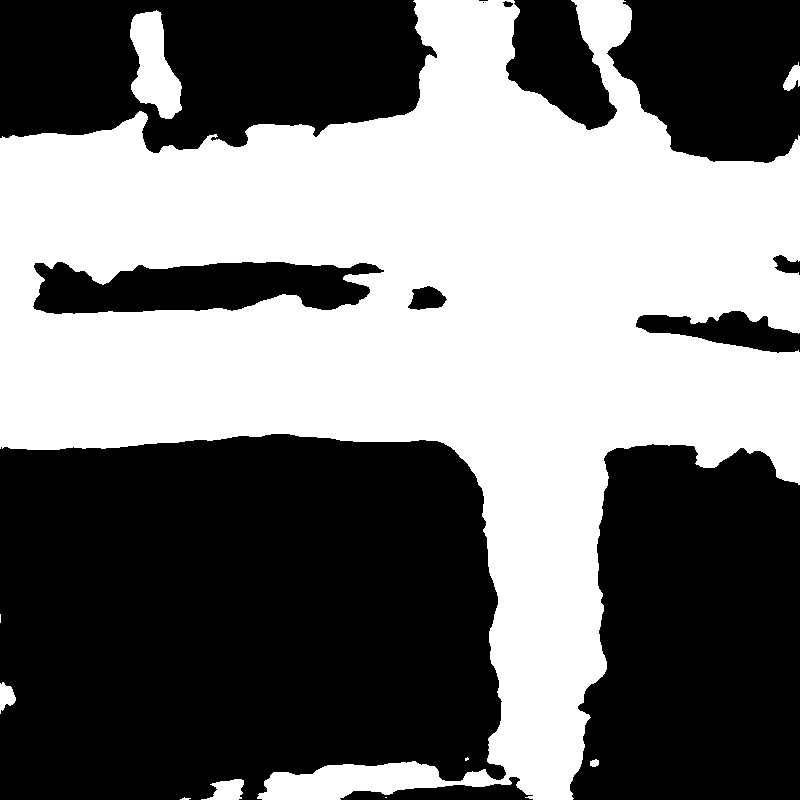

epoch 60, iter 0: 0.00962348747998476
epoch 60, iter 20: 0.00809653289616108
epoch 60, iter 40: 0.00938884075731039
epoch 60, iter 60: 0.014293955639004707
epoch 60, iter 80: 0.011761823669075966
epoch 60, iter 100: 0.013160047121345997
epoch 60, iter 120: 0.008033249527215958
epoch 60, iter 140: 0.012090656906366348
epoch 60, iter 160: 0.012848601676523685
epoch 60, iter 180: 0.010227415710687637
epoch 60, iter 200: 0.01221730187535286
epoch 60, iter 220: 0.01594008505344391
epoch 60, iter 240: 0.007474809885025024
epoch 60, iter 260: 0.013504900969564915
epoch 60, iter 280: 0.011759274639189243
epoch 60, iter 300: 0.012309370562434196
validation epoch 60: 0.08720976859331131


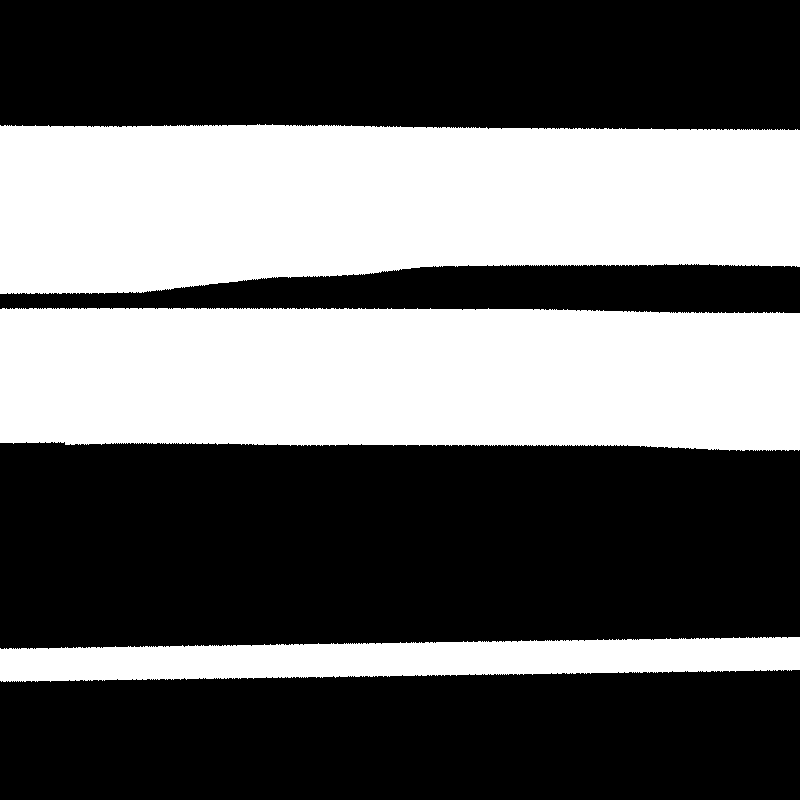

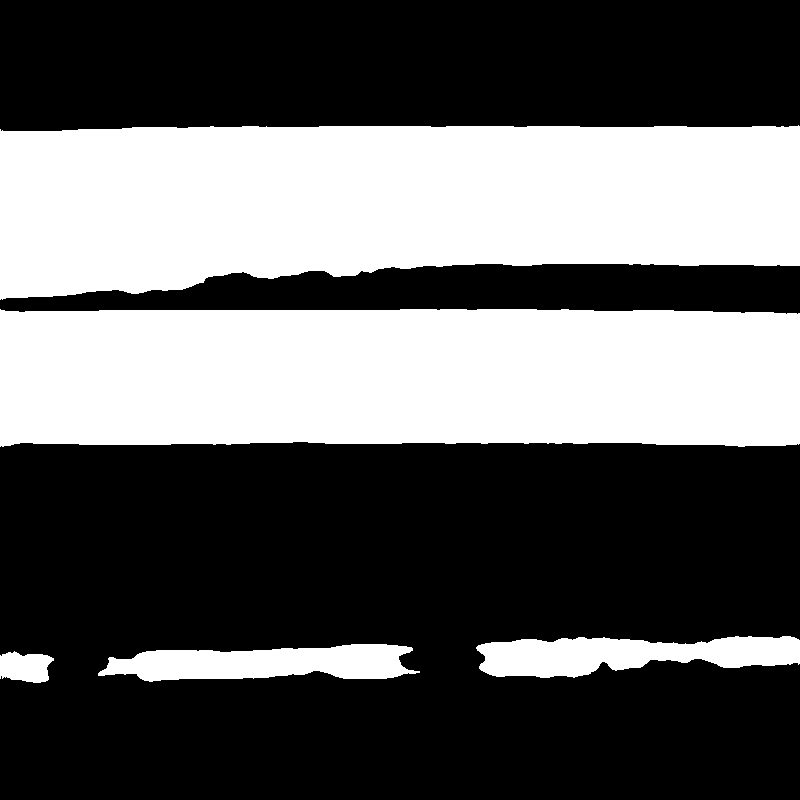

epoch 61, iter 0: 0.007760288659483194
epoch 61, iter 20: 0.008808686397969723
epoch 61, iter 40: 0.013964054174721241
epoch 61, iter 60: 0.01470918208360672
epoch 61, iter 80: 0.01487697847187519
epoch 61, iter 100: 0.014203136786818504
epoch 61, iter 120: 0.010389378294348717
epoch 61, iter 140: 0.00807588454335928
epoch 61, iter 160: 0.009133885614573956
epoch 61, iter 180: 0.012431539595127106
epoch 61, iter 200: 0.015531763434410095
epoch 61, iter 220: 0.013207742013037205
epoch 61, iter 240: 0.013001968152821064
epoch 61, iter 260: 0.01082563679665327
epoch 61, iter 280: 0.009604214690625668
epoch 61, iter 300: 0.014918581582605839
validation epoch 61: 0.08639304339885712


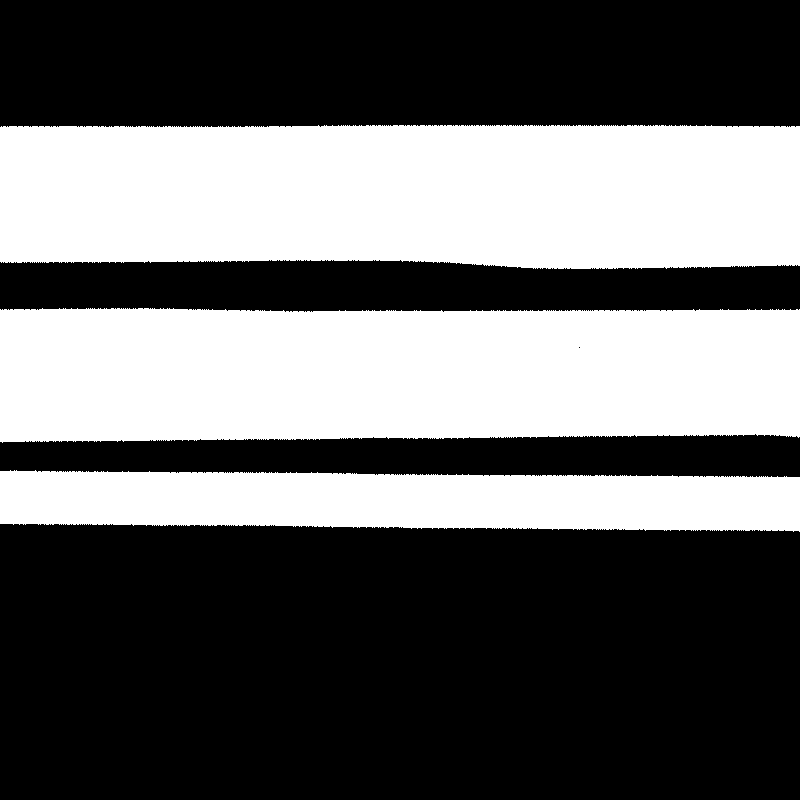

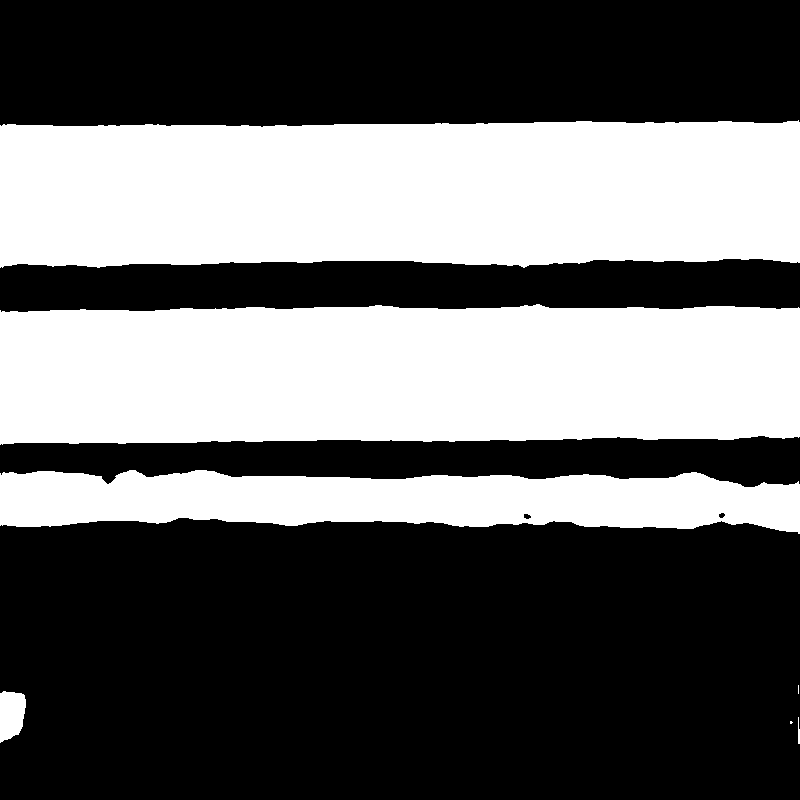

epoch 62, iter 0: 0.011758893728256226
epoch 62, iter 20: 0.011462392285466194
epoch 62, iter 40: 0.01024608127772808
epoch 62, iter 60: 0.013992802239954472
epoch 62, iter 80: 0.015726404264569283
epoch 62, iter 100: 0.008816362358629704
epoch 62, iter 120: 0.011447519063949585
epoch 62, iter 140: 0.012926241382956505
epoch 62, iter 160: 0.011789030395448208
epoch 62, iter 180: 0.009681664407253265
epoch 62, iter 200: 0.015521458350121975
epoch 62, iter 220: 0.014136284589767456
epoch 62, iter 240: 0.012705551460385323
epoch 62, iter 260: 0.00820726715028286
epoch 62, iter 280: 0.013874809257686138
epoch 62, iter 300: 0.010426742024719715
validation epoch 62: 0.08771906793117523


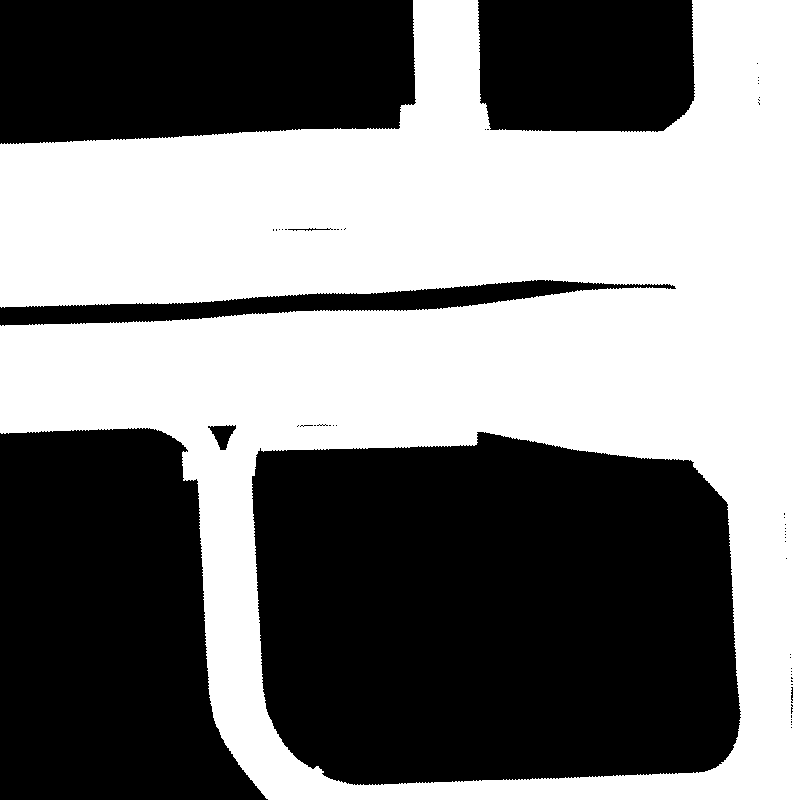

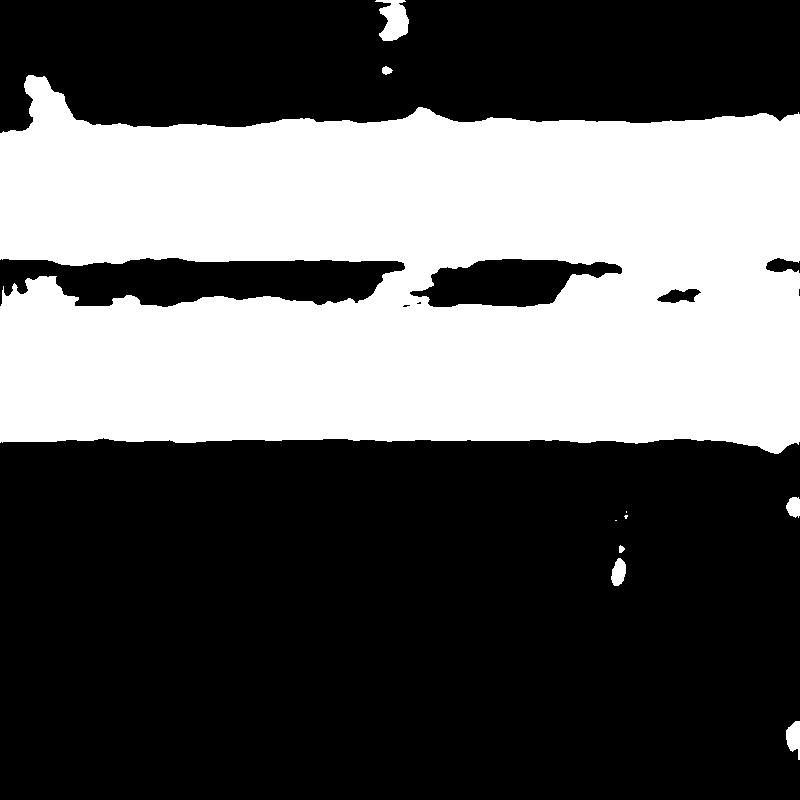

epoch 63, iter 0: 0.010358566418290138
epoch 63, iter 20: 0.0128823546692729
epoch 63, iter 40: 0.013376982882618904
epoch 63, iter 60: 0.00930760707706213
epoch 63, iter 80: 0.008017621003091335
epoch 63, iter 100: 0.01240846049040556
epoch 63, iter 120: 0.010473459959030151
epoch 63, iter 140: 0.009272833354771137
epoch 63, iter 160: 0.012029913254082203
epoch 63, iter 180: 0.010141009464859962
epoch 63, iter 200: 0.009413324296474457
epoch 63, iter 220: 0.010063830763101578
epoch 63, iter 240: 0.012489443644881248
epoch 63, iter 260: 0.012616196647286415
epoch 63, iter 280: 0.009418136440217495
epoch 63, iter 300: 0.010751239024102688
validation epoch 63: 0.08696608990430832


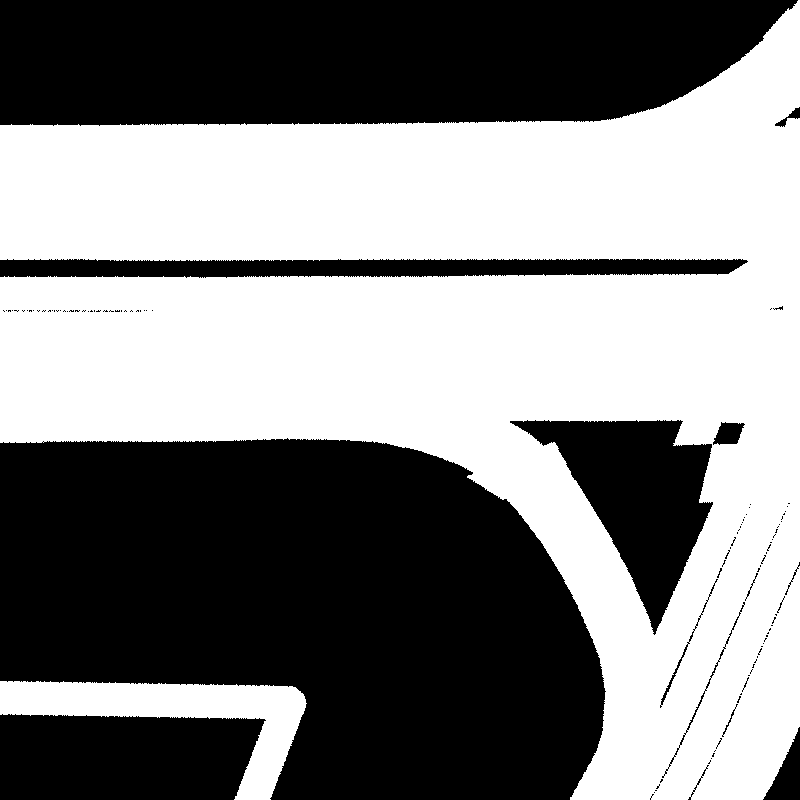

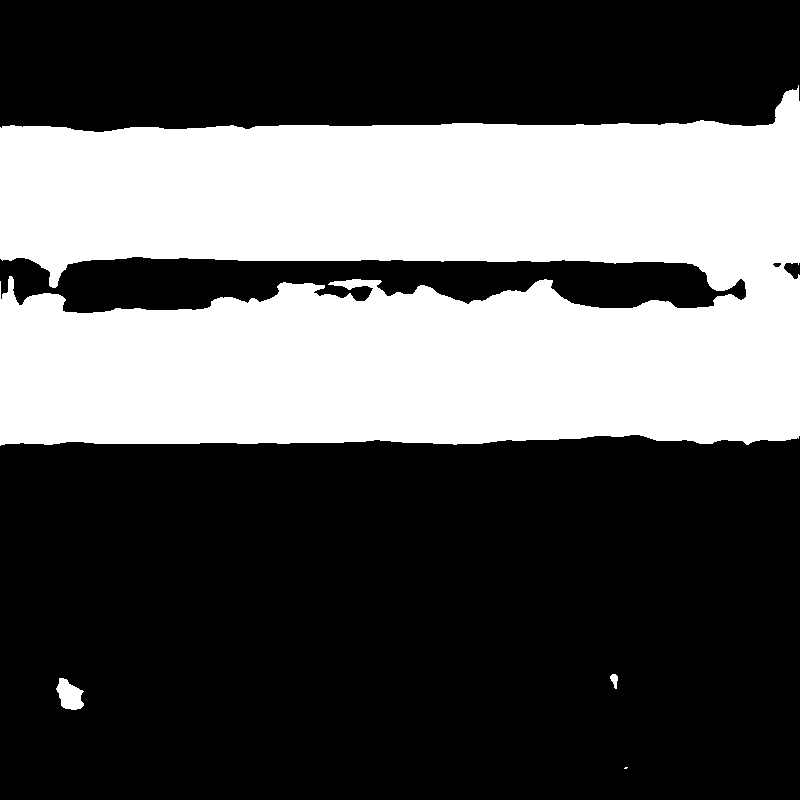

epoch 64, iter 0: 0.012586724944412708
epoch 64, iter 20: 0.00784808024764061
epoch 64, iter 40: 0.010084469802677631
epoch 64, iter 60: 0.009555578231811523
epoch 64, iter 80: 0.008017442189157009
epoch 64, iter 100: 0.009507598355412483
epoch 64, iter 120: 0.011896159499883652
epoch 64, iter 140: 0.012809667736291885
epoch 64, iter 160: 0.010949844494462013
epoch 64, iter 180: 0.018108822405338287
epoch 64, iter 200: 0.014227131381630898
epoch 64, iter 220: 0.007690501399338245
epoch 64, iter 240: 0.012052488513290882
epoch 64, iter 260: 0.014721441082656384
epoch 64, iter 280: 0.00996365211904049
epoch 64, iter 300: 0.012492482550442219
validation epoch 64: 0.08571159094572067


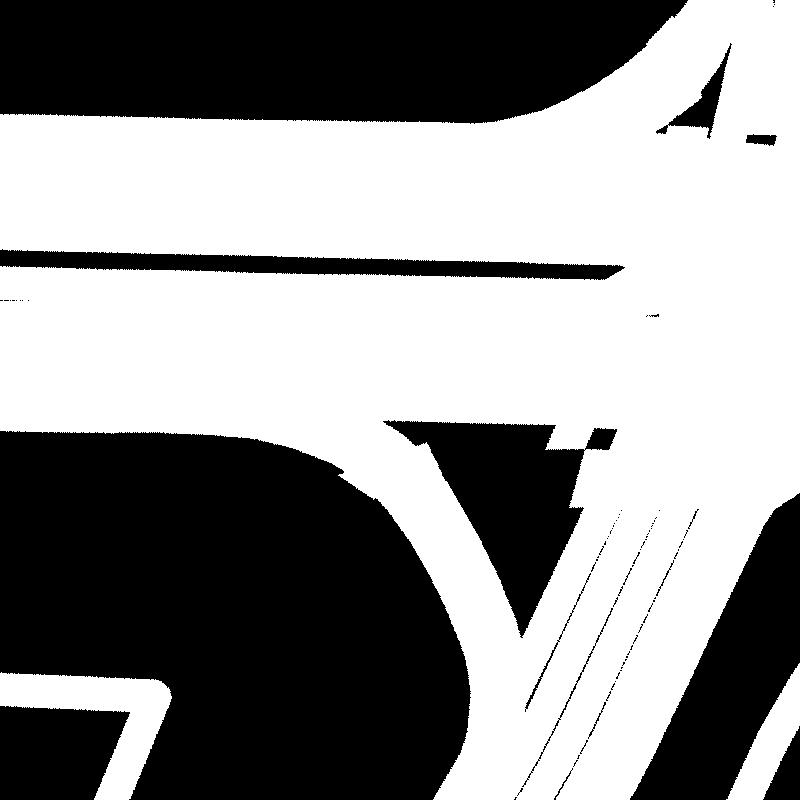

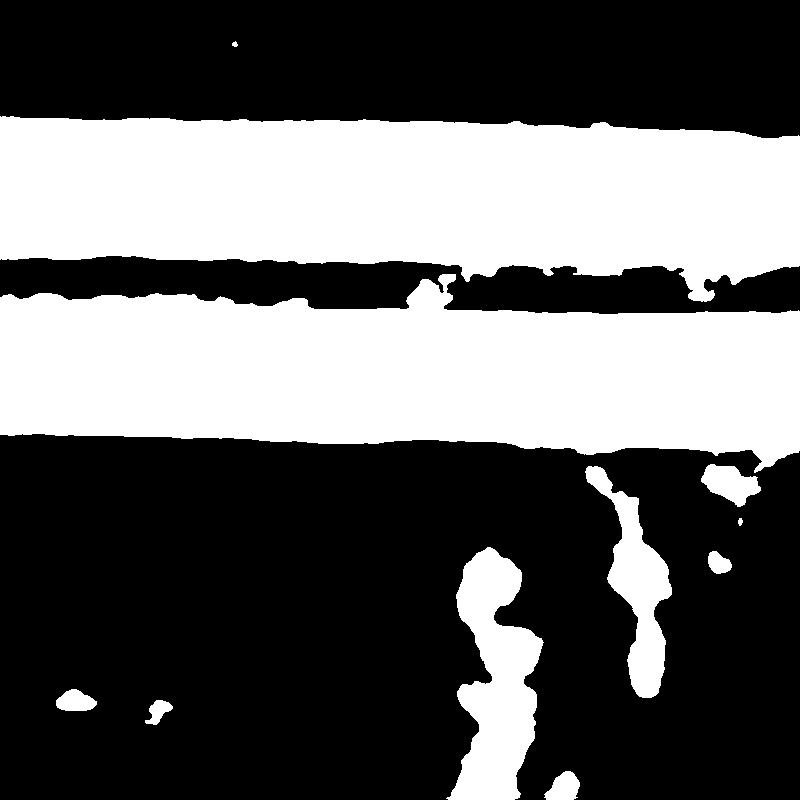

epoch 65, iter 0: 0.011627331376075745
epoch 65, iter 20: 0.009136974811553955
epoch 65, iter 40: 0.008563832379877567
epoch 65, iter 60: 0.00861333031207323
epoch 65, iter 80: 0.008149080909788609
epoch 65, iter 100: 0.014366433024406433
epoch 65, iter 120: 0.00974217802286148
epoch 65, iter 140: 0.009072552435100079
epoch 65, iter 160: 0.012933645397424698
epoch 65, iter 180: 0.013156414031982422
epoch 65, iter 200: 0.007763796951621771
epoch 65, iter 220: 0.009272439405322075
epoch 65, iter 240: 0.008014569990336895
epoch 65, iter 260: 0.009412247687578201
epoch 65, iter 280: 0.012845467776060104
epoch 65, iter 300: 0.010543044656515121
validation epoch 65: 0.08761870861053467


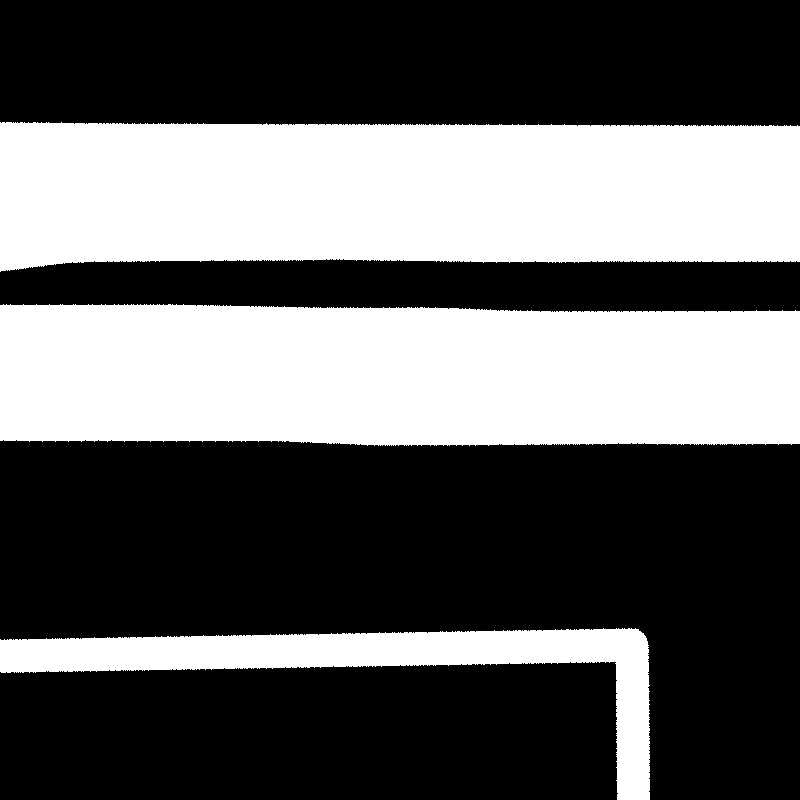

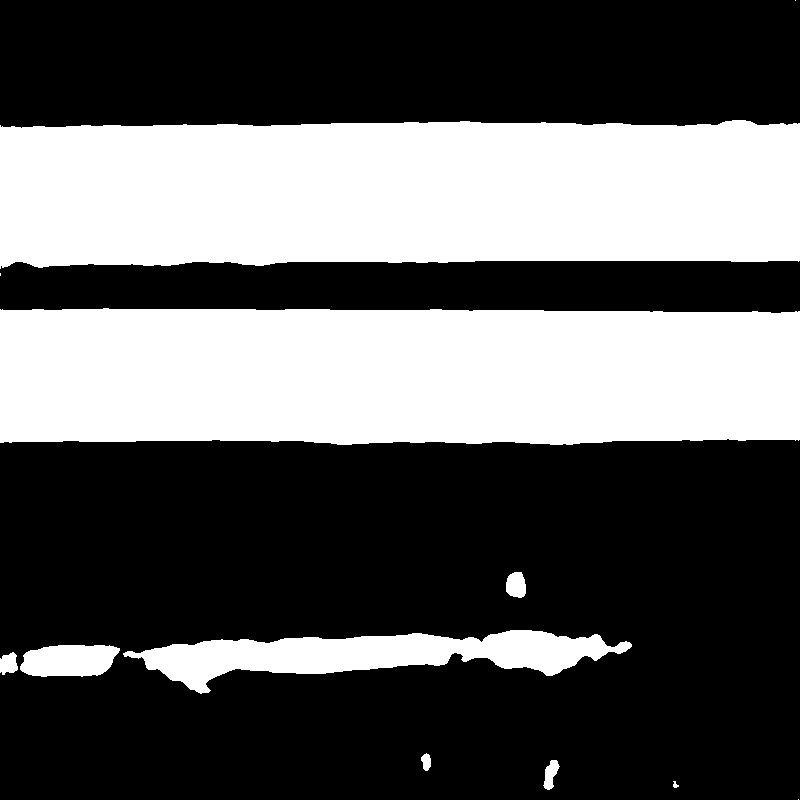

epoch 66, iter 0: 0.014110207557678223
epoch 66, iter 20: 0.010565062053501606
epoch 66, iter 40: 0.012877975590527058
epoch 66, iter 60: 0.01065181102603674
epoch 66, iter 80: 0.012817095965147018
epoch 66, iter 100: 0.014353222213685513
epoch 66, iter 120: 0.01332119107246399
epoch 66, iter 140: 0.012222259305417538
epoch 66, iter 160: 0.011801471002399921
epoch 66, iter 180: 0.011623312719166279
epoch 66, iter 200: 0.01023498922586441
epoch 66, iter 220: 0.01018894650042057
epoch 66, iter 240: 0.010028037242591381
epoch 66, iter 260: 0.007361832074820995
epoch 66, iter 280: 0.010938562452793121
epoch 66, iter 300: 0.009317942894995213
validation epoch 66: 0.08709149807691574


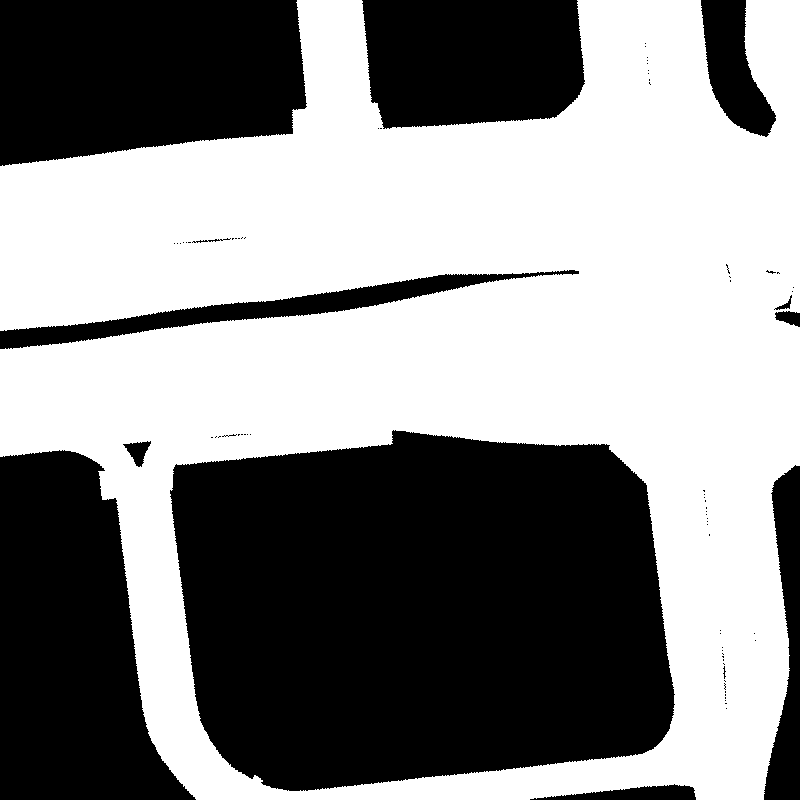

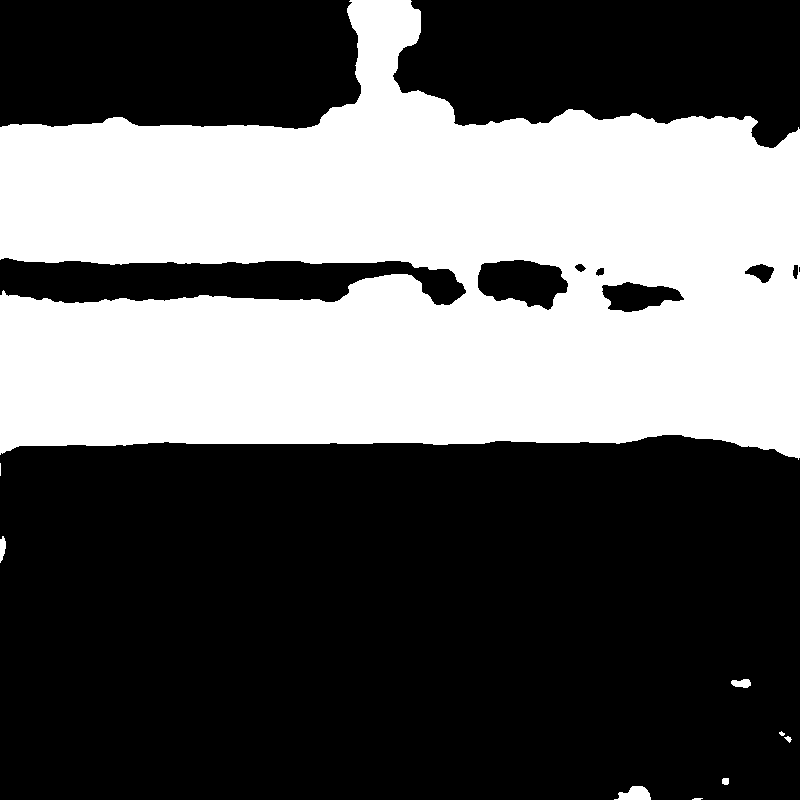

epoch 67, iter 0: 0.0097022894769907
epoch 67, iter 20: 0.008433339186012745
epoch 67, iter 40: 0.010336402803659439
epoch 67, iter 60: 0.00813731923699379
epoch 67, iter 80: 0.010787188075482845
epoch 67, iter 100: 0.01306138839572668
epoch 67, iter 120: 0.00983356311917305
epoch 67, iter 140: 0.010107931680977345
epoch 67, iter 160: 0.013261010870337486
epoch 67, iter 180: 0.010221059434115887
epoch 67, iter 200: 0.007748066447675228
epoch 67, iter 220: 0.013646448962390423
epoch 67, iter 240: 0.012316454201936722
epoch 67, iter 260: 0.010552010498940945
epoch 67, iter 280: 0.009701958857476711
epoch 67, iter 300: 0.009087464772164822
validation epoch 67: 0.08513257652521133


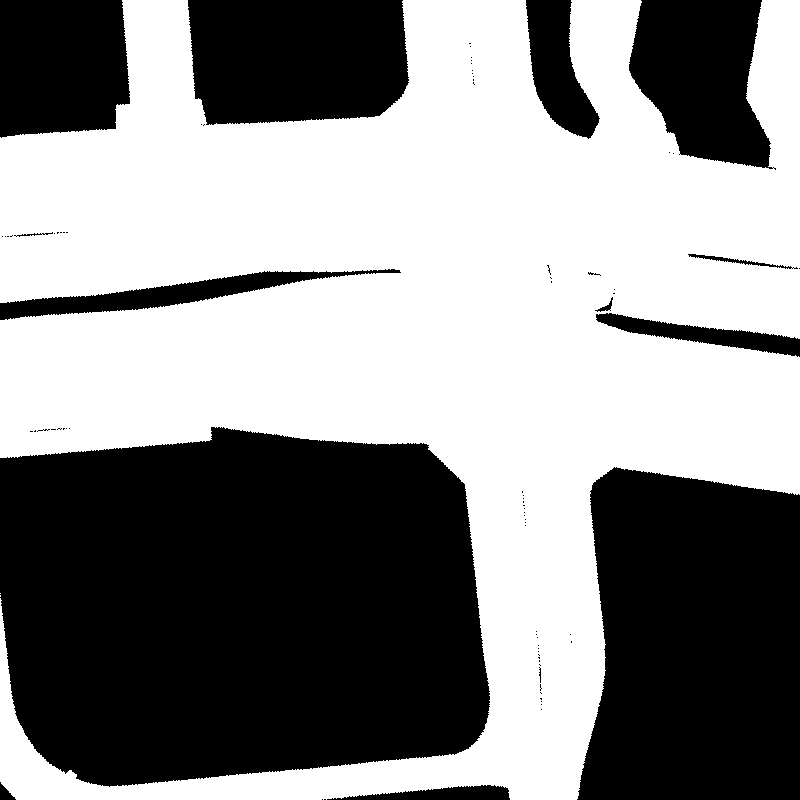

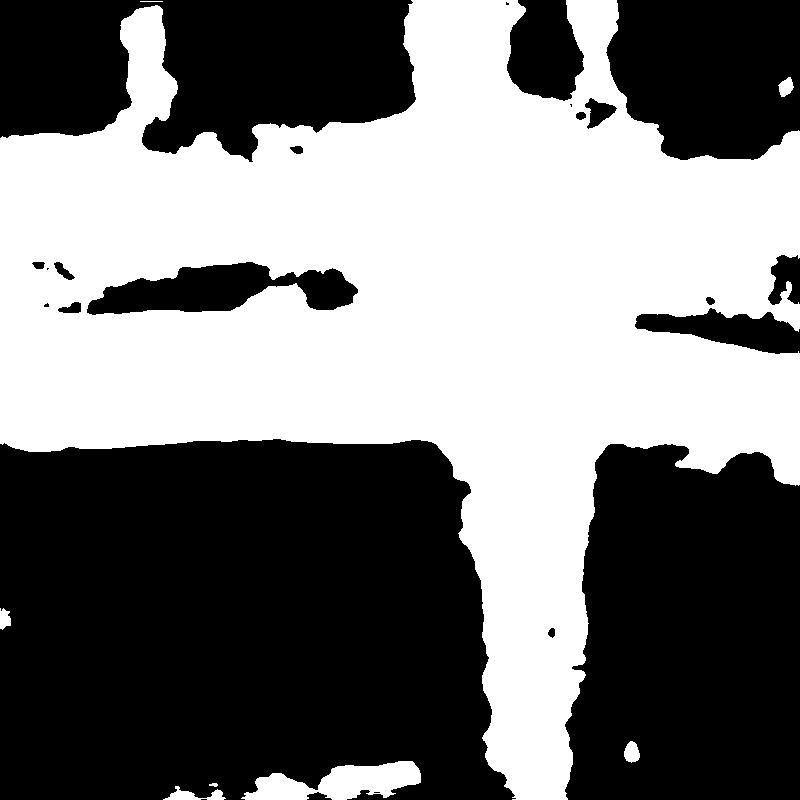

epoch 68, iter 0: 0.008942152373492718
epoch 68, iter 20: 0.015605298802256584
epoch 68, iter 40: 0.007882990874350071
epoch 68, iter 60: 0.011052398011088371
epoch 68, iter 80: 0.005867457017302513
epoch 68, iter 100: 0.005417524836957455
epoch 68, iter 120: 0.010013842955231667
epoch 68, iter 140: 0.010749035514891148
epoch 68, iter 160: 0.012915742583572865
epoch 68, iter 180: 0.007406068034470081
epoch 68, iter 200: 0.01268791500478983
epoch 68, iter 220: 0.010536868125200272
epoch 68, iter 240: 0.011873300187289715
epoch 68, iter 260: 0.011830857954919338
epoch 68, iter 280: 0.01347257662564516
epoch 68, iter 300: 0.010897699743509293
validation epoch 68: 0.08814510703086853


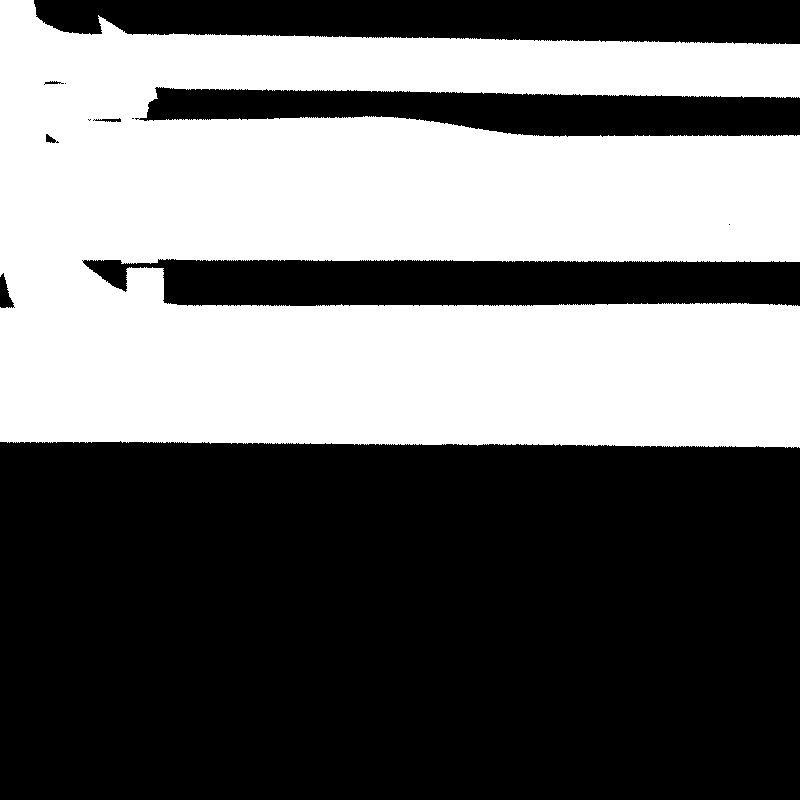

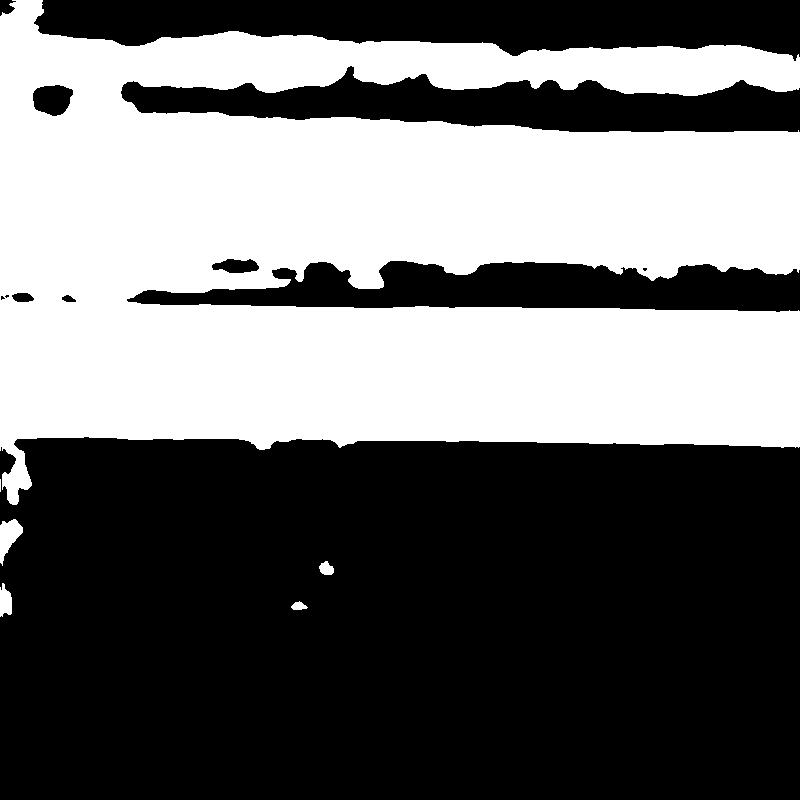

epoch 69, iter 0: 0.011273713782429695
epoch 69, iter 20: 0.013195100240409374
epoch 69, iter 40: 0.009654075838625431
epoch 69, iter 60: 0.014327391982078552
epoch 69, iter 80: 0.009155450388789177
epoch 69, iter 100: 0.011701851151883602
epoch 69, iter 120: 0.009725604206323624
epoch 69, iter 140: 0.012190688401460648
epoch 69, iter 160: 0.01095183938741684
epoch 69, iter 180: 0.011029821820557117
epoch 69, iter 200: 0.007277911063283682
epoch 69, iter 220: 0.009433978237211704
epoch 69, iter 240: 0.012458130717277527
epoch 69, iter 260: 0.011302269995212555
epoch 69, iter 280: 0.009617524221539497
epoch 69, iter 300: 0.007538334466516972
validation epoch 69: 0.0846916139125824


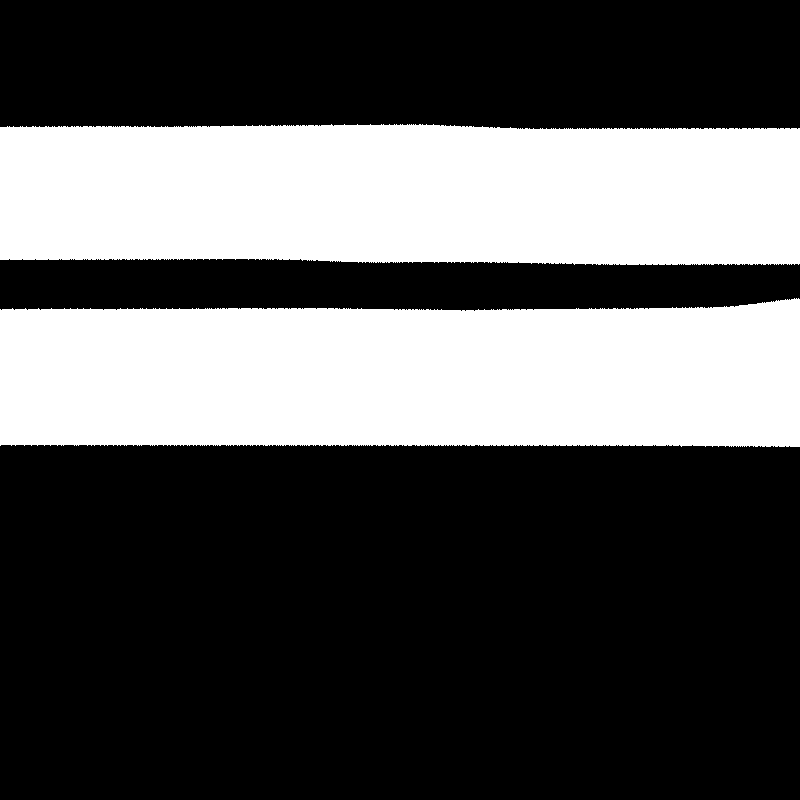

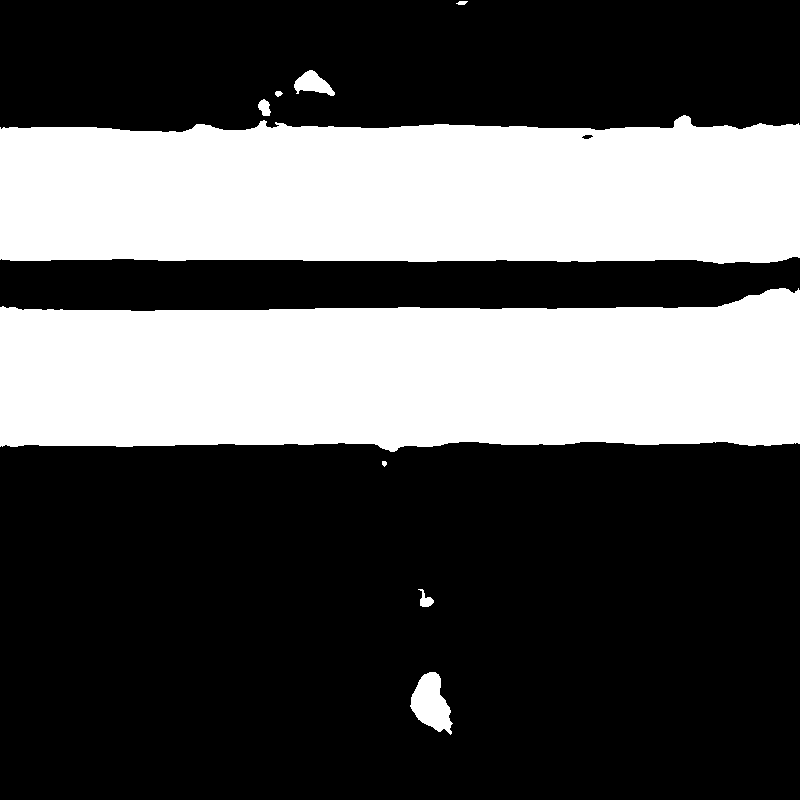

epoch 70, iter 0: 0.01163494773209095
epoch 70, iter 20: 0.009811120107769966
epoch 70, iter 40: 0.010815929621458054
epoch 70, iter 60: 0.007368946447968483
epoch 70, iter 80: 0.010237415321171284
epoch 70, iter 100: 0.011917524971067905
epoch 70, iter 120: 0.00870398711413145
epoch 70, iter 140: 0.006480193696916103
epoch 70, iter 160: 0.009983206167817116
epoch 70, iter 180: 0.010448800399899483
epoch 70, iter 200: 0.009288902394473553
epoch 70, iter 220: 0.01405329816043377
epoch 70, iter 240: 0.010965375229716301
epoch 70, iter 260: 0.012197675183415413
epoch 70, iter 280: 0.010971499606966972
epoch 70, iter 300: 0.010026917792856693
validation epoch 70: 0.08980123698711395


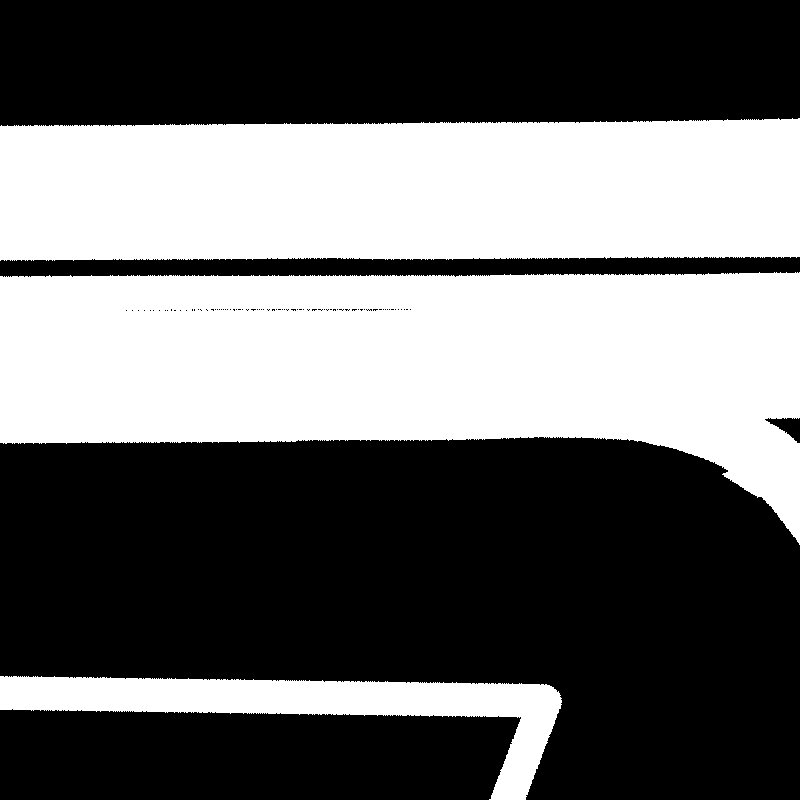

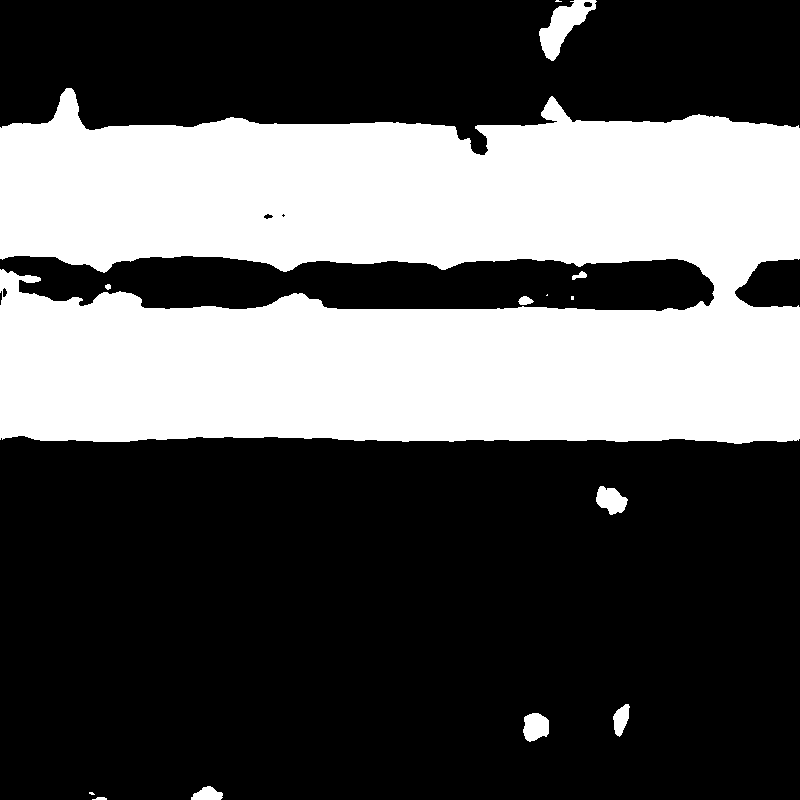

epoch 71, iter 0: 0.010756437666714191
epoch 71, iter 20: 0.012902392074465752
epoch 71, iter 40: 0.01211833581328392
epoch 71, iter 60: 0.007653786335140467
epoch 71, iter 80: 0.007922806777060032
epoch 71, iter 100: 0.011995146051049232
epoch 71, iter 120: 0.009316123090684414
epoch 71, iter 140: 0.007657040376216173
epoch 71, iter 160: 0.010579511523246765
epoch 71, iter 180: 0.008470207452774048
epoch 71, iter 200: 0.014925993047654629
epoch 71, iter 220: 0.011009786278009415
epoch 71, iter 240: 0.01163413468748331
epoch 71, iter 260: 0.009019123390316963
epoch 71, iter 280: 0.00926244631409645
epoch 71, iter 300: 0.015175851061940193
validation epoch 71: 0.08783657103776932


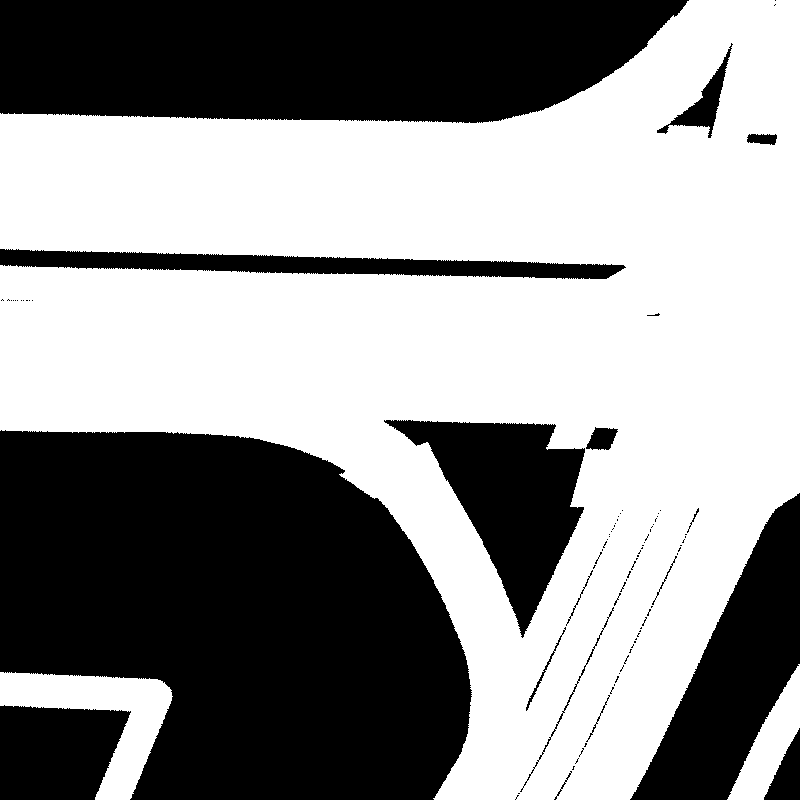

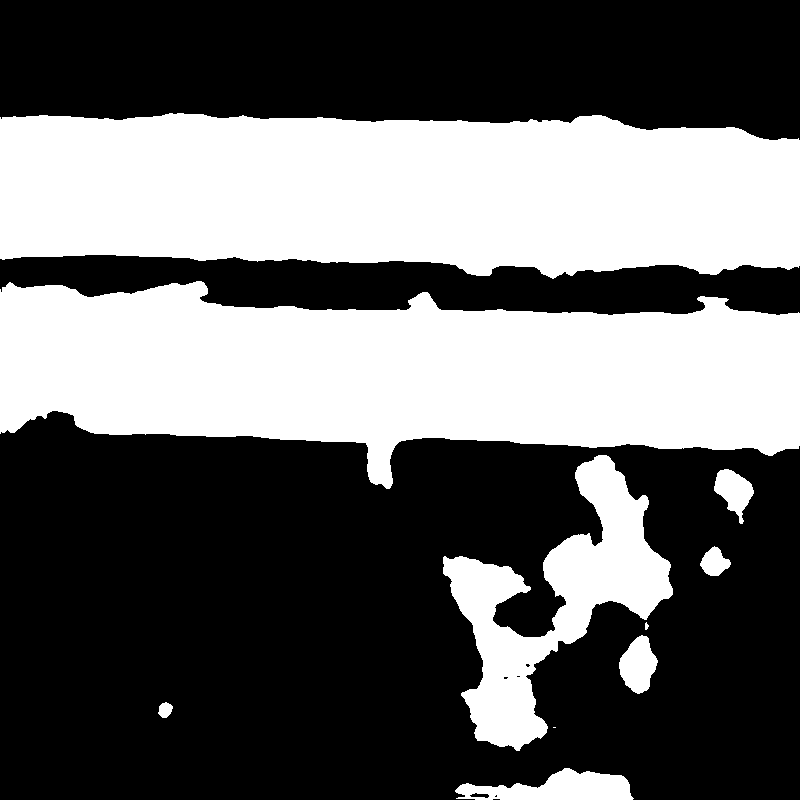

epoch 72, iter 0: 0.01142791472375393
epoch 72, iter 20: 0.01064383890479803
epoch 72, iter 40: 0.009589125402271748
epoch 72, iter 60: 0.01271185465157032
epoch 72, iter 80: 0.01139803882688284
epoch 72, iter 100: 0.01381133496761322
epoch 72, iter 120: 0.00853098463267088
epoch 72, iter 140: 0.011556182987987995
epoch 72, iter 160: 0.008040652610361576
epoch 72, iter 180: 0.011405655182898045
epoch 72, iter 200: 0.011664374731481075


RuntimeError: ignored

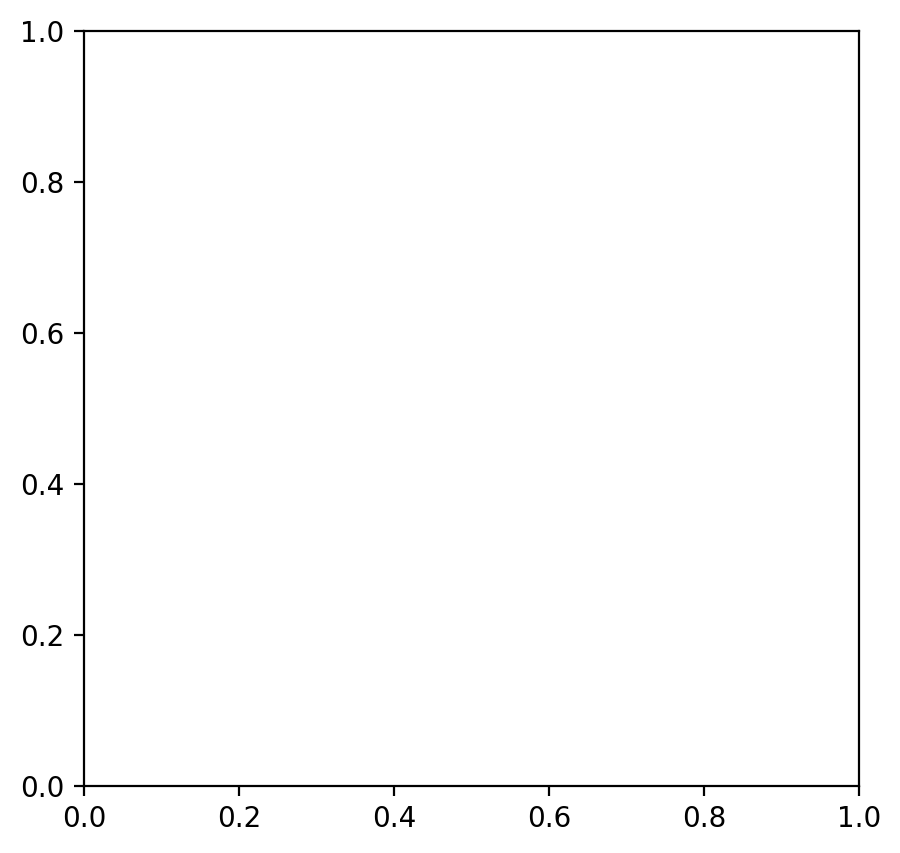

In [0]:
# Train
batch_size=8
version=2
labeled_trainset = LabeledDataset(image_folder=image_folder,
                                      annotation_file=annotation_csv,
                                      scene_index=labeled_scene_train_index,
                                      transform=transform,
                                      extra_info=True)
trainloader = torch.utils.data.DataLoader(labeled_trainset, 
                                          batch_size=batch_size, 
                                          shuffle=True, 
                                          num_workers=8, 
                                          collate_fn=collate_fn)
labeled_validationset = LabeledDataset(image_folder=image_folder,
                                      annotation_file=annotation_csv,
                                      scene_index=labeled_scene_validation_index,
                                      transform=transform,
                                      extra_info=True)
validationloader = torch.utils.data.DataLoader(labeled_validationset, 
                                          batch_size=batch_size, 
                                          shuffle=True, 
                                          num_workers=8, 
                                          collate_fn=collate_fn)
model = RoadModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, betas = (0.9,0.999))
loss = nn.MSELoss()
# model.load_state_dict(torch.load('/content/drive/My Drive/models/road_version-2_epoch-55.pth'))
# calc_threat(model, validationloader)
train(model, optimizer, trainloader, validationloader, loss, batch_size, version)


In [0]:
i = 0
for sample, target, road_image, extra in trainloader:
          optimizer.zero_grad()
          batch = torch.stack(sample).permute(1, 0, 2, 3, 4)
          batch = batch.to(device)
          if i % 100 == 0:
              print(target)
          i += 1

In [0]:
chkpnt = torch.load('/content/drive/My Drive/1008-competition/model_run/BoundingBoxModel/detect_version-1_epoch-43.pth', map_location=device)
chkpnt.keys()

In [0]:
import matplotlib.pyplot as plt

#Plot
fig = plt.figure()
fig.set_size_inches(6,4)

plt.plot([x.item() for x in chkpnt['full_metrics']['train']['loss']['epochwise']], label='Train')
plt.plot([x.item() for x in chkpnt['full_metrics']['val']['loss']['epochwise']], label='Val')

plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Model Performance')
plt.legend(loc='best')

plt.savefig('/content/drive/My Drive/1008-competition/RoadModelResults.png')
plt.show()